## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 217)
Hypercube shape: (512, 217, 204)


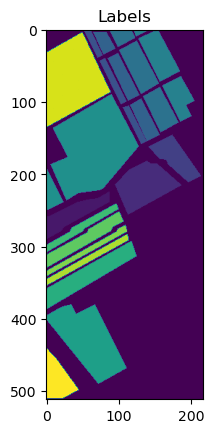

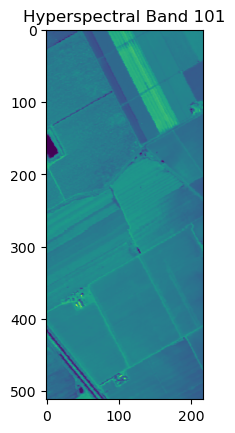

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Salinas_gt.mat'
data_files = 'Salinas_corrected.mat'
label_files = 'salinas_gt'
hypercube_files = 'salinas_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 54129
Extracted windows shape: (54129, 5, 5, 204)
Corresponding labels shape: (54129,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 2009 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 3726 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 1976 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 1394 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 2678 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 3959 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 3579 samples
Shuffled class indices fo


 -- Test set created with: 
	53409 samples
	shape (53409, 5, 5, 204) --




All datasets saved to the 'indices' folder.
(640, 5, 5, 204)
(80, 5, 5, 204)
(53409, 5, 5, 204)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 320
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (43303, 5, 5, 204)
Validation data shape: (10826, 5, 5, 204)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

204


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/677], Loss: 0.1611, PSNR: 7.0386


	 Training Batch [200/677], Loss: 0.0897, PSNR: 9.2277


	 Training Batch [400/677], Loss: 0.0449, PSNR: 12.6180


	 Training Batch [600/677], Loss: 0.0267, PSNR: 14.8961


Epoch [1/50] Training Loss: 0.0685, PSNR: 11.5366
	[Val]   Batch [1/170] Loss: 0.0215, PSNR: 15.7662
	[Val]   Batch [10/170] Loss: 0.0212, PSNR: 15.9260
	[Val]   Batch [20/170] Loss: 0.0213, PSNR: 15.8277
	[Val]   Batch [30/170] Loss: 0.0220, PSNR: 15.6234
	[Val]   Batch [40/170] Loss: 0.0221, PSNR: 15.6991


	[Val]   Batch [50/170] Loss: 0.0209, PSNR: 15.9074
	[Val]   Batch [60/170] Loss: 0.0219, PSNR: 15.7849
	[Val]   Batch [70/170] Loss: 0.0214, PSNR: 15.8778
	[Val]   Batch [80/170] Loss: 0.0218, PSNR: 15.6826
	[Val]   Batch [90/170] Loss: 0.0211, PSNR: 15.9291


	[Val]   Batch [100/170] Loss: 0.0212, PSNR: 15.8511
	[Val]   Batch [110/170] Loss: 0.0212, PSNR: 15.8307
	[Val]   Batch [120/170] Loss: 0.0200, PSNR: 14.1456
	[Val]   Batch [130/170] Loss: 0.0211, PSNR: 15.9347
	[Val]   Batch [140/170] Loss: 0.0207, PSNR: 15.9828


	[Val]   Batch [150/170] Loss: 0.0221, PSNR: 15.7301
	[Val]   Batch [160/170] Loss: 0.0217, PSNR: 15.7712
	[Val]   Batch [170/170] Loss: 0.0226, PSNR: 15.0590
Epoch [1/50] Validation Loss: 0.0215, PSNR: 15.7539

LOG: Epoch [2/50]
	 Training Batch [1/677], Loss: 0.0209, PSNR: 15.8625


	 Training Batch [200/677], Loss: 0.0158, PSNR: 17.2031


	 Training Batch [400/677], Loss: 0.0118, PSNR: 18.0627


	 Training Batch [600/677], Loss: 0.0091, PSNR: 19.5634


Epoch [2/50] Training Loss: 0.0132, PSNR: 18.0253
	[Val]   Batch [1/170] Loss: 0.0088, PSNR: 19.6316
	[Val]   Batch [10/170] Loss: 0.0083, PSNR: 19.9678
	[Val]   Batch [20/170] Loss: 0.0085, PSNR: 19.8366
	[Val]   Batch [30/170] Loss: 0.0091, PSNR: 19.4426
	[Val]   Batch [40/170] Loss: 0.0094, PSNR: 19.4310


	[Val]   Batch [50/170] Loss: 0.0082, PSNR: 19.9725
	[Val]   Batch [60/170] Loss: 0.0091, PSNR: 19.5849
	[Val]   Batch [70/170] Loss: 0.0089, PSNR: 19.6951
	[Val]   Batch [80/170] Loss: 0.0090, PSNR: 19.5416
	[Val]   Batch [90/170] Loss: 0.0086, PSNR: 19.8323


	[Val]   Batch [100/170] Loss: 0.0086, PSNR: 19.7578
	[Val]   Batch [110/170] Loss: 0.0085, PSNR: 19.8072
	[Val]   Batch [120/170] Loss: 0.0075, PSNR: 18.4329
	[Val]   Batch [130/170] Loss: 0.0086, PSNR: 19.8494
	[Val]   Batch [140/170] Loss: 0.0080, PSNR: 20.1087


	[Val]   Batch [150/170] Loss: 0.0093, PSNR: 19.4861
	[Val]   Batch [160/170] Loss: 0.0090, PSNR: 19.5816
	[Val]   Batch [170/170] Loss: 0.0093, PSNR: 18.8943
Epoch [2/50] Validation Loss: 0.0087, PSNR: 19.6757

LOG: Epoch [3/50]
	 Training Batch [1/677], Loss: 0.0085, PSNR: 19.8512


	 Training Batch [200/677], Loss: 0.0080, PSNR: 20.1271


	 Training Batch [400/677], Loss: 0.0074, PSNR: 20.4497


	 Training Batch [600/677], Loss: 0.0046, PSNR: 22.4253


Epoch [3/50] Training Loss: 0.0065, PSNR: 21.0008
	[Val]   Batch [1/170] Loss: 0.0046, PSNR: 22.4187
	[Val]   Batch [10/170] Loss: 0.0044, PSNR: 22.7086
	[Val]   Batch [20/170] Loss: 0.0045, PSNR: 22.6058
	[Val]   Batch [30/170] Loss: 0.0049, PSNR: 22.1881
	[Val]   Batch [40/170] Loss: 0.0049, PSNR: 22.2193


	[Val]   Batch [50/170] Loss: 0.0044, PSNR: 22.6396
	[Val]   Batch [60/170] Loss: 0.0048, PSNR: 22.3475
	[Val]   Batch [70/170] Loss: 0.0047, PSNR: 22.4959
	[Val]   Batch [80/170] Loss: 0.0047, PSNR: 22.3425
	[Val]   Batch [90/170] Loss: 0.0046, PSNR: 22.5674


	[Val]   Batch [100/170] Loss: 0.0046, PSNR: 22.4419
	[Val]   Batch [110/170] Loss: 0.0045, PSNR: 22.5326
	[Val]   Batch [120/170] Loss: 0.0041, PSNR: 21.0672
	[Val]   Batch [130/170] Loss: 0.0046, PSNR: 22.5539
	[Val]   Batch [140/170] Loss: 0.0042, PSNR: 22.8701


	[Val]   Batch [150/170] Loss: 0.0049, PSNR: 22.2649
	[Val]   Batch [160/170] Loss: 0.0048, PSNR: 22.3668
	[Val]   Batch [170/170] Loss: 0.0048, PSNR: 21.7771
Epoch [3/50] Validation Loss: 0.0046, PSNR: 22.4383

LOG: Epoch [4/50]
	 Training Batch [1/677], Loss: 0.0045, PSNR: 22.5614


	 Training Batch [200/677], Loss: 0.0038, PSNR: 23.2639


	 Training Batch [400/677], Loss: 0.0035, PSNR: 23.7471


	 Training Batch [600/677], Loss: 0.0028, PSNR: 24.0813


Epoch [4/50] Training Loss: 0.0036, PSNR: 23.5656
	[Val]   Batch [1/170] Loss: 0.0027, PSNR: 24.8338
	[Val]   Batch [10/170] Loss: 0.0026, PSNR: 25.0695
	[Val]   Batch [20/170] Loss: 0.0026, PSNR: 24.9336
	[Val]   Batch [30/170] Loss: 0.0028, PSNR: 24.4986
	[Val]   Batch [40/170] Loss: 0.0028, PSNR: 24.7216


	[Val]   Batch [50/170] Loss: 0.0026, PSNR: 24.9241
	[Val]   Batch [60/170] Loss: 0.0028, PSNR: 24.7330
	[Val]   Batch [70/170] Loss: 0.0026, PSNR: 24.9473
	[Val]   Batch [80/170] Loss: 0.0027, PSNR: 24.7640


	[Val]   Batch [90/170] Loss: 0.0026, PSNR: 24.9440
	[Val]   Batch [100/170] Loss: 0.0028, PSNR: 24.6828
	[Val]   Batch [110/170] Loss: 0.0026, PSNR: 24.9585
	[Val]   Batch [120/170] Loss: 0.0025, PSNR: 23.2053
	[Val]   Batch [130/170] Loss: 0.0028, PSNR: 24.7609


	[Val]   Batch [140/170] Loss: 0.0025, PSNR: 25.2255
	[Val]   Batch [150/170] Loss: 0.0028, PSNR: 24.6810
	[Val]   Batch [160/170] Loss: 0.0027, PSNR: 24.7851
	[Val]   Batch [170/170] Loss: 0.0028, PSNR: 24.0633
Epoch [4/50] Validation Loss: 0.0027, PSNR: 24.7899

LOG: Epoch [5/50]
	 Training Batch [1/677], Loss: 0.0030, PSNR: 24.3573


	 Training Batch [200/677], Loss: 0.0024, PSNR: 25.2268


	 Training Batch [400/677], Loss: 0.0021, PSNR: 25.8609


	 Training Batch [600/677], Loss: 0.0020, PSNR: 26.1848


Epoch [5/50] Training Loss: 0.0024, PSNR: 25.3699
	[Val]   Batch [1/170] Loss: 0.0018, PSNR: 26.4691
	[Val]   Batch [10/170] Loss: 0.0018, PSNR: 26.7338
	[Val]   Batch [20/170] Loss: 0.0018, PSNR: 26.5224
	[Val]   Batch [30/170] Loss: 0.0020, PSNR: 26.0344
	[Val]   Batch [40/170] Loss: 0.0019, PSNR: 26.4262


	[Val]   Batch [50/170] Loss: 0.0018, PSNR: 26.5254
	[Val]   Batch [60/170] Loss: 0.0019, PSNR: 26.3322
	[Val]   Batch [70/170] Loss: 0.0018, PSNR: 26.6389
	[Val]   Batch [80/170] Loss: 0.0018, PSNR: 26.3983


	[Val]   Batch [90/170] Loss: 0.0018, PSNR: 26.5887
	[Val]   Batch [100/170] Loss: 0.0019, PSNR: 26.2177
	[Val]   Batch [110/170] Loss: 0.0017, PSNR: 26.7266
	[Val]   Batch [120/170] Loss: 0.0017, PSNR: 24.7467
	[Val]   Batch [130/170] Loss: 0.0019, PSNR: 26.2774


	[Val]   Batch [140/170] Loss: 0.0017, PSNR: 26.8833
	[Val]   Batch [150/170] Loss: 0.0020, PSNR: 26.2813
	[Val]   Batch [160/170] Loss: 0.0019, PSNR: 26.4179
	[Val]   Batch [170/170] Loss: 0.0020, PSNR: 25.6465
Epoch [5/50] Validation Loss: 0.0019, PSNR: 26.3981

LOG: Epoch [6/50]
	 Training Batch [1/677], Loss: 0.0021, PSNR: 26.0006


	 Training Batch [200/677], Loss: 0.0018, PSNR: 26.4737


	 Training Batch [400/677], Loss: 0.0016, PSNR: 27.0240


	 Training Batch [600/677], Loss: 0.0017, PSNR: 26.7939


Epoch [6/50] Training Loss: 0.0018, PSNR: 26.5976
	[Val]   Batch [1/170] Loss: 0.0014, PSNR: 27.7324
	[Val]   Batch [10/170] Loss: 0.0013, PSNR: 28.0000
	[Val]   Batch [20/170] Loss: 0.0014, PSNR: 27.7494
	[Val]   Batch [30/170] Loss: 0.0015, PSNR: 27.2204
	[Val]   Batch [40/170] Loss: 0.0014, PSNR: 27.7267
	[Val]   Batch [50/170] Loss: 0.0014, PSNR: 27.6754


	[Val]   Batch [60/170] Loss: 0.0015, PSNR: 27.5576
	[Val]   Batch [70/170] Loss: 0.0013, PSNR: 27.9521
	[Val]   Batch [80/170] Loss: 0.0014, PSNR: 27.6757
	[Val]   Batch [90/170] Loss: 0.0014, PSNR: 27.8311
	[Val]   Batch [100/170] Loss: 0.0015, PSNR: 27.3865


	[Val]   Batch [110/170] Loss: 0.0013, PSNR: 28.0762
	[Val]   Batch [120/170] Loss: 0.0013, PSNR: 25.8671
	[Val]   Batch [130/170] Loss: 0.0015, PSNR: 27.4625
	[Val]   Batch [140/170] Loss: 0.0013, PSNR: 28.1333
	[Val]   Batch [150/170] Loss: 0.0015, PSNR: 27.5243


	[Val]   Batch [160/170] Loss: 0.0014, PSNR: 27.6813
	[Val]   Batch [170/170] Loss: 0.0014, PSNR: 26.9910
Epoch [6/50] Validation Loss: 0.0014, PSNR: 27.6417

LOG: Epoch [7/50]
	 Training Batch [1/677], Loss: 0.0015, PSNR: 27.4604


	 Training Batch [200/677], Loss: 0.0014, PSNR: 27.5538


	 Training Batch [400/677], Loss: 0.0014, PSNR: 27.6879


	 Training Batch [600/677], Loss: 0.0012, PSNR: 28.5523


Epoch [7/50] Training Loss: 0.0014, PSNR: 27.5755
	[Val]   Batch [1/170] Loss: 0.0011, PSNR: 28.6465
	[Val]   Batch [10/170] Loss: 0.0011, PSNR: 28.8737
	[Val]   Batch [20/170] Loss: 0.0011, PSNR: 28.5816
	[Val]   Batch [30/170] Loss: 0.0013, PSNR: 28.0294
	[Val]   Batch [40/170] Loss: 0.0011, PSNR: 28.6658
	[Val]   Batch [50/170] Loss: 0.0011, PSNR: 28.5090


	[Val]   Batch [60/170] Loss: 0.0012, PSNR: 28.4075
	[Val]   Batch [70/170] Loss: 0.0011, PSNR: 28.9072
	[Val]   Batch [80/170] Loss: 0.0011, PSNR: 28.5434
	[Val]   Batch [90/170] Loss: 0.0011, PSNR: 28.7512
	[Val]   Batch [100/170] Loss: 0.0012, PSNR: 28.2290


	[Val]   Batch [110/170] Loss: 0.0010, PSNR: 29.0407
	[Val]   Batch [120/170] Loss: 0.0011, PSNR: 26.6867
	[Val]   Batch [130/170] Loss: 0.0012, PSNR: 28.2929
	[Val]   Batch [140/170] Loss: 0.0010, PSNR: 29.0320
	[Val]   Batch [150/170] Loss: 0.0012, PSNR: 28.3541


	[Val]   Batch [160/170] Loss: 0.0011, PSNR: 28.5698
	[Val]   Batch [170/170] Loss: 0.0012, PSNR: 27.7765
Epoch [7/50] Validation Loss: 0.0011, PSNR: 28.4990

LOG: Epoch [8/50]
	 Training Batch [1/677], Loss: 0.0013, PSNR: 28.2028


	 Training Batch [200/677], Loss: 0.0013, PSNR: 27.9251


	 Training Batch [400/677], Loss: 0.0011, PSNR: 28.3730


	 Training Batch [600/677], Loss: 0.0012, PSNR: 28.4126


Epoch [8/50] Training Loss: 0.0012, PSNR: 28.3504
	[Val]   Batch [1/170] Loss: 0.0009, PSNR: 29.6864
	[Val]   Batch [10/170] Loss: 0.0008, PSNR: 29.9203
	[Val]   Batch [20/170] Loss: 0.0009, PSNR: 29.5913
	[Val]   Batch [30/170] Loss: 0.0010, PSNR: 29.0229
	[Val]   Batch [40/170] Loss: 0.0009, PSNR: 29.7470


	[Val]   Batch [50/170] Loss: 0.0009, PSNR: 29.4656
	[Val]   Batch [60/170] Loss: 0.0009, PSNR: 29.4173
	[Val]   Batch [70/170] Loss: 0.0008, PSNR: 29.9724
	[Val]   Batch [80/170] Loss: 0.0009, PSNR: 29.6193


	[Val]   Batch [90/170] Loss: 0.0009, PSNR: 29.7956
	[Val]   Batch [100/170] Loss: 0.0010, PSNR: 29.1885
	[Val]   Batch [110/170] Loss: 0.0008, PSNR: 30.1595
	[Val]   Batch [120/170] Loss: 0.0009, PSNR: 27.5940
	[Val]   Batch [130/170] Loss: 0.0010, PSNR: 29.2699


	[Val]   Batch [140/170] Loss: 0.0008, PSNR: 30.0766
	[Val]   Batch [150/170] Loss: 0.0010, PSNR: 29.3633
	[Val]   Batch [160/170] Loss: 0.0009, PSNR: 29.5820
	[Val]   Batch [170/170] Loss: 0.0009, PSNR: 28.9372
Epoch [8/50] Validation Loss: 0.0009, PSNR: 29.5277

LOG: Epoch [9/50]
	 Training Batch [1/677], Loss: 0.0011, PSNR: 28.5563


	 Training Batch [200/677], Loss: 0.0011, PSNR: 28.7070


	 Training Batch [400/677], Loss: 0.0012, PSNR: 28.4586


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.8133


Epoch [9/50] Training Loss: 0.0010, PSNR: 29.0332
	[Val]   Batch [1/170] Loss: 0.0007, PSNR: 30.5232
	[Val]   Batch [10/170] Loss: 0.0007, PSNR: 30.7509
	[Val]   Batch [20/170] Loss: 0.0007, PSNR: 30.4028
	[Val]   Batch [30/170] Loss: 0.0008, PSNR: 29.8231
	[Val]   Batch [40/170] Loss: 0.0007, PSNR: 30.5963


	[Val]   Batch [50/170] Loss: 0.0008, PSNR: 30.2640
	[Val]   Batch [60/170] Loss: 0.0008, PSNR: 30.2303
	[Val]   Batch [70/170] Loss: 0.0007, PSNR: 30.8159
	[Val]   Batch [80/170] Loss: 0.0007, PSNR: 30.4647
	[Val]   Batch [90/170] Loss: 0.0007, PSNR: 30.6729


	[Val]   Batch [100/170] Loss: 0.0008, PSNR: 30.0039
	[Val]   Batch [110/170] Loss: 0.0006, PSNR: 31.0241
	[Val]   Batch [120/170] Loss: 0.0008, PSNR: 28.3941
	[Val]   Batch [130/170] Loss: 0.0008, PSNR: 30.0742


	[Val]   Batch [140/170] Loss: 0.0007, PSNR: 30.9460
	[Val]   Batch [150/170] Loss: 0.0008, PSNR: 30.1414
	[Val]   Batch [160/170] Loss: 0.0008, PSNR: 30.3750
	[Val]   Batch [170/170] Loss: 0.0008, PSNR: 29.7454
Epoch [9/50] Validation Loss: 0.0008, PSNR: 30.3375

LOG: Epoch [10/50]
	 Training Batch [1/677], Loss: 0.0010, PSNR: 28.9023


	 Training Batch [200/677], Loss: 0.0008, PSNR: 29.9981


	 Training Batch [400/677], Loss: 0.0009, PSNR: 29.5761


	 Training Batch [600/677], Loss: 0.0008, PSNR: 30.0310


Epoch [10/50] Training Loss: 0.0009, PSNR: 29.7035
	[Val]   Batch [1/170] Loss: 0.0006, PSNR: 31.1838
	[Val]   Batch [10/170] Loss: 0.0006, PSNR: 31.4305
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 31.0345
	[Val]   Batch [30/170] Loss: 0.0007, PSNR: 30.5015
	[Val]   Batch [40/170] Loss: 0.0006, PSNR: 31.2552
	[Val]   Batch [50/170] Loss: 0.0007, PSNR: 30.8933


	[Val]   Batch [60/170] Loss: 0.0007, PSNR: 30.8998
	[Val]   Batch [70/170] Loss: 0.0006, PSNR: 31.4605
	[Val]   Batch [80/170] Loss: 0.0006, PSNR: 31.1466
	[Val]   Batch [90/170] Loss: 0.0006, PSNR: 31.4093
	[Val]   Batch [100/170] Loss: 0.0007, PSNR: 30.7376


	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 31.7034
	[Val]   Batch [120/170] Loss: 0.0006, PSNR: 29.0555
	[Val]   Batch [130/170] Loss: 0.0007, PSNR: 30.8171
	[Val]   Batch [140/170] Loss: 0.0006, PSNR: 31.6227
	[Val]   Batch [150/170] Loss: 0.0007, PSNR: 30.8267


	[Val]   Batch [160/170] Loss: 0.0007, PSNR: 31.0043
	[Val]   Batch [170/170] Loss: 0.0007, PSNR: 30.4455
Epoch [10/50] Validation Loss: 0.0006, PSNR: 31.0062

LOG: Epoch [11/50]
	 Training Batch [1/677], Loss: 0.0008, PSNR: 30.1409


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.7415


	 Training Batch [400/677], Loss: 0.0008, PSNR: 29.9319


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.6361


Epoch [11/50] Training Loss: 0.0008, PSNR: 30.2692
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 31.8960
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.1766
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 31.7200
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 31.2406
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 31.9433


	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 31.5920
	[Val]   Batch [60/170] Loss: 0.0006, PSNR: 31.6200
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.1287
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 31.8776
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.1649


	[Val]   Batch [100/170] Loss: 0.0006, PSNR: 31.5026
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 32.4512
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 29.8041
	[Val]   Batch [130/170] Loss: 0.0006, PSNR: 31.5837
	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 32.3692


	[Val]   Batch [150/170] Loss: 0.0006, PSNR: 31.5262
	[Val]   Batch [160/170] Loss: 0.0006, PSNR: 31.6800
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.3144
Epoch [11/50] Validation Loss: 0.0005, PSNR: 31.7262

LOG: Epoch [12/50]
	 Training Batch [1/677], Loss: 0.0010, PSNR: 29.3504


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.1937


	 Training Batch [400/677], Loss: 0.0008, PSNR: 30.3448


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.5066


Epoch [12/50] Training Loss: 0.0007, PSNR: 30.7736
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 32.2075
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.4884
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 32.0193
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 31.6496
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 32.2999


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 31.8305
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 31.9913
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.4293
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 32.2325
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.5467


	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 31.9515
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 32.7450
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.1510
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 32.0241
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 32.6511


	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 31.9612
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.0034
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.7088
Epoch [12/50] Validation Loss: 0.0005, PSNR: 32.0652

LOG: Epoch [13/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.9224


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.3813


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.3202


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.4963


Epoch [13/50] Training Loss: 0.0006, PSNR: 31.2669
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.0540
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.3622
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 32.8108
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 32.5227
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.1506
	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 32.6228


	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 32.8686
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.2372
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 33.1484
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.4461
	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 32.8149


	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.6232
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 30.8886
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 32.9040
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.5094
	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 32.8427


	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 32.7862
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.7532
Epoch [13/50] Validation Loss: 0.0004, PSNR: 32.9217

LOG: Epoch [14/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.4769


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.4543


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.6001


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.4235


Epoch [14/50] Training Loss: 0.0006, PSNR: 31.5986
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.6101
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 33.9434
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.3579
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.1304
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 33.7237


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.1520
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.4859
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 33.7528
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 33.7665
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.0665


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.4195
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.2114
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.4038
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.5018


	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.0777
	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.4634
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.3203
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.4642
Epoch [14/50] Validation Loss: 0.0004, PSNR: 33.4919

LOG: Epoch [15/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.6380


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.5307


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.2989


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.6939


Epoch [15/50] Training Loss: 0.0005, PSNR: 31.9717
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 33.9760
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.3271
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 33.7168
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.5306
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.1274


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.4448
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 33.8958
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.1392
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.1548
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.4991


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 33.8781
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.5734
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 31.7827
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 33.9663
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.4466


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 33.9142
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.6789
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.8682
Epoch [15/50] Validation Loss: 0.0003, PSNR: 33.8799

LOG: Epoch [16/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 31.7657


	 Training Batch [200/677], Loss: 0.0005, PSNR: 31.8024


	 Training Batch [400/677], Loss: 0.0004, PSNR: 32.7148


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.4312


Epoch [16/50] Training Loss: 0.0005, PSNR: 32.2373
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.5918
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 35.0056
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.3480
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.1877


	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.7500
	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.0146
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.5899
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.7234
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.8953


	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 35.1828
	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.5472
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.2798
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.3322
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.6628


	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 35.0888
	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.5790
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.2658
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 34.7796
Epoch [16/50] Validation Loss: 0.0003, PSNR: 34.5342

LOG: Epoch [17/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 33.1787


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.6611


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.8932


	 Training Batch [600/677], Loss: 0.0005, PSNR: 31.7383


Epoch [17/50] Training Loss: 0.0005, PSNR: 32.5314
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 35.0176
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.4264
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.7617
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.6440
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 35.1201


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.4083
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 35.0355
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 35.0904
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.3254
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.6247


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.9883
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.7001
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.7373
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 35.0907
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.5184


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 35.0268
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.6404
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.3118
Epoch [17/50] Validation Loss: 0.0003, PSNR: 34.9442

LOG: Epoch [18/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 33.0040


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.7551


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.8444


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.4090


Epoch [18/50] Training Loss: 0.0004, PSNR: 32.7706
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 35.1042
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.5674
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.8684
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.7941
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.2402


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.5478
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 35.1635
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 35.1886
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.4430
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.7580


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.1962
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.8244
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.9387
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.2578
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.6590


	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.2294
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.7554
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.3574
Epoch [18/50] Validation Loss: 0.0003, PSNR: 35.0696

LOG: Epoch [19/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 32.7137


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.9241


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.1230


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.0027


Epoch [19/50] Training Loss: 0.0004, PSNR: 33.0209
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.3448
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.7452
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 35.0757
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 35.0350
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.4674


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.8080
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.4032
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.3781
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.6409
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 36.0480


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.3904
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.9955
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 33.1686
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.4803
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.8839


	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.3737
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.9353
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.5464
Epoch [19/50] Validation Loss: 0.0002, PSNR: 35.2646

LOG: Epoch [20/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 32.7396


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.6220


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.2982


	 Training Batch [600/677], Loss: 0.0003, PSNR: 33.8050


Epoch [20/50] Training Loss: 0.0004, PSNR: 33.2407
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.9118
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 36.2735
	[Val]   Batch [20/170] Loss: 0.0002, PSNR: 35.5640
	[Val]   Batch [30/170] Loss: 0.0002, PSNR: 35.5967
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 36.0382


	[Val]   Batch [50/170] Loss: 0.0002, PSNR: 35.2064
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 36.0255
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.9653
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 36.2625
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 36.6748


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 36.0227
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 36.5978
	[Val]   Batch [120/170] Loss: 0.0002, PSNR: 33.6549
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 36.1446
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 36.3937


	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 36.0406
	[Val]   Batch [160/170] Loss: 0.0002, PSNR: 35.4712
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 36.3003
Epoch [20/50] Validation Loss: 0.0002, PSNR: 35.8462
Early stopping triggered at epoch 20. No improvement for 3 epochs.


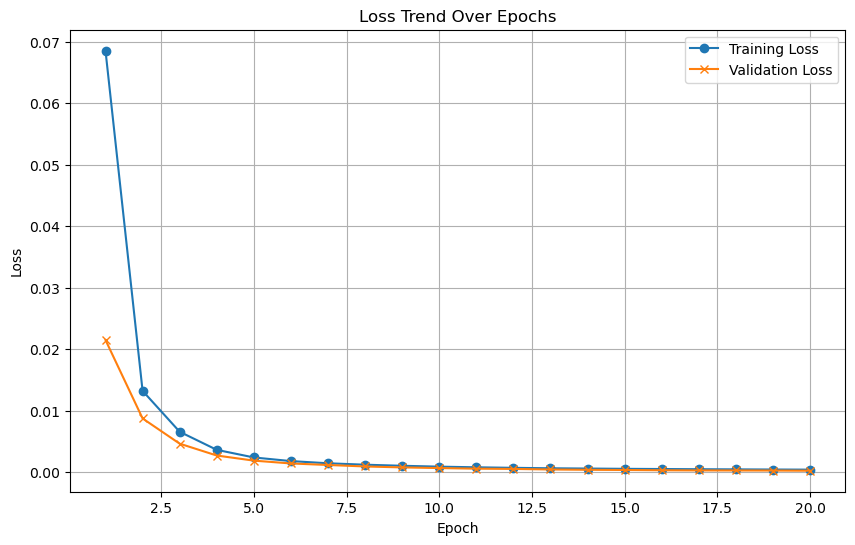

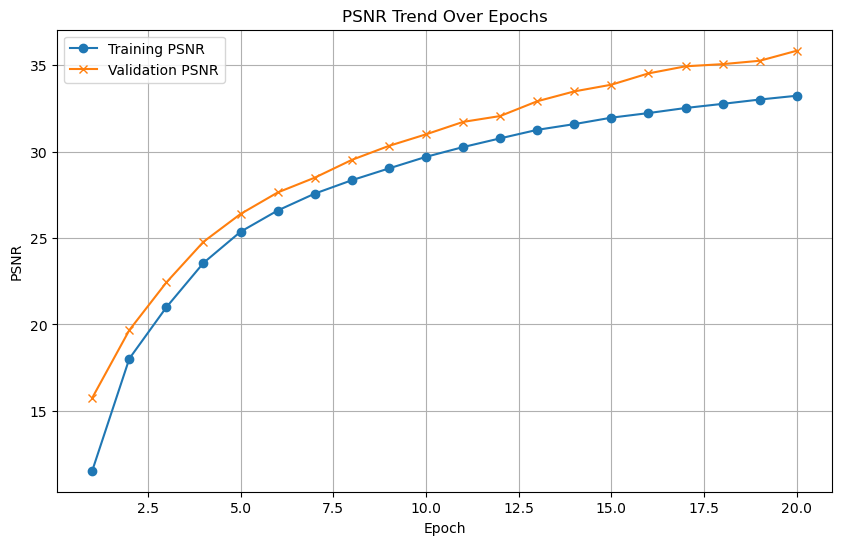

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/209 for test dataset.


    Processed batch 101/209 for test dataset.


    Processed batch 201/209 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7752
    Validation Batch [1/1], Loss: 2.7753
Validation Loss: 2.7753, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7753. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7029
    Validation Batch [1/1], Loss: 2.7753
Validation Loss: 2.7753, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.6567
    Validation Batch [1/1], Loss: 2.7753
Validation Loss: 2.7753, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.6338
    Validation Batch [1/1], Loss: 2.7752
Validation Loss: 2.7752, Validation Accuracy: 6.25%
Validation loss improved from 2.7753 to 2.7752. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] comple

    Validation Batch [1/1], Loss: 2.7744
Validation Loss: 2.7744, Validation Accuracy: 6.25%
Validation loss improved from 2.7747 to 2.7744. Saving model...

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.5060
    Validation Batch [1/1], Loss: 2.7740
Validation Loss: 2.7740, Validation Accuracy: 12.50%
Validation loss improved from 2.7744 to 2.7740. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.4915
    Validation Batch [1/1], Loss: 2.7733
Validation Loss: 2.7733, Validation Accuracy: 6.25%
Validation loss improved from 2.7740 to 2.7733. Saving model...

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.4687
    Validation Batch [1/1], Loss: 2.7722
Validation Loss: 2.7722, Validation Accuracy: 6.25%
Validation loss improved from 2.7733 to 2.7722. Saving model...

LOG: Epoch [13/1000] - Training
Epoch [13/1000] completed, Average Training Loss: 2.4550
    Validat

Epoch [23/1000] completed, Average Training Loss: 2.2870
    Validation Batch [1/1], Loss: 2.6452
Validation Loss: 2.6452, Validation Accuracy: 12.50%
Validation loss improved from 2.6757 to 2.6452. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.2634
    Validation Batch [1/1], Loss: 2.6084
Validation Loss: 2.6084, Validation Accuracy: 11.25%
Validation loss improved from 2.6452 to 2.6084. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.2349
    Validation Batch [1/1], Loss: 2.5777
Validation Loss: 2.5777, Validation Accuracy: 12.50%
Validation loss improved from 2.6084 to 2.5777. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 2.2343
    Validation Batch [1/1], Loss: 2.5345
Validation Loss: 2.5345, Validation Accuracy: 13.75%
Validation loss improved from 2.5777 to 2.5345. Saving model...

LOG: Epoch [27/1000] - Training
Epoch [2

Epoch [36/1000] completed, Average Training Loss: 2.0663
    Validation Batch [1/1], Loss: 2.1125
Validation Loss: 2.1125, Validation Accuracy: 52.50%
Validation loss improved from 2.1618 to 2.1125. Saving model...

LOG: Epoch [37/1000] - Training
Epoch [37/1000] completed, Average Training Loss: 2.0502
    Validation Batch [1/1], Loss: 2.0684
Validation Loss: 2.0684, Validation Accuracy: 55.00%
Validation loss improved from 2.1125 to 2.0684. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 2.0331
    Validation Batch [1/1], Loss: 2.0508
Validation Loss: 2.0508, Validation Accuracy: 60.00%
Validation loss improved from 2.0684 to 2.0508. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 2.0106
    Validation Batch [1/1], Loss: 2.0352
Validation Loss: 2.0352, Validation Accuracy: 53.75%
Validation loss improved from 2.0508 to 2.0352. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [4

Epoch [43/1000] completed, Average Training Loss: 1.9475
    Validation Batch [1/1], Loss: 1.9381
Validation Loss: 1.9381, Validation Accuracy: 61.25%
Validation loss improved from 1.9870 to 1.9381. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [44/1000] completed, Average Training Loss: 1.9325
    Validation Batch [1/1], Loss: 1.9060
Validation Loss: 1.9060, Validation Accuracy: 62.50%
Validation loss improved from 1.9381 to 1.9060. Saving model...

LOG: Epoch [45/1000] - Training
Epoch [45/1000] completed, Average Training Loss: 1.9228
    Validation Batch [1/1], Loss: 1.9084
Validation Loss: 1.9084, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [46/1000] - Training
Epoch [46/1000] completed, Average Training Loss: 1.8942
    Validation Batch [1/1], Loss: 1.8919
Validation Loss: 1.8919, Validation Accuracy: 63.75%
Validation loss improved from 1.9060 to 1.8919. Saving model...

LOG: Epoch [47/1000] - Training
Epoch [47/1000] complet

Epoch [55/1000] completed, Average Training Loss: 1.7421
    Validation Batch [1/1], Loss: 1.7286
Validation Loss: 1.7286, Validation Accuracy: 71.25%
Validation loss improved from 1.7578 to 1.7286. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 1.7215
    Validation Batch [1/1], Loss: 1.7057
Validation Loss: 1.7057, Validation Accuracy: 67.50%
Validation loss improved from 1.7286 to 1.7057. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 1.7146
    Validation Batch [1/1], Loss: 1.7011
Validation Loss: 1.7011, Validation Accuracy: 70.00%
Validation loss improved from 1.7057 to 1.7011. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 1.7179
    Validation Batch [1/1], Loss: 1.6758
Validation Loss: 1.6758, Validation Accuracy: 67.50%
Validation loss improved from 1.7011 to 1.6758. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [5

Epoch [68/1000] completed, Average Training Loss: 1.5422
    Validation Batch [1/1], Loss: 1.5002
Validation Loss: 1.5002, Validation Accuracy: 76.25%
Validation loss improved from 1.5245 to 1.5002. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.5221
    Validation Batch [1/1], Loss: 1.4917
Validation Loss: 1.4917, Validation Accuracy: 76.25%
Validation loss improved from 1.5002 to 1.4917. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 1.5049
    Validation Batch [1/1], Loss: 1.4589
Validation Loss: 1.4589, Validation Accuracy: 73.75%
Validation loss improved from 1.4917 to 1.4589. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 1.4767
    Validation Batch [1/1], Loss: 1.4366
Validation Loss: 1.4366, Validation Accuracy: 72.50%
Validation loss improved from 1.4589 to 1.4366. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [7

Epoch [82/1000] completed, Average Training Loss: 1.2908
    Validation Batch [1/1], Loss: 1.2519
Validation Loss: 1.2519, Validation Accuracy: 77.50%
Validation loss improved from 1.2888 to 1.2519. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 1.3047
    Validation Batch [1/1], Loss: 1.2620
Validation Loss: 1.2620, Validation Accuracy: 81.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 1.2896
    Validation Batch [1/1], Loss: 1.2424
Validation Loss: 1.2424, Validation Accuracy: 80.00%
Validation loss improved from 1.2519 to 1.2424. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 1.2554
    Validation Batch [1/1], Loss: 1.2318
Validation Loss: 1.2318, Validation Accuracy: 82.50%
Validation loss improved from 1.2424 to 1.2318. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] complet

    Validation Batch [1/1], Loss: 1.0612
Validation Loss: 1.0612, Validation Accuracy: 82.50%
Validation loss improved from 1.0960 to 1.0612. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 1.1152
    Validation Batch [1/1], Loss: 1.0878
Validation Loss: 1.0878, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.0833
    Validation Batch [1/1], Loss: 1.0975
Validation Loss: 1.0975, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.0677
    Validation Batch [1/1], Loss: 1.0505
Validation Loss: 1.0505, Validation Accuracy: 83.75%
Validation loss improved from 1.0612 to 1.0505. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.0543
    Validation Batch [1/1], Loss: 1.08

Epoch [108/1000] completed, Average Training Loss: 0.9416
    Validation Batch [1/1], Loss: 0.9007
Validation Loss: 0.9007, Validation Accuracy: 90.00%
Validation loss improved from 0.9175 to 0.9007. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 0.9223
    Validation Batch [1/1], Loss: 0.8891
Validation Loss: 0.8891, Validation Accuracy: 86.25%
Validation loss improved from 0.9007 to 0.8891. Saving model...

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 0.9271
    Validation Batch [1/1], Loss: 0.9111
Validation Loss: 0.9111, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 0.9153
    Validation Batch [1/1], Loss: 0.8364
Validation Loss: 0.8364, Validation Accuracy: 90.00%
Validation loss improved from 0.8891 to 0.8364. Saving model...

LOG: Epoch [112/1000] - Training
Epoch [112/1000

Epoch [122/1000] completed, Average Training Loss: 0.7903
    Validation Batch [1/1], Loss: 0.7345
Validation Loss: 0.7345, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 0.7615
    Validation Batch [1/1], Loss: 0.7111
Validation Loss: 0.7111, Validation Accuracy: 91.25%
Validation loss improved from 0.7195 to 0.7111. Saving model...

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 0.7272
    Validation Batch [1/1], Loss: 0.7165
Validation Loss: 0.7165, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 0.7470
    Validation Batch [1/1], Loss: 0.6704
Validation Loss: 0.6704, Validation Accuracy: 91.25%
Validation loss improved from 0.7111 to 0.6704. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Av

Epoch [135/1000] completed, Average Training Loss: 0.6236
    Validation Batch [1/1], Loss: 0.6239
Validation Loss: 0.6239, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Average Training Loss: 0.5812
    Validation Batch [1/1], Loss: 0.5854
Validation Loss: 0.5854, Validation Accuracy: 91.25%
Validation loss improved from 0.5976 to 0.5854. Saving model...

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 0.6102
    Validation Batch [1/1], Loss: 0.6607
Validation Loss: 0.6607, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 0.6028
    Validation Batch [1/1], Loss: 0.5692
Validation Loss: 0.5692, Validation Accuracy: 92.50%
Validation loss improved from 0.5854 to 0.5692. Saving model...

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Av

Epoch [148/1000] completed, Average Training Loss: 0.4956
    Validation Batch [1/1], Loss: 0.5050
Validation Loss: 0.5050, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 0.4884
    Validation Batch [1/1], Loss: 0.5096
Validation Loss: 0.5096, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 0.4861
    Validation Batch [1/1], Loss: 0.4575
Validation Loss: 0.4575, Validation Accuracy: 95.00%
Validation loss improved from 0.4721 to 0.4575. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 0.4629
    Validation Batch [1/1], Loss: 0.4710
Validation Loss: 0.4710, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training 

Epoch [161/1000] completed, Average Training Loss: 0.3844
    Validation Batch [1/1], Loss: 0.4585
Validation Loss: 0.4585, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 0.3974
    Validation Batch [1/1], Loss: 0.3780
Validation Loss: 0.3780, Validation Accuracy: 97.50%
Validation loss improved from 0.3837 to 0.3780. Saving model...

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 0.3892
    Validation Batch [1/1], Loss: 0.3871
Validation Loss: 0.3871, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 0.3828
    Validation Batch [1/1], Loss: 0.3817
Validation Loss: 0.3817, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.3105
Validation Loss: 0.3105, Validation Accuracy: 97.50%
Validation loss improved from 0.3150 to 0.3105. Saving model...

LOG: Epoch [175/1000] - Training
Epoch [175/1000] completed, Average Training Loss: 0.3408
    Validation Batch [1/1], Loss: 0.3101
Validation Loss: 0.3101, Validation Accuracy: 96.25%
Validation loss improved from 0.3105 to 0.3101. Saving model...

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 0.3038
    Validation Batch [1/1], Loss: 0.3269
Validation Loss: 0.3269, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 0.3144
    Validation Batch [1/1], Loss: 0.3016
Validation Loss: 0.3016, Validation Accuracy: 97.50%
Validation loss improved from 0.3101 to 0.3016. Saving model...

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 0.3176
    Validation 

Epoch [188/1000] completed, Average Training Loss: 0.2717
    Validation Batch [1/1], Loss: 0.2603
Validation Loss: 0.2603, Validation Accuracy: 96.25%
Validation loss improved from 0.2637 to 0.2603. Saving model...

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.2499
    Validation Batch [1/1], Loss: 0.2763
Validation Loss: 0.2763, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 0.2596
    Validation Batch [1/1], Loss: 0.2889
Validation Loss: 0.2889, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 0.2510
    Validation Batch [1/1], Loss: 0.2486
Validation Loss: 0.2486, Validation Accuracy: 97.50%
Validation loss improved from 0.2603 to 0.2486. Saving model...

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Av

Epoch [201/1000] completed, Average Training Loss: 0.2360
    Validation Batch [1/1], Loss: 0.2264
Validation Loss: 0.2264, Validation Accuracy: 97.50%
Validation loss improved from 0.2353 to 0.2264. Saving model...

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 0.2065
    Validation Batch [1/1], Loss: 0.2812
Validation Loss: 0.2812, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 0.1995
    Validation Batch [1/1], Loss: 0.2373
Validation Loss: 0.2373, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.1853
    Validation Batch [1/1], Loss: 0.2439
Validation Loss: 0.2439, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.2182
Validation Loss: 0.2182, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.1812
    Validation Batch [1/1], Loss: 0.2177
Validation Loss: 0.2177, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.1733
    Validation Batch [1/1], Loss: 0.3537
Validation Loss: 0.3537, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.1882
    Validation Batch [1/1], Loss: 0.2083
Validation Loss: 0.2083, Validation Accuracy: 97.50%
Validation loss improved from 0.2118 to 0.2083. Saving model...

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.1866
    Validation Batch [1/1], Loss: 0.2353
Vali

Epoch [228/1000] completed, Average Training Loss: 0.1484
    Validation Batch [1/1], Loss: 0.1813
Validation Loss: 0.1813, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 0.1408
    Validation Batch [1/1], Loss: 0.1980
Validation Loss: 0.1980, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training Loss: 0.1458
    Validation Batch [1/1], Loss: 0.1725
Validation Loss: 0.1725, Validation Accuracy: 97.50%
Validation loss improved from 0.1758 to 0.1725. Saving model...

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.1482
    Validation Batch [1/1], Loss: 0.1782
Validation Loss: 0.1782, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.1829
Validation Loss: 0.1829, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.1335
    Validation Batch [1/1], Loss: 0.2101
Validation Loss: 0.2101, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.1372
    Validation Batch [1/1], Loss: 0.1919
Validation Loss: 0.1919, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.1246
    Validation Batch [1/1], Loss: 0.1609
Validation Loss: 0.1609, Validation Accuracy: 97.50%
Validation loss improved from 0.1700 to 0.1609. Saving model...

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.1209
    Validation Batch [1/1], Loss: 0.1598
Vali

    Validation Batch [1/1], Loss: 0.1496
Validation Loss: 0.1496, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.1129
    Validation Batch [1/1], Loss: 0.1917
Validation Loss: 0.1917, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training Loss: 0.1121
    Validation Batch [1/1], Loss: 0.1507
Validation Loss: 0.1507, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.1148
    Validation Batch [1/1], Loss: 0.1467
Validation Loss: 0.1467, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.1111
    Validation Batch [1/1], Loss: 0.1661
Validation Loss: 0.

Epoch [266/1000] completed, Average Training Loss: 0.1057
    Validation Batch [1/1], Loss: 0.2074
Validation Loss: 0.2074, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [267/1000] - Training
Epoch [267/1000] completed, Average Training Loss: 0.0948
    Validation Batch [1/1], Loss: 0.1807
Validation Loss: 0.1807, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [268/1000] - Training
Epoch [268/1000] completed, Average Training Loss: 0.1010
    Validation Batch [1/1], Loss: 0.1566
Validation Loss: 0.1566, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.0949
    Validation Batch [1/1], Loss: 0.1530
Validation Loss: 0.1530, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.0902
  

Epoch [279/1000] completed, Average Training Loss: 0.0913
    Validation Batch [1/1], Loss: 0.1284
Validation Loss: 0.1284, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.0823
    Validation Batch [1/1], Loss: 0.1420
Validation Loss: 0.1420, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.0739
    Validation Batch [1/1], Loss: 0.1333
Validation Loss: 0.1333, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.0808
    Validation Batch [1/1], Loss: 0.1331
Validation Loss: 0.1331, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.0848
  

Epoch [292/1000] completed, Average Training Loss: 0.0806
    Validation Batch [1/1], Loss: 0.1285
Validation Loss: 0.1285, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.0770
    Validation Batch [1/1], Loss: 0.1268
Validation Loss: 0.1268, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [294/1000] - Training
Epoch [294/1000] completed, Average Training Loss: 0.0804
    Validation Batch [1/1], Loss: 0.1305
Validation Loss: 0.1305, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [295/1000] - Training
Epoch [295/1000] completed, Average Training Loss: 0.0711
    Validation Batch [1/1], Loss: 0.1455
Validation Loss: 0.1455, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.066

Epoch [305/1000] completed, Average Training Loss: 0.0740
    Validation Batch [1/1], Loss: 0.1254
Validation Loss: 0.1254, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training Loss: 0.0754
    Validation Batch [1/1], Loss: 0.1563
Validation Loss: 0.1563, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.0688
    Validation Batch [1/1], Loss: 0.1266
Validation Loss: 0.1266, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.0594
    Validation Batch [1/1], Loss: 0.1249
Validation Loss: 0.1249, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.0715


    Validation Batch [1/1], Loss: 0.1092
Validation Loss: 0.1092, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training Loss: 0.0550
    Validation Batch [1/1], Loss: 0.1115
Validation Loss: 0.1115, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training Loss: 0.0619
    Validation Batch [1/1], Loss: 0.1140
Validation Loss: 0.1140, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.0646
    Validation Batch [1/1], Loss: 0.1018
Validation Loss: 0.1018, Validation Accuracy: 97.50%
Validation loss improved from 0.1043 to 0.1018. Saving model...

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.0582
    Validation Batch [1/1], Loss: 0.0981
Vali

Epoch [332/1000] completed, Average Training Loss: 0.0521
    Validation Batch [1/1], Loss: 0.1119
Validation Loss: 0.1119, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.0566
    Validation Batch [1/1], Loss: 0.2672
Validation Loss: 0.2672, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.0666
    Validation Batch [1/1], Loss: 0.2330
Validation Loss: 0.2330, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.0704
    Validation Batch [1/1], Loss: 0.2403
Validation Loss: 0.2403, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.065

Epoch [346/1000] completed, Average Training Loss: 0.0560
    Validation Batch [1/1], Loss: 0.0986
Validation Loss: 0.0986, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.0541
    Validation Batch [1/1], Loss: 0.2126
Validation Loss: 0.2126, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.0731
    Validation Batch [1/1], Loss: 0.1044
Validation Loss: 0.1044, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.0688
    Validation Batch [1/1], Loss: 0.1074
Validation Loss: 0.1074, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.057

Epoch [359/1000] completed, Average Training Loss: 0.0447
    Validation Batch [1/1], Loss: 0.1508
Validation Loss: 0.1508, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.0492
    Validation Batch [1/1], Loss: 0.1145
Validation Loss: 0.1145, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.0459
    Validation Batch [1/1], Loss: 0.1169
Validation Loss: 0.1169, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.0445
    Validation Batch [1/1], Loss: 0.1238
Validation Loss: 0.1238, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.040

    Validation Batch [1/1], Loss: 0.1051
Validation Loss: 0.1051, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.0384
    Validation Batch [1/1], Loss: 0.1017
Validation Loss: 0.1017, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.0419
    Validation Batch [1/1], Loss: 0.1040
Validation Loss: 0.1040, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.0414
    Validation Batch [1/1], Loss: 0.1163
Validation Loss: 0.1163, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.0398
    Validation Batch [1/1], Loss: 0.1271
Validation Loss

Epoch [386/1000] completed, Average Training Loss: 0.0749
    Validation Batch [1/1], Loss: 0.1542
Validation Loss: 0.1542, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.0635
    Validation Batch [1/1], Loss: 0.1356
Validation Loss: 0.1356, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.0810
    Validation Batch [1/1], Loss: 0.2052
Validation Loss: 0.2052, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.1141
    Validation Batch [1/1], Loss: 0.2195
Validation Loss: 0.2195, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.122

Epoch [400/1000] completed, Average Training Loss: 0.0562
    Validation Batch [1/1], Loss: 0.1521
Validation Loss: 0.1521, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.0447
    Validation Batch [1/1], Loss: 0.1367
Validation Loss: 0.1367, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.0531
    Validation Batch [1/1], Loss: 0.1293
Validation Loss: 0.1293, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.0515
    Validation Batch [1/1], Loss: 0.1186
Validation Loss: 0.1186, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.044

Epoch [413/1000] completed, Average Training Loss: 0.0354
    Validation Batch [1/1], Loss: 0.0957
Validation Loss: 0.0957, Validation Accuracy: 97.50%
Validation loss improved from 0.0981 to 0.0957. Saving model...

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.0346
    Validation Batch [1/1], Loss: 0.1021
Validation Loss: 0.1021, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.0296
    Validation Batch [1/1], Loss: 0.1032
Validation Loss: 0.1032, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [416/1000] - Training
Epoch [416/1000] completed, Average Training Loss: 0.0359
    Validation Batch [1/1], Loss: 0.0932
Validation Loss: 0.0932, Validation Accuracy: 97.50%
Validation loss improved from 0.0957 to 0.0932. Saving model...

LOG: Epoch [417/1000] - Training
Epoch [417/1000] completed, Av

Epoch [426/1000] completed, Average Training Loss: 0.0324
    Validation Batch [1/1], Loss: 0.1004
Validation Loss: 0.1004, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.0317
    Validation Batch [1/1], Loss: 0.1002
Validation Loss: 0.1002, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [428/1000] - Training
Epoch [428/1000] completed, Average Training Loss: 0.0313
    Validation Batch [1/1], Loss: 0.1011
Validation Loss: 0.1011, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [429/1000] - Training
Epoch [429/1000] completed, Average Training Loss: 0.0325
    Validation Batch [1/1], Loss: 0.1082
Validation Loss: 0.1082, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [430/1000] - Training
Epoch [430/1000] completed, Average Training Loss: 0.029

Epoch [440/1000] completed, Average Training Loss: 0.0319
    Validation Batch [1/1], Loss: 0.1012
Validation Loss: 0.1012, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Average Training Loss: 0.0251
    Validation Batch [1/1], Loss: 0.1172
Validation Loss: 0.1172, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [442/1000] - Training
Epoch [442/1000] completed, Average Training Loss: 0.0277
    Validation Batch [1/1], Loss: 0.0955
Validation Loss: 0.0955, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [443/1000] - Training
Epoch [443/1000] completed, Average Training Loss: 0.0321
    Validation Batch [1/1], Loss: 0.0909
Validation Loss: 0.0909, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.0280
  

    Validation Batch [1/1], Loss: 0.1048
Validation Loss: 0.1048, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.0302
    Validation Batch [1/1], Loss: 0.1121
Validation Loss: 0.1121, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.0255
    Validation Batch [1/1], Loss: 0.1913
Validation Loss: 0.1913, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.0269
    Validation Batch [1/1], Loss: 0.0925
Validation Loss: 0.0925, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [456/1000] - Training
Epoch [456/1000] completed, Average Training Loss: 0.0273
    Validation Batch [1/1], Loss: 0.0893
Validation Loss

    Validation Batch [1/1], Loss: 0.0959
Validation Loss: 0.0959, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.0223
    Validation Batch [1/1], Loss: 0.0847
Validation Loss: 0.0847, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.0203
    Validation Batch [1/1], Loss: 0.0788
Validation Loss: 0.0788, Validation Accuracy: 97.50%
Validation loss improved from 0.0842 to 0.0788. Saving model...

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.0219
    Validation Batch [1/1], Loss: 0.0794
Validation Loss: 0.0794, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.0224
    Validation Batch [1/1], Loss: 0.0811
Va

    Validation Batch [1/1], Loss: 0.0943
Validation Loss: 0.0943, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.0202
    Validation Batch [1/1], Loss: 0.0967
Validation Loss: 0.0967, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [480/1000] - Training
Epoch [480/1000] completed, Average Training Loss: 0.0213
    Validation Batch [1/1], Loss: 0.0990
Validation Loss: 0.0990, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [481/1000] - Training
Epoch [481/1000] completed, Average Training Loss: 0.0220
    Validation Batch [1/1], Loss: 0.0984
Validation Loss: 0.0984, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [482/1000] - Training
Epoch [482/1000] completed, Average Training Loss: 0.0232
    Validation Batch [1/1], Loss: 0.1009
Validation Loss

Epoch [492/1000] completed, Average Training Loss: 0.0266
    Validation Batch [1/1], Loss: 0.0975
Validation Loss: 0.0975, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.0231
    Validation Batch [1/1], Loss: 0.1031
Validation Loss: 0.1031, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.0189
    Validation Batch [1/1], Loss: 0.1071
Validation Loss: 0.1071, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.0210
    Validation Batch [1/1], Loss: 0.1034
Validation Loss: 0.1034, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.018

Epoch [500/1000] completed, Average Training Loss: 0.0180
    Validation Batch [1/1], Loss: 0.1049
Validation Loss: 0.1049, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.0202
    Validation Batch [1/1], Loss: 0.1052
Validation Loss: 0.1052, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.0234
    Validation Batch [1/1], Loss: 0.1058
Validation Loss: 0.1058, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.0190
    Validation Batch [1/1], Loss: 0.1003
Validation Loss: 0.1003, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.020

    Validation Batch [1/1], Loss: 0.1109
Validation Loss: 0.1109, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [514/1000] - Training
Epoch [514/1000] completed, Average Training Loss: 0.0202
    Validation Batch [1/1], Loss: 0.1095
Validation Loss: 0.1095, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [515/1000] - Training
Epoch [515/1000] completed, Average Training Loss: 0.0217
    Validation Batch [1/1], Loss: 0.1163
Validation Loss: 0.1163, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [516/1000] - Training
Epoch [516/1000] completed, Average Training Loss: 0.0195
    Validation Batch [1/1], Loss: 0.1017
Validation Loss: 0.1017, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [517/1000] - Training
Epoch [517/1000] completed, Average Training Loss: 0.0191
    Validation Batch [1/1], Loss: 0.0938
Validation Loss

Epoch [526/1000] completed, Average Training Loss: 0.0220
    Validation Batch [1/1], Loss: 0.0969
Validation Loss: 0.0969, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.0192
    Validation Batch [1/1], Loss: 0.0952
Validation Loss: 0.0952, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.0194
    Validation Batch [1/1], Loss: 0.0923
Validation Loss: 0.0923, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.0166
    Validation Batch [1/1], Loss: 0.0964
Validation Loss: 0.0964, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [530/1000] - Training
Epoch [530/1000] completed, Average Training Loss: 0.020

Epoch [539/1000] completed, Average Training Loss: 0.0195
    Validation Batch [1/1], Loss: 0.0963
Validation Loss: 0.0963, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [540/1000] - Training
Epoch [540/1000] completed, Average Training Loss: 0.0148
    Validation Batch [1/1], Loss: 0.1051
Validation Loss: 0.1051, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [541/1000] - Training
Epoch [541/1000] completed, Average Training Loss: 0.0210
    Validation Batch [1/1], Loss: 0.1141
Validation Loss: 0.1141, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [542/1000] - Training
Epoch [542/1000] completed, Average Training Loss: 0.0192
    Validation Batch [1/1], Loss: 0.1079
Validation Loss: 0.1079, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [543/1000] - Training
Epoch [543/1000] completed, Average Training Loss: 0.022

Epoch [551/1000] completed, Average Training Loss: 0.0160
    Validation Batch [1/1], Loss: 0.0852
Validation Loss: 0.0852, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [552/1000] - Training
Epoch [552/1000] completed, Average Training Loss: 0.0188
    Validation Batch [1/1], Loss: 0.0860
Validation Loss: 0.0860, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [553/1000] - Training
Epoch [553/1000] completed, Average Training Loss: 0.0165
    Validation Batch [1/1], Loss: 0.0872
Validation Loss: 0.0872, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [554/1000] - Training
Epoch [554/1000] completed, Average Training Loss: 0.0178
    Validation Batch [1/1], Loss: 0.0949
Validation Loss: 0.0949, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [555/1000] - Training
Epoch [555/1000] completed, Average Training Loss: 0.017

    Validation Batch [1/1], Loss: 0.0990
Validation Loss: 0.0990, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [565/1000] - Training
Epoch [565/1000] completed, Average Training Loss: 0.0166
    Validation Batch [1/1], Loss: 0.1025
Validation Loss: 0.1025, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [566/1000] - Training
Epoch [566/1000] completed, Average Training Loss: 0.0160
    Validation Batch [1/1], Loss: 0.1152
Validation Loss: 0.1152, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 99/100

LOG: Epoch [567/1000] - Training
Epoch [567/1000] completed, Average Training Loss: 0.0171
    Validation Batch [1/1], Loss: 0.1241
Validation Loss: 0.1241, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 567. No improvement for 100 epochs.
Loading the best model weights...


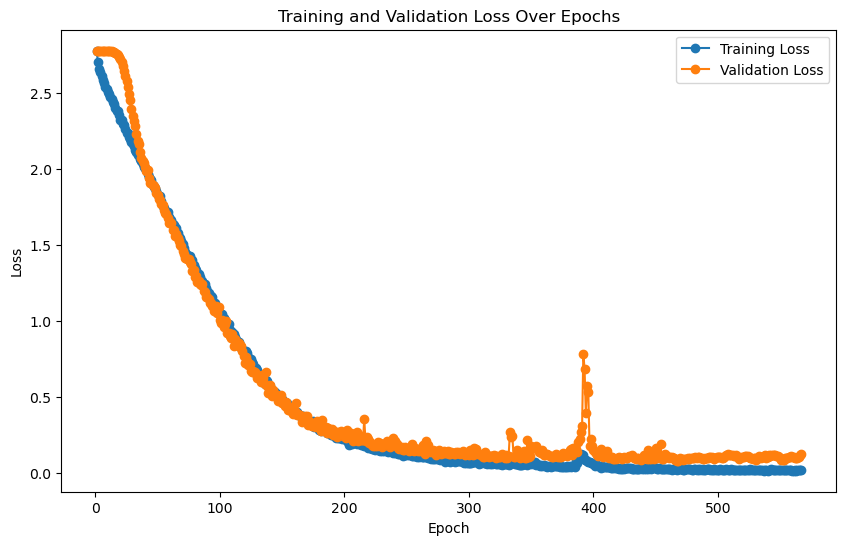

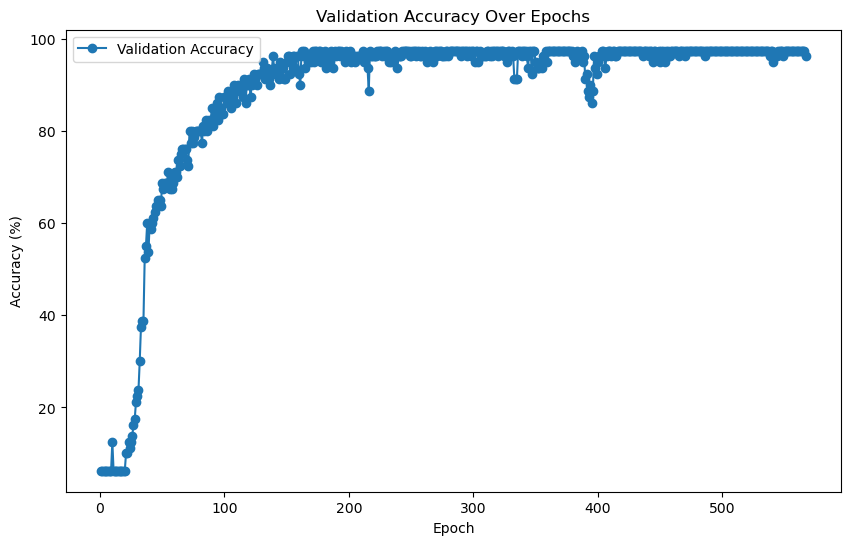


Evaluating on the test set...
    Test Batch [1/209], Loss: 0.1061



Final Test Loss: 0.3732, Test Accuracy: 92.41%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/209 for test dataset.
  Processed batch 20/209 for test dataset.
  Processed batch 30/209 for test dataset.


  Processed batch 40/209 for test dataset.
  Processed batch 50/209 for test dataset.
  Processed batch 60/209 for test dataset.
  Processed batch 70/209 for test dataset.
  Processed batch 80/209 for test dataset.


  Processed batch 90/209 for test dataset.
  Processed batch 100/209 for test dataset.
  Processed batch 110/209 for test dataset.
  Processed batch 120/209 for test dataset.


  Processed batch 130/209 for test dataset.
  Processed batch 140/209 for test dataset.
  Processed batch 150/209 for test dataset.
  Processed batch 160/209 for test dataset.
  Processed batch 170/209 for test dataset.


  Processed batch 180/209 for test dataset.
  Processed batch 190/209 for test dataset.
  Processed batch 200/209 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 640 samples with 64 features each
LOG: Labels shape: (640,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 53409 samples with 64 features each
LOG: Labels shape: (53409,)

LOG: Training features shape: (640, 64), Training labels shape: (640,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (53409, 64), Test labels shape: (53409,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 88.75%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.83      1.00      0.91         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.67      0.80      0.73         5
           8       1.00      0.


Test Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      1964
           1       0.97      0.98      0.98      3681
           2       0.93      0.95      0.94      1931
           3       0.99      0.99      0.99      1349
           4       0.98      0.99      0.98      2633
           5       1.00      0.98      0.99      3914
           6       0.97      0.98      0.97      3534
           7       0.76      0.75      0.76     11226
           8       0.99      0.93      0.96      6158
           9       0.81      0.78      0.80      3233
          10       0.51      0.95      0.67      1023
          11       0.89      0.99      0.93      1882
          12       0.90      0.98      0.94       871
          13       0.89      0.95      0.92      1025
          14       0.66      0.61      0.63      7223
          15       0.93      0.92      0.92      1762

    accuracy                           0.86     53

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 640 samples with 64 features each
LOG: Labels shape: (640,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53409 samples with 64 features each
LOG: Labels shape: (53409,)
Train reps shape: (640, 64)
Train labels shape: (640,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (53409, 64)
Test labels shape: (53409,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8110  |  Val Loss: 2.6445
Validation loss improved from inf to 2.6445.
[Epoch 2/1000] Train Loss: 2.5760  |  Val Loss: 2.4858
Validation loss improved from 2.6445 to 2.4858.
[Epoch 3/1000] Train Loss: 2.4062  |  Val Loss: 2.3039
Validation loss improved from 2.4858 to 2.3039.
[Epoch 4/1000] Train Loss: 2.2172  |  Val Loss: 2.1014
Validation loss improved from 2.3039 to 2.1014.


[Epoch 5/1000] Train Loss: 2.0101  |  Val Loss: 1.8766
Validation loss improved from 2.1014 to 1.8766.


[Epoch 6/1000] Train Loss: 1.7745  |  Val Loss: 1.6468
Validation loss improved from 1.8766 to 1.6468.
[Epoch 7/1000] Train Loss: 1.5461  |  Val Loss: 1.4302
Validation loss improved from 1.6468 to 1.4302.
[Epoch 8/1000] Train Loss: 1.3395  |  Val Loss: 1.2460
Validation loss improved from 1.4302 to 1.2460.
[Epoch 9/1000] Train Loss: 1.1423  |  Val Loss: 1.0746
Validation loss improved from 1.2460 to 1.0746.
[Epoch 10/1000] Train Loss: 0.9840  |  Val Loss: 0.9402
Validation loss improved from 1.0746 to 0.9402.


[Epoch 11/1000] Train Loss: 0.8531  |  Val Loss: 0.8350
Validation loss improved from 0.9402 to 0.8350.
[Epoch 12/1000] Train Loss: 0.7555  |  Val Loss: 0.7464
Validation loss improved from 0.8350 to 0.7464.
[Epoch 13/1000] Train Loss: 0.6698  |  Val Loss: 0.6810
Validation loss improved from 0.7464 to 0.6810.
[Epoch 14/1000] Train Loss: 0.6139  |  Val Loss: 0.6326
Validation loss improved from 0.6810 to 0.6326.
[Epoch 15/1000] Train Loss: 0.5792  |  Val Loss: 0.5900
Validation loss improved from 0.6326 to 0.5900.


[Epoch 16/1000] Train Loss: 0.5280  |  Val Loss: 0.5295
Validation loss improved from 0.5900 to 0.5295.
[Epoch 17/1000] Train Loss: 0.4725  |  Val Loss: 0.4978
Validation loss improved from 0.5295 to 0.4978.
[Epoch 18/1000] Train Loss: 0.4464  |  Val Loss: 0.4804
Validation loss improved from 0.4978 to 0.4804.
[Epoch 19/1000] Train Loss: 0.4252  |  Val Loss: 0.4537
Validation loss improved from 0.4804 to 0.4537.
[Epoch 20/1000] Train Loss: 0.3987  |  Val Loss: 0.4354
Validation loss improved from 0.4537 to 0.4354.


[Epoch 21/1000] Train Loss: 0.3850  |  Val Loss: 0.4213
Validation loss improved from 0.4354 to 0.4213.
[Epoch 22/1000] Train Loss: 0.3704  |  Val Loss: 0.4272
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 23/1000] Train Loss: 0.3640  |  Val Loss: 0.4037
Validation loss improved from 0.4213 to 0.4037.
[Epoch 24/1000] Train Loss: 0.3414  |  Val Loss: 0.4024
Validation loss improved from 0.4037 to 0.4024.
[Epoch 25/1000] Train Loss: 0.3247  |  Val Loss: 0.3841
Validation loss improved from 0.4024 to 0.3841.


[Epoch 26/1000] Train Loss: 0.3110  |  Val Loss: 0.3705
Validation loss improved from 0.3841 to 0.3705.
[Epoch 27/1000] Train Loss: 0.3033  |  Val Loss: 0.3730
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 28/1000] Train Loss: 0.2895  |  Val Loss: 0.3600
Validation loss improved from 0.3705 to 0.3600.
[Epoch 29/1000] Train Loss: 0.2804  |  Val Loss: 0.3484
Validation loss improved from 0.3600 to 0.3484.
[Epoch 30/1000] Train Loss: 0.2673  |  Val Loss: 0.3582
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 31/1000] Train Loss: 0.2677  |  Val Loss: 0.3898
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 32/1000] Train Loss: 0.2592  |  Val Loss: 0.3409
Validation loss improved from 0.3484 to 0.3409.
[Epoch 33/1000] Train Loss: 0.2571  |  Val Loss: 0.3618
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 34/1000] Train Loss: 0.2634  |  Val Loss: 0.3340
Validation loss improved from 0.3409 to 0.3340.
[Epoch 35/1000] Train Loss: 0.2466  |  Val Loss: 0.3426
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 36/1000] Train Loss: 0.2620  |  Val Loss: 0.3731
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 37/1000] Train Loss: 0.2398  |  Val Loss: 0.3607
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 38/1000] Train Loss: 0.2260  |  Val Loss: 0.3275
Validation loss improved from 0.3340 to 0.3275.
[Epoch 39/1000] Train Loss: 0.2126  |  Val Loss: 0.3414
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 40/1000] Train Loss: 0.2125  |  Val Loss: 0.3385
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 41/1000] Train Loss: 0.2132  |  Val Loss: 0.3317
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 42/1000] Train Loss: 0.2063  |  Val Loss: 0.3299
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 43/1000] Train Loss: 0.1975  |  Val Loss: 0.3325
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 44/1000] Train Loss: 0.2014  |  Val Loss: 0.3220
Validation loss improved from 0.3275 to 0.3220.
[Epoch 45/1000] Train Loss: 0.2025  |  Val Loss: 0.3153
Validation loss improved from 0.3220 to 0.3153.
[Epoch 46/1000] Train Loss: 0.2011  |  Val Loss: 0.3401
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 47/1000] Train Loss: 0.2000  |  Val Loss: 0.3797
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 48/1000] Train Loss: 0.1819  |  Val Loss: 0.3221
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 49/1000] Train Loss: 0.1840  |  Val Loss: 0.3023
Validation loss improved from 0.3153 to 0.3023.
[Epoch 50/1000] Train Loss: 0.1716  |  Val Loss: 0.3262
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 51/1000] Train Loss: 0.1767  |  Val Loss: 0.3188
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 52/1000] Train Loss: 0.1792  |  Val Loss: 0.3196
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 53/1000] Train Loss: 0.1715  |  Val Loss: 0.3327
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 54/1000] Train Loss: 0.1668  |  Val Loss: 0.3351
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 55/1000] Train Loss: 0.1654  |  Val Loss: 0.2950
Validation loss improved from 0.3023 to 0.2950.
[Epoch 56/1000] Train Loss: 0.1569  |  Val Loss: 0.3093
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 57/1000] Train Loss: 0.1608  |  Val Loss: 0.2994
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 58/1000] Train Loss: 0.1610  |  Val Loss: 0.2921
Validation loss improved from 0.2950 to 0.2921.


[Epoch 59/1000] Train Loss: 0.1536  |  Val Loss: 0.3686
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 60/1000] Train Loss: 0.1605  |  Val Loss: 0.3397
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 61/1000] Train Loss: 0.1638  |  Val Loss: 0.3226
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 62/1000] Train Loss: 0.1544  |  Val Loss: 0.3470
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 63/1000] Train Loss: 0.1498  |  Val Loss: 0.2917
Validation loss improved from 0.2921 to 0.2917.


[Epoch 64/1000] Train Loss: 0.1532  |  Val Loss: 0.3398
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 65/1000] Train Loss: 0.1552  |  Val Loss: 0.3153
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 66/1000] Train Loss: 0.1626  |  Val Loss: 0.3200
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 67/1000] Train Loss: 0.1783  |  Val Loss: 0.3300
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 68/1000] Train Loss: 0.1595  |  Val Loss: 0.3598
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 69/1000] Train Loss: 0.1408  |  Val Loss: 0.3642
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 70/1000] Train Loss: 0.1351  |  Val Loss: 0.3242
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 71/1000] Train Loss: 0.1443  |  Val Loss: 0.3173
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 72/1000] Train Loss: 0.1316  |  Val Loss: 0.3062
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 73/1000] Train Loss: 0.1377  |  Val Loss: 0.3742
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 74/1000] Train Loss: 0.1333  |  Val Loss: 0.3134
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 75/1000] Train Loss: 0.1339  |  Val Loss: 0.3131
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 76/1000] Train Loss: 0.1344  |  Val Loss: 0.4097
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 77/1000] Train Loss: 0.1369  |  Val Loss: 0.3114
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 78/1000] Train Loss: 0.1275  |  Val Loss: 0.3573
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 79/1000] Train Loss: 0.1301  |  Val Loss: 0.3020
!! Validation loss did NOT improve !! Patience: 16/100


[Epoch 80/1000] Train Loss: 0.1366  |  Val Loss: 0.3224
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 81/1000] Train Loss: 0.1474  |  Val Loss: 0.3607
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 82/1000] Train Loss: 0.1258  |  Val Loss: 0.3087
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 83/1000] Train Loss: 0.1183  |  Val Loss: 0.3855
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 84/1000] Train Loss: 0.1274  |  Val Loss: 0.3628
!! Validation loss did NOT improve !! Patience: 21/100


[Epoch 85/1000] Train Loss: 0.1345  |  Val Loss: 0.3375
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 86/1000] Train Loss: 0.1180  |  Val Loss: 0.3362
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 87/1000] Train Loss: 0.1116  |  Val Loss: 0.3044
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 88/1000] Train Loss: 0.1143  |  Val Loss: 0.3220
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 89/1000] Train Loss: 0.1081  |  Val Loss: 0.2957
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 90/1000] Train Loss: 0.1056  |  Val Loss: 0.3502
!! Validation loss did NOT improve !! Patience: 27/100


[Epoch 91/1000] Train Loss: 0.1201  |  Val Loss: 0.3221
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 92/1000] Train Loss: 0.1260  |  Val Loss: 0.3255
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 93/1000] Train Loss: 0.1346  |  Val Loss: 0.3634
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 94/1000] Train Loss: 0.1226  |  Val Loss: 0.2998
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 95/1000] Train Loss: 0.1056  |  Val Loss: 0.3061
!! Validation loss did NOT improve !! Patience: 32/100


[Epoch 96/1000] Train Loss: 0.1127  |  Val Loss: 0.3197
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 97/1000] Train Loss: 0.1153  |  Val Loss: 0.3382
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 98/1000] Train Loss: 0.1215  |  Val Loss: 0.3407
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 99/1000] Train Loss: 0.1149  |  Val Loss: 0.4051
!! Validation loss did NOT improve !! Patience: 36/100


[Epoch 100/1000] Train Loss: 0.1097  |  Val Loss: 0.3638
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 101/1000] Train Loss: 0.1175  |  Val Loss: 0.3063
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 102/1000] Train Loss: 0.1096  |  Val Loss: 0.3415
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 103/1000] Train Loss: 0.1077  |  Val Loss: 0.3196
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 104/1000] Train Loss: 0.1032  |  Val Loss: 0.3304
!! Validation loss did NOT improve !! Patience: 41/100


[Epoch 105/1000] Train Loss: 0.1018  |  Val Loss: 0.3382
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 106/1000] Train Loss: 0.0977  |  Val Loss: 0.3388
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 107/1000] Train Loss: 0.1054  |  Val Loss: 0.3489
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 108/1000] Train Loss: 0.1140  |  Val Loss: 0.2981
!! Validation loss did NOT improve !! Patience: 45/100


[Epoch 109/1000] Train Loss: 0.1247  |  Val Loss: 0.4982
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 110/1000] Train Loss: 0.1207  |  Val Loss: 0.2799
Validation loss improved from 0.2917 to 0.2799.
[Epoch 111/1000] Train Loss: 0.0951  |  Val Loss: 0.3337
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 112/1000] Train Loss: 0.0917  |  Val Loss: 0.3149
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 113/1000] Train Loss: 0.0934  |  Val Loss: 0.3702
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 114/1000] Train Loss: 0.0897  |  Val Loss: 0.3123
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 115/1000] Train Loss: 0.0919  |  Val Loss: 0.3565
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 116/1000] Train Loss: 0.0893  |  Val Loss: 0.3406
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 117/1000] Train Loss: 0.0864  |  Val Loss: 0.3525
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 118/1000] Train Loss: 0.0932  |  Val Loss: 0.2982
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 119/1000] Train Loss: 0.0900  |  Val Loss: 0.3361
!! Validation loss did NOT improve !! Patience: 9/100


[Epoch 120/1000] Train Loss: 0.0901  |  Val Loss: 0.3118
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 121/1000] Train Loss: 0.0870  |  Val Loss: 0.3359
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 122/1000] Train Loss: 0.0916  |  Val Loss: 0.4265
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 123/1000] Train Loss: 0.0970  |  Val Loss: 0.3279
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 124/1000] Train Loss: 0.0878  |  Val Loss: 0.3178
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 125/1000] Train Loss: 0.1041  |  Val Loss: 0.3773
!! Validation loss did NOT improve !! Patience: 15/100


[Epoch 126/1000] Train Loss: 0.0994  |  Val Loss: 0.3856
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 127/1000] Train Loss: 0.0954  |  Val Loss: 0.3937
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 128/1000] Train Loss: 0.0805  |  Val Loss: 0.3360
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 129/1000] Train Loss: 0.0758  |  Val Loss: 0.3736
!! Validation loss did NOT improve !! Patience: 19/100


[Epoch 130/1000] Train Loss: 0.0778  |  Val Loss: 0.3219
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 131/1000] Train Loss: 0.0777  |  Val Loss: 0.4044
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 132/1000] Train Loss: 0.0975  |  Val Loss: 0.3926
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 133/1000] Train Loss: 0.0818  |  Val Loss: 0.3566
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 134/1000] Train Loss: 0.0826  |  Val Loss: 0.3673
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 135/1000] Train Loss: 0.1047  |  Val Loss: 0.3919
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 136/1000] Train Loss: 0.1045  |  Val Loss: 0.3890
!! Validation loss did NOT improve !! Patience: 26/100


[Epoch 137/1000] Train Loss: 0.0976  |  Val Loss: 0.3775
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 138/1000] Train Loss: 0.0893  |  Val Loss: 0.4073
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 139/1000] Train Loss: 0.0752  |  Val Loss: 0.3560
!! Validation loss did NOT improve !! Patience: 29/100


[Epoch 140/1000] Train Loss: 0.0747  |  Val Loss: 0.4016
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 141/1000] Train Loss: 0.0727  |  Val Loss: 0.3198
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 142/1000] Train Loss: 0.0891  |  Val Loss: 0.4142
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 143/1000] Train Loss: 0.0987  |  Val Loss: 0.3903
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 144/1000] Train Loss: 0.0819  |  Val Loss: 0.3624
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 145/1000] Train Loss: 0.0674  |  Val Loss: 0.3699
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 146/1000] Train Loss: 0.0749  |  Val Loss: 0.3419
!! Validation loss did NOT improve !! Patience: 36/100


[Epoch 147/1000] Train Loss: 0.0724  |  Val Loss: 0.3820
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 148/1000] Train Loss: 0.0724  |  Val Loss: 0.3792
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 149/1000] Train Loss: 0.0686  |  Val Loss: 0.3593
!! Validation loss did NOT improve !! Patience: 39/100


[Epoch 150/1000] Train Loss: 0.0676  |  Val Loss: 0.3586
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 151/1000] Train Loss: 0.0654  |  Val Loss: 0.3578
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 152/1000] Train Loss: 0.0638  |  Val Loss: 0.3895
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 153/1000] Train Loss: 0.0679  |  Val Loss: 0.4037
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 154/1000] Train Loss: 0.0732  |  Val Loss: 0.3529
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 155/1000] Train Loss: 0.0661  |  Val Loss: 0.3553
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 156/1000] Train Loss: 0.0698  |  Val Loss: 0.3973
!! Validation loss did NOT improve !! Patience: 46/100


[Epoch 157/1000] Train Loss: 0.0638  |  Val Loss: 0.3769
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 158/1000] Train Loss: 0.0679  |  Val Loss: 0.3570
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 159/1000] Train Loss: 0.0628  |  Val Loss: 0.3664
!! Validation loss did NOT improve !! Patience: 49/100


[Epoch 160/1000] Train Loss: 0.0660  |  Val Loss: 0.4103
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 161/1000] Train Loss: 0.0629  |  Val Loss: 0.3666
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 162/1000] Train Loss: 0.0645  |  Val Loss: 0.3780
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 163/1000] Train Loss: 0.0588  |  Val Loss: 0.4022
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 164/1000] Train Loss: 0.0588  |  Val Loss: 0.3906
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 165/1000] Train Loss: 0.0598  |  Val Loss: 0.3982
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 166/1000] Train Loss: 0.0674  |  Val Loss: 0.3704
!! Validation loss did NOT improve !! Patience: 56/100


[Epoch 167/1000] Train Loss: 0.0637  |  Val Loss: 0.3836
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 168/1000] Train Loss: 0.0625  |  Val Loss: 0.3977
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 169/1000] Train Loss: 0.0634  |  Val Loss: 0.3388
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 170/1000] Train Loss: 0.0711  |  Val Loss: 0.4471
!! Validation loss did NOT improve !! Patience: 60/100


[Epoch 171/1000] Train Loss: 0.0545  |  Val Loss: 0.3936
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 172/1000] Train Loss: 0.0583  |  Val Loss: 0.3824
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 173/1000] Train Loss: 0.0576  |  Val Loss: 0.4199
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 174/1000] Train Loss: 0.0509  |  Val Loss: 0.3785
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 175/1000] Train Loss: 0.0601  |  Val Loss: 0.4034
!! Validation loss did NOT improve !! Patience: 65/100


[Epoch 176/1000] Train Loss: 0.0572  |  Val Loss: 0.3670
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 177/1000] Train Loss: 0.0666  |  Val Loss: 0.4740
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 178/1000] Train Loss: 0.0572  |  Val Loss: 0.3758
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 179/1000] Train Loss: 0.0635  |  Val Loss: 0.4306
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 180/1000] Train Loss: 0.0598  |  Val Loss: 0.3790
!! Validation loss did NOT improve !! Patience: 70/100


[Epoch 181/1000] Train Loss: 0.0581  |  Val Loss: 0.4131
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 182/1000] Train Loss: 0.0504  |  Val Loss: 0.4305
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 183/1000] Train Loss: 0.0636  |  Val Loss: 0.4188
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 184/1000] Train Loss: 0.0712  |  Val Loss: 0.4464
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 185/1000] Train Loss: 0.0612  |  Val Loss: 0.4292
!! Validation loss did NOT improve !! Patience: 75/100


[Epoch 186/1000] Train Loss: 0.0535  |  Val Loss: 0.4556
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 187/1000] Train Loss: 0.0630  |  Val Loss: 0.4273
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 188/1000] Train Loss: 0.0601  |  Val Loss: 0.4307
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 189/1000] Train Loss: 0.0711  |  Val Loss: 0.4288
!! Validation loss did NOT improve !! Patience: 79/100


[Epoch 190/1000] Train Loss: 0.0554  |  Val Loss: 0.4336
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 191/1000] Train Loss: 0.0592  |  Val Loss: 0.4257
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 192/1000] Train Loss: 0.0517  |  Val Loss: 0.4259
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 193/1000] Train Loss: 0.0465  |  Val Loss: 0.4094
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 194/1000] Train Loss: 0.0494  |  Val Loss: 0.5076
!! Validation loss did NOT improve !! Patience: 84/100


[Epoch 195/1000] Train Loss: 0.0575  |  Val Loss: 0.4033
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 196/1000] Train Loss: 0.0488  |  Val Loss: 0.4056
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 197/1000] Train Loss: 0.0554  |  Val Loss: 0.4799
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 198/1000] Train Loss: 0.0476  |  Val Loss: 0.4553
!! Validation loss did NOT improve !! Patience: 88/100


[Epoch 199/1000] Train Loss: 0.0478  |  Val Loss: 0.4748
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 200/1000] Train Loss: 0.0484  |  Val Loss: 0.4570
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 201/1000] Train Loss: 0.0434  |  Val Loss: 0.4380
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 202/1000] Train Loss: 0.0404  |  Val Loss: 0.4601
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 203/1000] Train Loss: 0.0408  |  Val Loss: 0.4668
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 204/1000] Train Loss: 0.0447  |  Val Loss: 0.4777
!! Validation loss did NOT improve !! Patience: 94/100


[Epoch 205/1000] Train Loss: 0.0440  |  Val Loss: 0.4528
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 206/1000] Train Loss: 0.0510  |  Val Loss: 0.4560
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 207/1000] Train Loss: 0.0508  |  Val Loss: 0.4637
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 208/1000] Train Loss: 0.0486  |  Val Loss: 0.4291
!! Validation loss did NOT improve !! Patience: 98/100


[Epoch 209/1000] Train Loss: 0.0460  |  Val Loss: 0.4567
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 210/1000] Train Loss: 0.0461  |  Val Loss: 0.5061
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 210 !!
No improvement for 100 epochs.


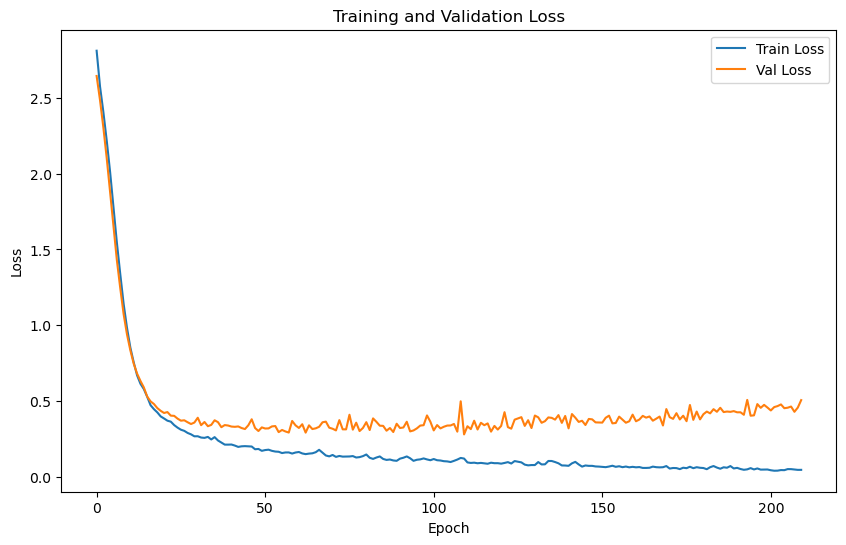

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.5402 | Test Accuracy: 87.58%


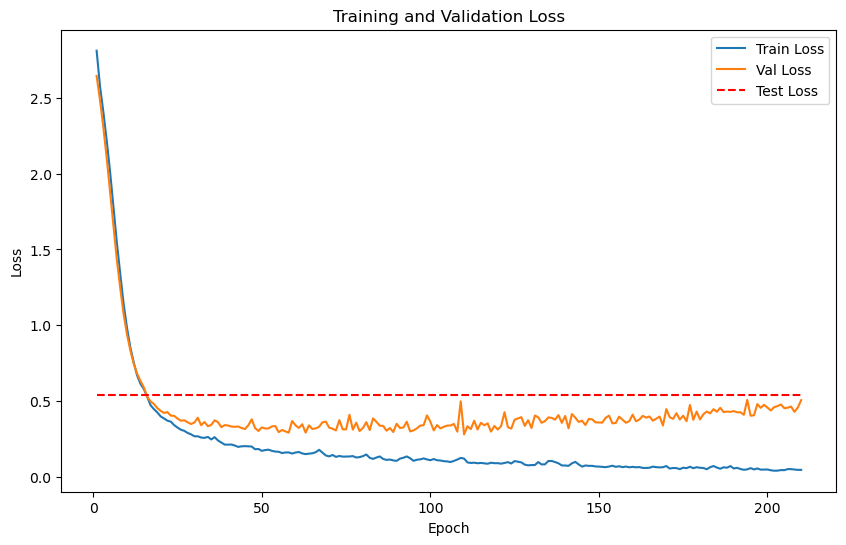

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 640 samples with 64 features each
LOG: Labels shape: (640,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53409 samples with 64 features each
LOG: Labels shape: (53409,)


Train embeddings shape: (640, 64), 
Train labels shape: (640,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53409, 64), 
Test labels shape: (53409,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/2], Train Loss: 8.4082
    Batch [2/2], Train Loss: 8.5323
Epoch [1/2000], Avg Train Loss: 8.4702
Epoch [1/2000], Avg Val Loss: 3.6143
Validation loss improved from inf to 3.6143. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 8.4740
    Batch [2/2], Train Loss: 8.2541
Epoch [2/2000], Avg Train Loss: 8.3640
Epoch [2/2000], Avg Val Loss: 3.5639
Validation loss improved from 3.6143 to 3.5639. Saving model...

LOG: Epoch [3/2000] - Training


    Batch [1/2], Train Loss: 8.3827
    Batch [2/2], Train Loss: 8.1254
Epoch [3/2000], Avg Train Loss: 8.2541
Epoch [3/2000], Avg Val Loss: 3.5161
Validation loss improved from 3.5639 to 3.5161. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 7.9621
    Batch [2/2], Train Loss: 8.0672
Epoch [4/2000], Avg Train Loss: 8.0146
Epoch [4/2000], Avg Val Loss: 3.4704
Validation loss improved from 3.5161 to 3.4704. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 7.9373
    Batch [2/2], Train Loss: 7.9565
Epoch [5/2000], Avg Train Loss: 7.9469
Epoch [5/2000], Avg Val Loss: 3.4269
Validation loss improved from 3.4704 to 3.4269. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 7.8666
    Batch [2/2], Train Loss: 7.5604
Epoch [6/2000], Avg Train Loss: 7.7135
Epoch [6/2000], Avg Val Loss: 3.3863
Validation loss improved from 3.4269 to 3.3863. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/2], Train L

    Batch [1/2], Train Loss: 7.3449
    Batch [2/2], Train Loss: 7.0976
Epoch [11/2000], Avg Train Loss: 7.2212
Epoch [11/2000], Avg Val Loss: 3.2128
Validation loss improved from 3.2436 to 3.2128. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 7.1222
    Batch [2/2], Train Loss: 7.1385
Epoch [12/2000], Avg Train Loss: 7.1304
Epoch [12/2000], Avg Val Loss: 3.1838
Validation loss improved from 3.2128 to 3.1838. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 6.9477
    Batch [2/2], Train Loss: 6.8324
Epoch [13/2000], Avg Train Loss: 6.8900
Epoch [13/2000], Avg Val Loss: 3.1566
Validation loss improved from 3.1838 to 3.1566. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 6.8188
    Batch [2/2], Train Loss: 6.7397
Epoch [14/2000], Avg Train Loss: 6.7793
Epoch [14/2000], Avg Val Loss: 3.1313
Validation loss improved from 3.1566 to 3.1313. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 6.0223
    Batch [2/2], Train Loss: 6.0688
Epoch [23/2000], Avg Train Loss: 6.0456
Epoch [23/2000], Avg Val Loss: 2.9716
Validation loss improved from 2.9843 to 2.9716. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 5.9826
    Batch [2/2], Train Loss: 5.9209
Epoch [24/2000], Avg Train Loss: 5.9517
Epoch [24/2000], Avg Val Loss: 2.9600
Validation loss improved from 2.9716 to 2.9600. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 5.9722
    Batch [2/2], Train Loss: 5.9931
Epoch [25/2000], Avg Train Loss: 5.9827
Epoch [25/2000], Avg Val Loss: 2.9494
Validation loss improved from 2.9600 to 2.9494. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 5.8313
    Batch [2/2], Train Loss: 5.8485
Epoch [26/2000], Avg Train Loss: 5.8399
Epoch [26/2000], Avg Val Loss: 2.9397
Validation loss improved from 2.9494 to 2.9397. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 5.6020
Epoch [32/2000], Avg Train Loss: 5.5536
Epoch [32/2000], Avg Val Loss: 2.8981
Validation loss improved from 2.9035 to 2.8981. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 5.5080
    Batch [2/2], Train Loss: 5.5287
Epoch [33/2000], Avg Train Loss: 5.5184
Epoch [33/2000], Avg Val Loss: 2.8933
Validation loss improved from 2.8981 to 2.8933. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 5.4593
    Batch [2/2], Train Loss: 5.4674
Epoch [34/2000], Avg Train Loss: 5.4634
Epoch [34/2000], Avg Val Loss: 2.8888
Validation loss improved from 2.8933 to 2.8888. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 5.4254
    Batch [2/2], Train Loss: 5.3658
Epoch [35/2000], Avg Train Loss: 5.3956
Epoch [35/2000], Avg Val Loss: 2.8847
Validation loss improved from 2.8888 to 2.8847. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 5.3306
    Batch [2

    Batch [1/2], Train Loss: 5.1394
    Batch [2/2], Train Loss: 5.1225
Epoch [45/2000], Avg Train Loss: 5.1310
Epoch [45/2000], Avg Val Loss: 2.8551
Validation loss improved from 2.8576 to 2.8551. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/2], Train Loss: 5.1421
    Batch [2/2], Train Loss: 5.1514
Epoch [46/2000], Avg Train Loss: 5.1467
Epoch [46/2000], Avg Val Loss: 2.8527
Validation loss improved from 2.8551 to 2.8527. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 5.0858
    Batch [2/2], Train Loss: 5.0885
Epoch [47/2000], Avg Train Loss: 5.0871
Epoch [47/2000], Avg Val Loss: 2.8504
Validation loss improved from 2.8527 to 2.8504. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 4.9757
    Batch [2/2], Train Loss: 5.0131
Epoch [48/2000], Avg Train Loss: 4.9944
Epoch [48/2000], Avg Val Loss: 2.8480
Validation loss improved from 2.8504 to 2.8480. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 4.9736
Epoch [53/2000], Avg Train Loss: 4.9882
Epoch [53/2000], Avg Val Loss: 2.8362
Validation loss improved from 2.8386 to 2.8362. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 4.9587
    Batch [2/2], Train Loss: 4.9997
Epoch [54/2000], Avg Train Loss: 4.9792
Epoch [54/2000], Avg Val Loss: 2.8339
Validation loss improved from 2.8362 to 2.8339. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 4.9223
    Batch [2/2], Train Loss: 4.9144
Epoch [55/2000], Avg Train Loss: 4.9183
Epoch [55/2000], Avg Val Loss: 2.8315
Validation loss improved from 2.8339 to 2.8315. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 4.9707
    Batch [2/2], Train Loss: 4.9214
Epoch [56/2000], Avg Train Loss: 4.9460
Epoch [56/2000], Avg Val Loss: 2.8292
Validation loss improved from 2.8315 to 2.8292. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 4.9474
    Batch [2

    Batch [2/2], Train Loss: 4.7751
Epoch [65/2000], Avg Train Loss: 4.7943
Epoch [65/2000], Avg Val Loss: 2.8074
Validation loss improved from 2.8100 to 2.8074. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 4.8314
    Batch [2/2], Train Loss: 4.8037
Epoch [66/2000], Avg Train Loss: 4.8175
Epoch [66/2000], Avg Val Loss: 2.8048
Validation loss improved from 2.8074 to 2.8048. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/2], Train Loss: 4.7978
    Batch [2/2], Train Loss: 4.7764
Epoch [67/2000], Avg Train Loss: 4.7871
Epoch [67/2000], Avg Val Loss: 2.8022
Validation loss improved from 2.8048 to 2.8022. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1/2], Train Loss: 4.8162
    Batch [2/2], Train Loss: 4.8234
Epoch [68/2000], Avg Train Loss: 4.8198
Epoch [68/2000], Avg Val Loss: 2.7995
Validation loss improved from 2.8022 to 2.7995. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 4.8191
    Batch [2

Epoch [74/2000], Avg Val Loss: 2.7831
Validation loss improved from 2.7859 to 2.7831. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 4.7160
    Batch [2/2], Train Loss: 4.6987
Epoch [75/2000], Avg Train Loss: 4.7073
Epoch [75/2000], Avg Val Loss: 2.7803
Validation loss improved from 2.7831 to 2.7803. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 4.7891
    Batch [2/2], Train Loss: 4.7413
Epoch [76/2000], Avg Train Loss: 4.7652
Epoch [76/2000], Avg Val Loss: 2.7775
Validation loss improved from 2.7803 to 2.7775. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 4.7248
    Batch [2/2], Train Loss: 4.6524
Epoch [77/2000], Avg Train Loss: 4.6886
Epoch [77/2000], Avg Val Loss: 2.7748
Validation loss improved from 2.7775 to 2.7748. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/2], Train Loss: 4.6884
    Batch [2/2], Train Loss: 4.7434
Epoch [78/2000], Avg Train Loss: 4.7159
Epoch [78/20

    Batch [1/2], Train Loss: 4.6594
    Batch [2/2], Train Loss: 4.6266
Epoch [87/2000], Avg Train Loss: 4.6430
Epoch [87/2000], Avg Val Loss: 2.7475
Validation loss improved from 2.7502 to 2.7475. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/2], Train Loss: 4.6705
    Batch [2/2], Train Loss: 4.7256
Epoch [88/2000], Avg Train Loss: 4.6980
Epoch [88/2000], Avg Val Loss: 2.7448
Validation loss improved from 2.7475 to 2.7448. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 4.6409
    Batch [2/2], Train Loss: 4.6739
Epoch [89/2000], Avg Train Loss: 4.6574
Epoch [89/2000], Avg Val Loss: 2.7421
Validation loss improved from 2.7448 to 2.7421. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 4.6137
    Batch [2/2], Train Loss: 4.6166
Epoch [90/2000], Avg Train Loss: 4.6151
Epoch [90/2000], Avg Val Loss: 2.7394
Validation loss improved from 2.7421 to 2.7394. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 4.5852
    Batch [2/2], Train Loss: 4.6390
Epoch [96/2000], Avg Train Loss: 4.6121
Epoch [96/2000], Avg Val Loss: 2.7229
Validation loss improved from 2.7257 to 2.7229. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 4.5789
    Batch [2/2], Train Loss: 4.6079
Epoch [97/2000], Avg Train Loss: 4.5934
Epoch [97/2000], Avg Val Loss: 2.7202
Validation loss improved from 2.7229 to 2.7202. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 4.5835
    Batch [2/2], Train Loss: 4.6171
Epoch [98/2000], Avg Train Loss: 4.6003
Epoch [98/2000], Avg Val Loss: 2.7175
Validation loss improved from 2.7202 to 2.7175. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/2], Train Loss: 4.6075
    Batch [2/2], Train Loss: 4.5184
Epoch [99/2000], Avg Train Loss: 4.5629
Epoch [99/2000], Avg Val Loss: 2.7149
Validation loss improved from 2.7175 to 2.7149. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [

    Batch [1/2], Train Loss: 4.5520
    Batch [2/2], Train Loss: 4.5172
Epoch [109/2000], Avg Train Loss: 4.5346
Epoch [109/2000], Avg Val Loss: 2.6898
Validation loss improved from 2.6920 to 2.6898. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/2], Train Loss: 4.5058
    Batch [2/2], Train Loss: 4.4797
Epoch [110/2000], Avg Train Loss: 4.4928
Epoch [110/2000], Avg Val Loss: 2.6874
Validation loss improved from 2.6898 to 2.6874. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/2], Train Loss: 4.5264
    Batch [2/2], Train Loss: 4.5011
Epoch [111/2000], Avg Train Loss: 4.5138
Epoch [111/2000], Avg Val Loss: 2.6850
Validation loss improved from 2.6874 to 2.6850. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 4.5192
    Batch [2/2], Train Loss: 4.5304
Epoch [112/2000], Avg Train Loss: 4.5248
Epoch [112/2000], Avg Val Loss: 2.6826
Validation loss improved from 2.6850 to 2.6826. Saving model...

LOG: Epoch [113/2000] - Training


    Batch [1/2], Train Loss: 4.5221
    Batch [2/2], Train Loss: 4.4998
Epoch [119/2000], Avg Train Loss: 4.5110
Epoch [119/2000], Avg Val Loss: 2.6666
Validation loss improved from 2.6688 to 2.6666. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 4.4777
    Batch [2/2], Train Loss: 4.4490
Epoch [120/2000], Avg Train Loss: 4.4634
Epoch [120/2000], Avg Val Loss: 2.6645
Validation loss improved from 2.6666 to 2.6645. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 4.4353
    Batch [2/2], Train Loss: 4.4823
Epoch [121/2000], Avg Train Loss: 4.4588
Epoch [121/2000], Avg Val Loss: 2.6623
Validation loss improved from 2.6645 to 2.6623. Saving model...

LOG: Epoch [122/2000] - Training
    Batch [1/2], Train Loss: 4.4472
    Batch [2/2], Train Loss: 4.4771
Epoch [122/2000], Avg Train Loss: 4.4622
Epoch [122/2000], Avg Val Loss: 2.6601
Validation loss improved from 2.6623 to 2.6601. Saving model...

LOG: Epoch [123/2000] - Training


Epoch [130/2000], Avg Val Loss: 2.6434
Validation loss improved from 2.6454 to 2.6434. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/2], Train Loss: 4.4331
    Batch [2/2], Train Loss: 4.4428
Epoch [131/2000], Avg Train Loss: 4.4379
Epoch [131/2000], Avg Val Loss: 2.6414
Validation loss improved from 2.6434 to 2.6414. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 4.4015
    Batch [2/2], Train Loss: 4.4515
Epoch [132/2000], Avg Train Loss: 4.4265
Epoch [132/2000], Avg Val Loss: 2.6393
Validation loss improved from 2.6414 to 2.6393. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 4.4412
    Batch [2/2], Train Loss: 4.3419
Epoch [133/2000], Avg Train Loss: 4.3916
Epoch [133/2000], Avg Val Loss: 2.6373
Validation loss improved from 2.6393 to 2.6373. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 4.4017
    Batch [2/2], Train Loss: 4.4041
Epoch [134/2000], Avg Train Loss: 4.4029


    Batch [1/2], Train Loss: 4.3803
    Batch [2/2], Train Loss: 4.3891
Epoch [140/2000], Avg Train Loss: 4.3847
Epoch [140/2000], Avg Val Loss: 2.6233
Validation loss improved from 2.6253 to 2.6233. Saving model...

LOG: Epoch [141/2000] - Training
    Batch [1/2], Train Loss: 4.3430
    Batch [2/2], Train Loss: 4.4295
Epoch [141/2000], Avg Train Loss: 4.3863
Epoch [141/2000], Avg Val Loss: 2.6213
Validation loss improved from 2.6233 to 2.6213. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/2], Train Loss: 4.3633
    Batch [2/2], Train Loss: 4.3715
Epoch [142/2000], Avg Train Loss: 4.3674
Epoch [142/2000], Avg Val Loss: 2.6193
Validation loss improved from 2.6213 to 2.6193. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 4.3832
    Batch [2/2], Train Loss: 4.3829
Epoch [143/2000], Avg Train Loss: 4.3830
Epoch [143/2000], Avg Val Loss: 2.6173
Validation loss improved from 2.6193 to 2.6173. Saving model...

LOG: Epoch [144/2000] - Training


    Batch [1/2], Train Loss: 4.3286
    Batch [2/2], Train Loss: 4.3121
Epoch [154/2000], Avg Train Loss: 4.3203
Epoch [154/2000], Avg Val Loss: 2.5979
Validation loss improved from 2.5996 to 2.5979. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 4.3279
    Batch [2/2], Train Loss: 4.3500
Epoch [155/2000], Avg Train Loss: 4.3390
Epoch [155/2000], Avg Val Loss: 2.5962
Validation loss improved from 2.5979 to 2.5962. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 4.3693
    Batch [2/2], Train Loss: 4.2957
Epoch [156/2000], Avg Train Loss: 4.3325
Epoch [156/2000], Avg Val Loss: 2.5946
Validation loss improved from 2.5962 to 2.5946. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 4.3981
    Batch [2/2], Train Loss: 4.3519
Epoch [157/2000], Avg Train Loss: 4.3750
Epoch [157/2000], Avg Val Loss: 2.5930
Validation loss improved from 2.5946 to 2.5930. Saving model...

LOG: Epoch [158/2000] - Training


    Batch [2/2], Train Loss: 4.2727
Epoch [163/2000], Avg Train Loss: 4.2728
Epoch [163/2000], Avg Val Loss: 2.5832
Validation loss improved from 2.5849 to 2.5832. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 4.2902
    Batch [2/2], Train Loss: 4.3094
Epoch [164/2000], Avg Train Loss: 4.2998
Epoch [164/2000], Avg Val Loss: 2.5815
Validation loss improved from 2.5832 to 2.5815. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 4.3276
    Batch [2/2], Train Loss: 4.2775
Epoch [165/2000], Avg Train Loss: 4.3025
Epoch [165/2000], Avg Val Loss: 2.5798
Validation loss improved from 2.5815 to 2.5798. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 4.2545
    Batch [2/2], Train Loss: 4.2752
Epoch [166/2000], Avg Train Loss: 4.2648
Epoch [166/2000], Avg Val Loss: 2.5781
Validation loss improved from 2.5798 to 2.5781. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/2], Train Loss: 4.2895


    Batch [1/2], Train Loss: 4.2563
    Batch [2/2], Train Loss: 4.2814
Epoch [176/2000], Avg Train Loss: 4.2688
Epoch [176/2000], Avg Val Loss: 2.5623
Validation loss improved from 2.5637 to 2.5623. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/2], Train Loss: 4.2937
    Batch [2/2], Train Loss: 4.2684
Epoch [177/2000], Avg Train Loss: 4.2810
Epoch [177/2000], Avg Val Loss: 2.5608
Validation loss improved from 2.5623 to 2.5608. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 4.2634
    Batch [2/2], Train Loss: 4.2705
Epoch [178/2000], Avg Train Loss: 4.2670
Epoch [178/2000], Avg Val Loss: 2.5594
Validation loss improved from 2.5608 to 2.5594. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/2], Train Loss: 4.2569
    Batch [2/2], Train Loss: 4.3003
Epoch [179/2000], Avg Train Loss: 4.2786
Epoch [179/2000], Avg Val Loss: 2.5580
Validation loss improved from 2.5594 to 2.5580. Saving model...

LOG: Epoch [180/2000] - Training


    Batch [1/2], Train Loss: 4.2391
    Batch [2/2], Train Loss: 4.3034
Epoch [185/2000], Avg Train Loss: 4.2712
Epoch [185/2000], Avg Val Loss: 2.5503
Validation loss improved from 2.5516 to 2.5503. Saving model...

LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 4.2461
    Batch [2/2], Train Loss: 4.2238
Epoch [186/2000], Avg Train Loss: 4.2350
Epoch [186/2000], Avg Val Loss: 2.5490
Validation loss improved from 2.5503 to 2.5490. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/2], Train Loss: 4.2762
    Batch [2/2], Train Loss: 4.2150
Epoch [187/2000], Avg Train Loss: 4.2456
Epoch [187/2000], Avg Val Loss: 2.5478
Validation loss improved from 2.5490 to 2.5478. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 4.2935
    Batch [2/2], Train Loss: 4.2213
Epoch [188/2000], Avg Train Loss: 4.2574
Epoch [188/2000], Avg Val Loss: 2.5466
Validation loss improved from 2.5478 to 2.5466. Saving model...

LOG: Epoch [189/2000] - Training


    Batch [2/2], Train Loss: 4.1754
Epoch [197/2000], Avg Train Loss: 4.2117
Epoch [197/2000], Avg Val Loss: 2.5367
Validation loss improved from 2.5379 to 2.5367. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/2], Train Loss: 4.2224
    Batch [2/2], Train Loss: 4.2140
Epoch [198/2000], Avg Train Loss: 4.2182
Epoch [198/2000], Avg Val Loss: 2.5354
Validation loss improved from 2.5367 to 2.5354. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/2], Train Loss: 4.2170
    Batch [2/2], Train Loss: 4.2157
Epoch [199/2000], Avg Train Loss: 4.2163
Epoch [199/2000], Avg Val Loss: 2.5340
Validation loss improved from 2.5354 to 2.5340. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/2], Train Loss: 4.2552
    Batch [2/2], Train Loss: 4.2182
Epoch [200/2000], Avg Train Loss: 4.2367
Epoch [200/2000], Avg Val Loss: 2.5325
Validation loss improved from 2.5340 to 2.5325. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/2], Train Loss: 4.1780


Epoch [206/2000], Avg Val Loss: 2.5249
Validation loss improved from 2.5260 to 2.5249. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 4.2103
    Batch [2/2], Train Loss: 4.1522
Epoch [207/2000], Avg Train Loss: 4.1813
Epoch [207/2000], Avg Val Loss: 2.5239
Validation loss improved from 2.5249 to 2.5239. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/2], Train Loss: 4.2328
    Batch [2/2], Train Loss: 4.2447
Epoch [208/2000], Avg Train Loss: 4.2388
Epoch [208/2000], Avg Val Loss: 2.5228
Validation loss improved from 2.5239 to 2.5228. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 4.2135
    Batch [2/2], Train Loss: 4.1739
Epoch [209/2000], Avg Train Loss: 4.1937
Epoch [209/2000], Avg Val Loss: 2.5216
Validation loss improved from 2.5228 to 2.5216. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/2], Train Loss: 4.1497
    Batch [2/2], Train Loss: 4.1711
Epoch [210/2000], Avg Train Loss: 4.1604


Epoch [219/2000], Avg Val Loss: 2.5089
Validation loss improved from 2.5103 to 2.5089. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 4.2064
    Batch [2/2], Train Loss: 4.1161
Epoch [220/2000], Avg Train Loss: 4.1613
Epoch [220/2000], Avg Val Loss: 2.5076
Validation loss improved from 2.5089 to 2.5076. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/2], Train Loss: 4.1420
    Batch [2/2], Train Loss: 4.1731
Epoch [221/2000], Avg Train Loss: 4.1575
Epoch [221/2000], Avg Val Loss: 2.5063
Validation loss improved from 2.5076 to 2.5063. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/2], Train Loss: 4.1411
    Batch [2/2], Train Loss: 4.1196
Epoch [222/2000], Avg Train Loss: 4.1304
Epoch [222/2000], Avg Val Loss: 2.5050
Validation loss improved from 2.5063 to 2.5050. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 4.1691
    Batch [2/2], Train Loss: 4.1137
Epoch [223/2000], Avg Train Loss: 4.1414


    Batch [1/2], Train Loss: 4.1433
    Batch [2/2], Train Loss: 4.1928
Epoch [227/2000], Avg Train Loss: 4.1680
Epoch [227/2000], Avg Val Loss: 2.4995
Validation loss improved from 2.5004 to 2.4995. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 4.2080
    Batch [2/2], Train Loss: 4.1497
Epoch [228/2000], Avg Train Loss: 4.1789
Epoch [228/2000], Avg Val Loss: 2.4988
Validation loss improved from 2.4995 to 2.4988. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/2], Train Loss: 4.1682
    Batch [2/2], Train Loss: 4.1772
Epoch [229/2000], Avg Train Loss: 4.1727
Epoch [229/2000], Avg Val Loss: 2.4979
Validation loss improved from 2.4988 to 2.4979. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 4.1499
    Batch [2/2], Train Loss: 4.1493
Epoch [230/2000], Avg Train Loss: 4.1496
Epoch [230/2000], Avg Val Loss: 2.4973
Validation loss improved from 2.4979 to 2.4973. Saving model...

LOG: Epoch [231/2000] - Training


    Batch [1/2], Train Loss: 4.1073
    Batch [2/2], Train Loss: 4.0855
Epoch [240/2000], Avg Train Loss: 4.0964
Epoch [240/2000], Avg Val Loss: 2.4901
Validation loss improved from 2.4910 to 2.4901. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/2], Train Loss: 4.1345
    Batch [2/2], Train Loss: 4.0808
Epoch [241/2000], Avg Train Loss: 4.1076
Epoch [241/2000], Avg Val Loss: 2.4891
Validation loss improved from 2.4901 to 2.4891. Saving model...

LOG: Epoch [242/2000] - Training
    Batch [1/2], Train Loss: 4.1113
    Batch [2/2], Train Loss: 4.0673
Epoch [242/2000], Avg Train Loss: 4.0893
Epoch [242/2000], Avg Val Loss: 2.4881
Validation loss improved from 2.4891 to 2.4881. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/2], Train Loss: 4.0994
    Batch [2/2], Train Loss: 4.0741
Epoch [243/2000], Avg Train Loss: 4.0867
Epoch [243/2000], Avg Val Loss: 2.4871
Validation loss improved from 2.4881 to 2.4871. Saving model...

LOG: Epoch [244/2000] - Training


    Batch [2/2], Train Loss: 4.0950
Epoch [248/2000], Avg Train Loss: 4.1106
Epoch [248/2000], Avg Val Loss: 2.4810
Validation loss improved from 2.4821 to 2.4810. Saving model...

LOG: Epoch [249/2000] - Training
    Batch [1/2], Train Loss: 4.1440
    Batch [2/2], Train Loss: 4.0812
Epoch [249/2000], Avg Train Loss: 4.1126
Epoch [249/2000], Avg Val Loss: 2.4799
Validation loss improved from 2.4810 to 2.4799. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/2], Train Loss: 4.1397
    Batch [2/2], Train Loss: 4.1397
Epoch [250/2000], Avg Train Loss: 4.1397
Epoch [250/2000], Avg Val Loss: 2.4788
Validation loss improved from 2.4799 to 2.4788. Saving model...

LOG: Epoch [251/2000] - Training
    Batch [1/2], Train Loss: 4.0739
    Batch [2/2], Train Loss: 4.1173
Epoch [251/2000], Avg Train Loss: 4.0956
Epoch [251/2000], Avg Val Loss: 2.4778
Validation loss improved from 2.4788 to 2.4778. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 4.0945


    Batch [2/2], Train Loss: 4.0991
Epoch [262/2000], Avg Train Loss: 4.0856
Epoch [262/2000], Avg Val Loss: 2.4690
Validation loss improved from 2.4698 to 2.4690. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/2], Train Loss: 4.0899
    Batch [2/2], Train Loss: 4.0895
Epoch [263/2000], Avg Train Loss: 4.0897
Epoch [263/2000], Avg Val Loss: 2.4682
Validation loss improved from 2.4690 to 2.4682. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/2], Train Loss: 4.0907
    Batch [2/2], Train Loss: 4.0898
Epoch [264/2000], Avg Train Loss: 4.0902
Epoch [264/2000], Avg Val Loss: 2.4675
Validation loss improved from 2.4682 to 2.4675. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 4.0453
    Batch [2/2], Train Loss: 4.0370
Epoch [265/2000], Avg Train Loss: 4.0412
Epoch [265/2000], Avg Val Loss: 2.4669
Validation loss improved from 2.4675 to 2.4669. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/2], Train Loss: 4.0902


Epoch [268/2000], Avg Val Loss: 2.4646
Validation loss improved from 2.4656 to 2.4646. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 4.0480
    Batch [2/2], Train Loss: 4.0844
Epoch [269/2000], Avg Train Loss: 4.0662
Epoch [269/2000], Avg Val Loss: 2.4637
Validation loss improved from 2.4646 to 2.4637. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/2], Train Loss: 4.0307
    Batch [2/2], Train Loss: 4.0281
Epoch [270/2000], Avg Train Loss: 4.0294
Epoch [270/2000], Avg Val Loss: 2.4628
Validation loss improved from 2.4637 to 2.4628. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/2], Train Loss: 4.0176
    Batch [2/2], Train Loss: 4.0532
Epoch [271/2000], Avg Train Loss: 4.0354
Epoch [271/2000], Avg Val Loss: 2.4619
Validation loss improved from 2.4628 to 2.4619. Saving model...

LOG: Epoch [272/2000] - Training
    Batch [1/2], Train Loss: 4.0455
    Batch [2/2], Train Loss: 4.0385
Epoch [272/2000], Avg Train Loss: 4.0420


    Batch [2/2], Train Loss: 4.0655
Epoch [283/2000], Avg Train Loss: 4.0778
Epoch [283/2000], Avg Val Loss: 2.4527
Validation loss improved from 2.4536 to 2.4527. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 4.0442
    Batch [2/2], Train Loss: 4.0103
Epoch [284/2000], Avg Train Loss: 4.0273
Epoch [284/2000], Avg Val Loss: 2.4517
Validation loss improved from 2.4527 to 2.4517. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/2], Train Loss: 4.0427
    Batch [2/2], Train Loss: 3.9788
Epoch [285/2000], Avg Train Loss: 4.0108
Epoch [285/2000], Avg Val Loss: 2.4509
Validation loss improved from 2.4517 to 2.4509. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 4.0263
    Batch [2/2], Train Loss: 4.0313
Epoch [286/2000], Avg Train Loss: 4.0288
Epoch [286/2000], Avg Val Loss: 2.4502
Validation loss improved from 2.4509 to 2.4502. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 4.0638


    Batch [1/2], Train Loss: 4.0287
    Batch [2/2], Train Loss: 4.0146
Epoch [289/2000], Avg Train Loss: 4.0216
Epoch [289/2000], Avg Val Loss: 2.4484
Validation loss improved from 2.4491 to 2.4484. Saving model...

LOG: Epoch [290/2000] - Training
    Batch [1/2], Train Loss: 4.0126
    Batch [2/2], Train Loss: 3.9886
Epoch [290/2000], Avg Train Loss: 4.0006
Epoch [290/2000], Avg Val Loss: 2.4477
Validation loss improved from 2.4484 to 2.4477. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/2], Train Loss: 4.0349
    Batch [2/2], Train Loss: 4.0311
Epoch [291/2000], Avg Train Loss: 4.0330
Epoch [291/2000], Avg Val Loss: 2.4468
Validation loss improved from 2.4477 to 2.4468. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 4.0456
    Batch [2/2], Train Loss: 4.0571
Epoch [292/2000], Avg Train Loss: 4.0513
Epoch [292/2000], Avg Val Loss: 2.4459
Validation loss improved from 2.4468 to 2.4459. Saving model...

LOG: Epoch [293/2000] - Training


    Batch [1/2], Train Loss: 4.0195
    Batch [2/2], Train Loss: 4.0001
Epoch [304/2000], Avg Train Loss: 4.0098
Epoch [304/2000], Avg Val Loss: 2.4315
Validation loss improved from 2.4328 to 2.4315. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 3.9982
    Batch [2/2], Train Loss: 3.9786
Epoch [305/2000], Avg Train Loss: 3.9884
Epoch [305/2000], Avg Val Loss: 2.4304
Validation loss improved from 2.4315 to 2.4304. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 3.9674
    Batch [2/2], Train Loss: 4.0001
Epoch [306/2000], Avg Train Loss: 3.9838
Epoch [306/2000], Avg Val Loss: 2.4294
Validation loss improved from 2.4304 to 2.4294. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 4.0640
    Batch [2/2], Train Loss: 4.0220
Epoch [307/2000], Avg Train Loss: 4.0430
Epoch [307/2000], Avg Val Loss: 2.4283
Validation loss improved from 2.4294 to 2.4283. Saving model...

LOG: Epoch [308/2000] - Training


    Batch [1/2], Train Loss: 3.9948
    Batch [2/2], Train Loss: 4.0425
Epoch [310/2000], Avg Train Loss: 4.0186
Epoch [310/2000], Avg Val Loss: 2.4248
Validation loss improved from 2.4259 to 2.4248. Saving model...

LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 3.9937
    Batch [2/2], Train Loss: 3.9989
Epoch [311/2000], Avg Train Loss: 3.9963
Epoch [311/2000], Avg Val Loss: 2.4240
Validation loss improved from 2.4248 to 2.4240. Saving model...

LOG: Epoch [312/2000] - Training
    Batch [1/2], Train Loss: 3.9881
    Batch [2/2], Train Loss: 3.9990
Epoch [312/2000], Avg Train Loss: 3.9936
Epoch [312/2000], Avg Val Loss: 2.4231
Validation loss improved from 2.4240 to 2.4231. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/2], Train Loss: 3.9757
    Batch [2/2], Train Loss: 4.0182
Epoch [313/2000], Avg Train Loss: 3.9969
Epoch [313/2000], Avg Val Loss: 2.4223
Validation loss improved from 2.4231 to 2.4223. Saving model...

LOG: Epoch [314/2000] - Training


    Batch [2/2], Train Loss: 3.9355
Epoch [324/2000], Avg Train Loss: 3.9579
Epoch [324/2000], Avg Val Loss: 2.4164
Validation loss did not improve. Patience: 1/100

LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 3.9975
    Batch [2/2], Train Loss: 3.9803
Epoch [325/2000], Avg Train Loss: 3.9889
Epoch [325/2000], Avg Val Loss: 2.4163
Validation loss did not improve. Patience: 2/100

LOG: Epoch [326/2000] - Training
    Batch [1/2], Train Loss: 3.9463
    Batch [2/2], Train Loss: 3.9615
Epoch [326/2000], Avg Train Loss: 3.9539
Epoch [326/2000], Avg Val Loss: 2.4164
Validation loss did not improve. Patience: 3/100

LOG: Epoch [327/2000] - Training
    Batch [1/2], Train Loss: 4.0157
    Batch [2/2], Train Loss: 3.9642
Epoch [327/2000], Avg Train Loss: 3.9899
Epoch [327/2000], Avg Val Loss: 2.4165
Validation loss did not improve. Patience: 4/100

LOG: Epoch [328/2000] - Training
    Batch [1/2], Train Loss: 3.9682
    Batch [2/2], Train Loss: 4.0294
Epoch [328/2000], Avg Tr

    Batch [2/2], Train Loss: 3.9425
Epoch [346/2000], Avg Train Loss: 3.9502
Epoch [346/2000], Avg Val Loss: 2.4046
Validation loss improved from 2.4057 to 2.4046. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/2], Train Loss: 3.9945
    Batch [2/2], Train Loss: 3.9212
Epoch [347/2000], Avg Train Loss: 3.9579
Epoch [347/2000], Avg Val Loss: 2.4036
Validation loss improved from 2.4046 to 2.4036. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/2], Train Loss: 3.8843
    Batch [2/2], Train Loss: 3.9105
Epoch [348/2000], Avg Train Loss: 3.8974
Epoch [348/2000], Avg Val Loss: 2.4025
Validation loss improved from 2.4036 to 2.4025. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/2], Train Loss: 3.9715
    Batch [2/2], Train Loss: 3.9533
Epoch [349/2000], Avg Train Loss: 3.9624
Epoch [349/2000], Avg Val Loss: 2.4014
Validation loss improved from 2.4025 to 2.4014. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/2], Train Loss: 3.9461


    Batch [2/2], Train Loss: 3.9358
Epoch [368/2000], Avg Train Loss: 3.9363
Epoch [368/2000], Avg Val Loss: 2.3968
Validation loss did not improve. Patience: 2/100

LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 3.8929
    Batch [2/2], Train Loss: 3.9579
Epoch [369/2000], Avg Train Loss: 3.9254
Epoch [369/2000], Avg Val Loss: 2.3967
Validation loss improved from 2.3968 to 2.3967. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 3.8639
    Batch [2/2], Train Loss: 3.8746
Epoch [370/2000], Avg Train Loss: 3.8693
Epoch [370/2000], Avg Val Loss: 2.3961
Validation loss improved from 2.3967 to 2.3961. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 3.9005
    Batch [2/2], Train Loss: 3.8765
Epoch [371/2000], Avg Train Loss: 3.8885
Epoch [371/2000], Avg Val Loss: 2.3957
Validation loss improved from 2.3961 to 2.3957. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 3.9161
    Batch [2/2]

    Batch [1/2], Train Loss: 3.8899
    Batch [2/2], Train Loss: 3.8893
Epoch [390/2000], Avg Train Loss: 3.8896
Epoch [390/2000], Avg Val Loss: 2.3832
Validation loss improved from 2.3836 to 2.3832. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 3.8813
    Batch [2/2], Train Loss: 3.8319
Epoch [391/2000], Avg Train Loss: 3.8566
Epoch [391/2000], Avg Val Loss: 2.3831
Validation loss improved from 2.3832 to 2.3831. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/2], Train Loss: 3.9626
    Batch [2/2], Train Loss: 3.8918
Epoch [392/2000], Avg Train Loss: 3.9272
Epoch [392/2000], Avg Val Loss: 2.3832
Validation loss did not improve. Patience: 1/100

LOG: Epoch [393/2000] - Training
    Batch [1/2], Train Loss: 3.8730
    Batch [2/2], Train Loss: 3.8893
Epoch [393/2000], Avg Train Loss: 3.8812
Epoch [393/2000], Avg Val Loss: 2.3828
Validation loss improved from 2.3831 to 2.3828. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/2]

    Batch [2/2], Train Loss: 3.8274
Epoch [412/2000], Avg Train Loss: 3.8451
Epoch [412/2000], Avg Val Loss: 2.3770
Validation loss did not improve. Patience: 1/100

LOG: Epoch [413/2000] - Training
    Batch [1/2], Train Loss: 3.8393
    Batch [2/2], Train Loss: 3.8381
Epoch [413/2000], Avg Train Loss: 3.8387
Epoch [413/2000], Avg Val Loss: 2.3773
Validation loss did not improve. Patience: 2/100

LOG: Epoch [414/2000] - Training
    Batch [1/2], Train Loss: 3.8270
    Batch [2/2], Train Loss: 3.8704
Epoch [414/2000], Avg Train Loss: 3.8487
Epoch [414/2000], Avg Val Loss: 2.3776
Validation loss did not improve. Patience: 3/100

LOG: Epoch [415/2000] - Training
    Batch [1/2], Train Loss: 3.8919
    Batch [2/2], Train Loss: 3.8063
Epoch [415/2000], Avg Train Loss: 3.8491
Epoch [415/2000], Avg Val Loss: 2.3784
Validation loss did not improve. Patience: 4/100

LOG: Epoch [416/2000] - Training
    Batch [1/2], Train Loss: 3.8494
    Batch [2/2], Train Loss: 3.8401
Epoch [416/2000], Avg Tr

    Batch [1/2], Train Loss: 3.8262
    Batch [2/2], Train Loss: 3.8441
Epoch [434/2000], Avg Train Loss: 3.8352
Epoch [434/2000], Avg Val Loss: 2.3714
Validation loss improved from 2.3717 to 2.3714. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/2], Train Loss: 3.8497
    Batch [2/2], Train Loss: 3.8343
Epoch [435/2000], Avg Train Loss: 3.8420
Epoch [435/2000], Avg Val Loss: 2.3712
Validation loss improved from 2.3714 to 2.3712. Saving model...

LOG: Epoch [436/2000] - Training
    Batch [1/2], Train Loss: 3.8066
    Batch [2/2], Train Loss: 3.8706
Epoch [436/2000], Avg Train Loss: 3.8386
Epoch [436/2000], Avg Val Loss: 2.3712
Validation loss did not improve. Patience: 1/100

LOG: Epoch [437/2000] - Training
    Batch [1/2], Train Loss: 3.7882
    Batch [2/2], Train Loss: 3.8334
Epoch [437/2000], Avg Train Loss: 3.8108
Epoch [437/2000], Avg Val Loss: 2.3708
Validation loss improved from 2.3712 to 2.3708. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/2]

    Batch [2/2], Train Loss: 3.8004
Epoch [455/2000], Avg Train Loss: 3.8006
Epoch [455/2000], Avg Val Loss: 2.3651
Validation loss improved from 2.3660 to 2.3651. Saving model...

LOG: Epoch [456/2000] - Training
    Batch [1/2], Train Loss: 3.7958
    Batch [2/2], Train Loss: 3.8442
Epoch [456/2000], Avg Train Loss: 3.8200
Epoch [456/2000], Avg Val Loss: 2.3640
Validation loss improved from 2.3651 to 2.3640. Saving model...

LOG: Epoch [457/2000] - Training
    Batch [1/2], Train Loss: 3.8050
    Batch [2/2], Train Loss: 3.7492
Epoch [457/2000], Avg Train Loss: 3.7771
Epoch [457/2000], Avg Val Loss: 2.3627
Validation loss improved from 2.3640 to 2.3627. Saving model...

LOG: Epoch [458/2000] - Training
    Batch [1/2], Train Loss: 3.8048
    Batch [2/2], Train Loss: 3.7535
Epoch [458/2000], Avg Train Loss: 3.7792
Epoch [458/2000], Avg Val Loss: 2.3619
Validation loss improved from 2.3627 to 2.3619. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/2], Train Loss: 3.7749


    Batch [2/2], Train Loss: 3.7628
Epoch [477/2000], Avg Train Loss: 3.7527
Epoch [477/2000], Avg Val Loss: 2.3614
Validation loss improved from 2.3616 to 2.3614. Saving model...

LOG: Epoch [478/2000] - Training
    Batch [1/2], Train Loss: 3.7754
    Batch [2/2], Train Loss: 3.7133
Epoch [478/2000], Avg Train Loss: 3.7443
Epoch [478/2000], Avg Val Loss: 2.3613
Validation loss improved from 2.3614 to 2.3613. Saving model...

LOG: Epoch [479/2000] - Training
    Batch [1/2], Train Loss: 3.7482
    Batch [2/2], Train Loss: 3.7154
Epoch [479/2000], Avg Train Loss: 3.7318
Epoch [479/2000], Avg Val Loss: 2.3609
Validation loss improved from 2.3613 to 2.3609. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/2], Train Loss: 3.8042
    Batch [2/2], Train Loss: 3.7565
Epoch [480/2000], Avg Train Loss: 3.7803
Epoch [480/2000], Avg Val Loss: 2.3601
Validation loss improved from 2.3609 to 2.3601. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/2], Train Loss: 3.7868


    Batch [1/2], Train Loss: 3.7508
    Batch [2/2], Train Loss: 3.7388
Epoch [499/2000], Avg Train Loss: 3.7448
Epoch [499/2000], Avg Val Loss: 2.3530
Validation loss did not improve. Patience: 9/100

LOG: Epoch [500/2000] - Training
    Batch [1/2], Train Loss: 3.7368
    Batch [2/2], Train Loss: 3.7687
Epoch [500/2000], Avg Train Loss: 3.7528
Epoch [500/2000], Avg Val Loss: 2.3521
Validation loss did not improve. Patience: 10/100

LOG: Epoch [501/2000] - Training
    Batch [1/2], Train Loss: 3.7775
    Batch [2/2], Train Loss: 3.7619
Epoch [501/2000], Avg Train Loss: 3.7697
Epoch [501/2000], Avg Val Loss: 2.3506
Validation loss improved from 2.3510 to 2.3506. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/2], Train Loss: 3.7273
    Batch [2/2], Train Loss: 3.8124
Epoch [502/2000], Avg Train Loss: 3.7699
Epoch [502/2000], Avg Val Loss: 2.3493
Validation loss improved from 2.3506 to 2.3493. Saving model...

LOG: Epoch [503/2000] - Training
    Batch [1/2], Train Loss: 

Epoch [520/2000], Avg Val Loss: 2.3471
Validation loss did not improve. Patience: 13/100

LOG: Epoch [521/2000] - Training
    Batch [1/2], Train Loss: 3.7227
    Batch [2/2], Train Loss: 3.6988
Epoch [521/2000], Avg Train Loss: 3.7107
Epoch [521/2000], Avg Val Loss: 2.3476
Validation loss did not improve. Patience: 14/100

LOG: Epoch [522/2000] - Training
    Batch [1/2], Train Loss: 3.6907
    Batch [2/2], Train Loss: 3.7187
Epoch [522/2000], Avg Train Loss: 3.7047
Epoch [522/2000], Avg Val Loss: 2.3476
Validation loss did not improve. Patience: 15/100

LOG: Epoch [523/2000] - Training
    Batch [1/2], Train Loss: 3.7422
    Batch [2/2], Train Loss: 3.7335
Epoch [523/2000], Avg Train Loss: 3.7379
Epoch [523/2000], Avg Val Loss: 2.3479
Validation loss did not improve. Patience: 16/100

LOG: Epoch [524/2000] - Training
    Batch [1/2], Train Loss: 3.6948
    Batch [2/2], Train Loss: 3.7268
Epoch [524/2000], Avg Train Loss: 3.7108
Epoch [524/2000], Avg Val Loss: 2.3478
Validation loss d

    Batch [2/2], Train Loss: 3.6615
Epoch [541/2000], Avg Train Loss: 3.6856
Epoch [541/2000], Avg Val Loss: 2.3498
Validation loss did not improve. Patience: 34/100

LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 3.7358
    Batch [2/2], Train Loss: 3.7230
Epoch [542/2000], Avg Train Loss: 3.7294
Epoch [542/2000], Avg Val Loss: 2.3490
Validation loss did not improve. Patience: 35/100

LOG: Epoch [543/2000] - Training
    Batch [1/2], Train Loss: 3.7442
    Batch [2/2], Train Loss: 3.6961
Epoch [543/2000], Avg Train Loss: 3.7202
Epoch [543/2000], Avg Val Loss: 2.3478
Validation loss did not improve. Patience: 36/100

LOG: Epoch [544/2000] - Training
    Batch [1/2], Train Loss: 3.7723
    Batch [2/2], Train Loss: 3.7443
Epoch [544/2000], Avg Train Loss: 3.7583
Epoch [544/2000], Avg Val Loss: 2.3472
Validation loss did not improve. Patience: 37/100

LOG: Epoch [545/2000] - Training
    Batch [1/2], Train Loss: 3.7244
    Batch [2/2], Train Loss: 3.7180
Epoch [545/2000], Av

Epoch [562/2000], Avg Val Loss: 2.3385
Validation loss did not improve. Patience: 8/100

LOG: Epoch [563/2000] - Training
    Batch [1/2], Train Loss: 3.7337
    Batch [2/2], Train Loss: 3.7121
Epoch [563/2000], Avg Train Loss: 3.7229
Epoch [563/2000], Avg Val Loss: 2.3388
Validation loss did not improve. Patience: 9/100

LOG: Epoch [564/2000] - Training
    Batch [1/2], Train Loss: 3.6963
    Batch [2/2], Train Loss: 3.7050
Epoch [564/2000], Avg Train Loss: 3.7007
Epoch [564/2000], Avg Val Loss: 2.3387
Validation loss did not improve. Patience: 10/100

LOG: Epoch [565/2000] - Training
    Batch [1/2], Train Loss: 3.6629
    Batch [2/2], Train Loss: 3.7239
Epoch [565/2000], Avg Train Loss: 3.6934
Epoch [565/2000], Avg Val Loss: 2.3382
Validation loss did not improve. Patience: 11/100

LOG: Epoch [566/2000] - Training
    Batch [1/2], Train Loss: 3.6583
    Batch [2/2], Train Loss: 3.7040
Epoch [566/2000], Avg Train Loss: 3.6812
Epoch [566/2000], Avg Val Loss: 2.3378
Validation loss did

    Batch [2/2], Train Loss: 3.6360
Epoch [585/2000], Avg Train Loss: 3.6602
Epoch [585/2000], Avg Val Loss: 2.3376
Validation loss did not improve. Patience: 8/100

LOG: Epoch [586/2000] - Training
    Batch [1/2], Train Loss: 3.6732
    Batch [2/2], Train Loss: 3.6839
Epoch [586/2000], Avg Train Loss: 3.6785
Epoch [586/2000], Avg Val Loss: 2.3375
Validation loss did not improve. Patience: 9/100

LOG: Epoch [587/2000] - Training
    Batch [1/2], Train Loss: 3.7091
    Batch [2/2], Train Loss: 3.6574
Epoch [587/2000], Avg Train Loss: 3.6832
Epoch [587/2000], Avg Val Loss: 2.3374
Validation loss did not improve. Patience: 10/100

LOG: Epoch [588/2000] - Training
    Batch [1/2], Train Loss: 3.6388
    Batch [2/2], Train Loss: 3.7313
Epoch [588/2000], Avg Train Loss: 3.6851
Epoch [588/2000], Avg Val Loss: 2.3376
Validation loss did not improve. Patience: 11/100

LOG: Epoch [589/2000] - Training
    Batch [1/2], Train Loss: 3.6941
    Batch [2/2], Train Loss: 3.6692
Epoch [589/2000], Avg 

    Batch [1/2], Train Loss: 3.7129
    Batch [2/2], Train Loss: 3.6152
Epoch [607/2000], Avg Train Loss: 3.6641
Epoch [607/2000], Avg Val Loss: 2.3294
Validation loss improved from 2.3308 to 2.3294. Saving model...

LOG: Epoch [608/2000] - Training
    Batch [1/2], Train Loss: 3.6986
    Batch [2/2], Train Loss: 3.6495
Epoch [608/2000], Avg Train Loss: 3.6741
Epoch [608/2000], Avg Val Loss: 2.3284
Validation loss improved from 2.3294 to 2.3284. Saving model...

LOG: Epoch [609/2000] - Training
    Batch [1/2], Train Loss: 3.6568
    Batch [2/2], Train Loss: 3.6676
Epoch [609/2000], Avg Train Loss: 3.6622
Epoch [609/2000], Avg Val Loss: 2.3281
Validation loss improved from 2.3284 to 2.3281. Saving model...

LOG: Epoch [610/2000] - Training
    Batch [1/2], Train Loss: 3.6627
    Batch [2/2], Train Loss: 3.6437
Epoch [610/2000], Avg Train Loss: 3.6532
Epoch [610/2000], Avg Val Loss: 2.3282
Validation loss did not improve. Patience: 1/100

LOG: Epoch [611/2000] - Training
    Batch [1/2]

Epoch [629/2000], Avg Val Loss: 2.3351
Validation loss did not improve. Patience: 20/100

LOG: Epoch [630/2000] - Training
    Batch [1/2], Train Loss: 3.6298
    Batch [2/2], Train Loss: 3.6469
Epoch [630/2000], Avg Train Loss: 3.6384
Epoch [630/2000], Avg Val Loss: 2.3346
Validation loss did not improve. Patience: 21/100

LOG: Epoch [631/2000] - Training
    Batch [1/2], Train Loss: 3.6632
    Batch [2/2], Train Loss: 3.6320
Epoch [631/2000], Avg Train Loss: 3.6476
Epoch [631/2000], Avg Val Loss: 2.3334
Validation loss did not improve. Patience: 22/100

LOG: Epoch [632/2000] - Training
    Batch [1/2], Train Loss: 3.6622
    Batch [2/2], Train Loss: 3.6812
Epoch [632/2000], Avg Train Loss: 3.6717
Epoch [632/2000], Avg Val Loss: 2.3324
Validation loss did not improve. Patience: 23/100

LOG: Epoch [633/2000] - Training
    Batch [1/2], Train Loss: 3.6306
    Batch [2/2], Train Loss: 3.6683
Epoch [633/2000], Avg Train Loss: 3.6494
Epoch [633/2000], Avg Val Loss: 2.3316
Validation loss d

    Batch [2/2], Train Loss: 3.6331
Epoch [651/2000], Avg Train Loss: 3.6303
Epoch [651/2000], Avg Val Loss: 2.3354
Validation loss did not improve. Patience: 42/100

LOG: Epoch [652/2000] - Training
    Batch [1/2], Train Loss: 3.6146
    Batch [2/2], Train Loss: 3.6076
Epoch [652/2000], Avg Train Loss: 3.6111
Epoch [652/2000], Avg Val Loss: 2.3364
Validation loss did not improve. Patience: 43/100

LOG: Epoch [653/2000] - Training
    Batch [1/2], Train Loss: 3.6622
    Batch [2/2], Train Loss: 3.6637
Epoch [653/2000], Avg Train Loss: 3.6630
Epoch [653/2000], Avg Val Loss: 2.3363
Validation loss did not improve. Patience: 44/100

LOG: Epoch [654/2000] - Training
    Batch [1/2], Train Loss: 3.6149
    Batch [2/2], Train Loss: 3.6337
Epoch [654/2000], Avg Train Loss: 3.6243
Epoch [654/2000], Avg Val Loss: 2.3355
Validation loss did not improve. Patience: 45/100

LOG: Epoch [655/2000] - Training
    Batch [1/2], Train Loss: 3.6218
    Batch [2/2], Train Loss: 3.6030
Epoch [655/2000], Av

Epoch [673/2000], Avg Val Loss: 2.3279
Validation loss did not improve. Patience: 3/100

LOG: Epoch [674/2000] - Training
    Batch [1/2], Train Loss: 3.6306
    Batch [2/2], Train Loss: 3.5571
Epoch [674/2000], Avg Train Loss: 3.5938
Epoch [674/2000], Avg Val Loss: 2.3283
Validation loss did not improve. Patience: 4/100

LOG: Epoch [675/2000] - Training
    Batch [1/2], Train Loss: 3.6122
    Batch [2/2], Train Loss: 3.6469
Epoch [675/2000], Avg Train Loss: 3.6295
Epoch [675/2000], Avg Val Loss: 2.3287
Validation loss did not improve. Patience: 5/100

LOG: Epoch [676/2000] - Training
    Batch [1/2], Train Loss: 3.6457
    Batch [2/2], Train Loss: 3.5919
Epoch [676/2000], Avg Train Loss: 3.6188
Epoch [676/2000], Avg Val Loss: 2.3285
Validation loss did not improve. Patience: 6/100

LOG: Epoch [677/2000] - Training
    Batch [1/2], Train Loss: 3.6384
    Batch [2/2], Train Loss: 3.5980
Epoch [677/2000], Avg Train Loss: 3.6182
Epoch [677/2000], Avg Val Loss: 2.3279
Validation loss did n

    Batch [2/2], Train Loss: 3.6756
Epoch [693/2000], Avg Train Loss: 3.6430
Epoch [693/2000], Avg Val Loss: 2.3254
Validation loss did not improve. Patience: 3/100

LOG: Epoch [694/2000] - Training
    Batch [1/2], Train Loss: 3.5935
    Batch [2/2], Train Loss: 3.6102
Epoch [694/2000], Avg Train Loss: 3.6019
Epoch [694/2000], Avg Val Loss: 2.3269
Validation loss did not improve. Patience: 4/100

LOG: Epoch [695/2000] - Training
    Batch [1/2], Train Loss: 3.6186
    Batch [2/2], Train Loss: 3.6302
Epoch [695/2000], Avg Train Loss: 3.6244
Epoch [695/2000], Avg Val Loss: 2.3283
Validation loss did not improve. Patience: 5/100

LOG: Epoch [696/2000] - Training
    Batch [1/2], Train Loss: 3.5872
    Batch [2/2], Train Loss: 3.6381
Epoch [696/2000], Avg Train Loss: 3.6126
Epoch [696/2000], Avg Val Loss: 2.3298
Validation loss did not improve. Patience: 6/100

LOG: Epoch [697/2000] - Training
    Batch [1/2], Train Loss: 3.6100
    Batch [2/2], Train Loss: 3.6317
Epoch [697/2000], Avg Tr

    Batch [2/2], Train Loss: 3.5677
Epoch [715/2000], Avg Train Loss: 3.5918
Epoch [715/2000], Avg Val Loss: 2.3231
Validation loss improved from 2.3237 to 2.3231. Saving model...

LOG: Epoch [716/2000] - Training
    Batch [1/2], Train Loss: 3.5736
    Batch [2/2], Train Loss: 3.6235
Epoch [716/2000], Avg Train Loss: 3.5986
Epoch [716/2000], Avg Val Loss: 2.3234
Validation loss did not improve. Patience: 1/100

LOG: Epoch [717/2000] - Training
    Batch [1/2], Train Loss: 3.6015
    Batch [2/2], Train Loss: 3.5603
Epoch [717/2000], Avg Train Loss: 3.5809
Epoch [717/2000], Avg Val Loss: 2.3238
Validation loss did not improve. Patience: 2/100

LOG: Epoch [718/2000] - Training
    Batch [1/2], Train Loss: 3.5569
    Batch [2/2], Train Loss: 3.5525
Epoch [718/2000], Avg Train Loss: 3.5547
Epoch [718/2000], Avg Val Loss: 2.3236
Validation loss did not improve. Patience: 3/100

LOG: Epoch [719/2000] - Training
    Batch [1/2], Train Loss: 3.5983
    Batch [2/2], Train Loss: 3.6144
Epoch [71

    Batch [1/2], Train Loss: 3.6258
    Batch [2/2], Train Loss: 3.5754
Epoch [738/2000], Avg Train Loss: 3.6006
Epoch [738/2000], Avg Val Loss: 2.3306
Validation loss did not improve. Patience: 18/100

LOG: Epoch [739/2000] - Training
    Batch [1/2], Train Loss: 3.5562
    Batch [2/2], Train Loss: 3.5547
Epoch [739/2000], Avg Train Loss: 3.5555
Epoch [739/2000], Avg Val Loss: 2.3283
Validation loss did not improve. Patience: 19/100

LOG: Epoch [740/2000] - Training
    Batch [1/2], Train Loss: 3.5289
    Batch [2/2], Train Loss: 3.5812
Epoch [740/2000], Avg Train Loss: 3.5551
Epoch [740/2000], Avg Val Loss: 2.3261
Validation loss did not improve. Patience: 20/100

LOG: Epoch [741/2000] - Training
    Batch [1/2], Train Loss: 3.5719
    Batch [2/2], Train Loss: 3.5743
Epoch [741/2000], Avg Train Loss: 3.5731
Epoch [741/2000], Avg Val Loss: 2.3242
Validation loss did not improve. Patience: 21/100

LOG: Epoch [742/2000] - Training
    Batch [1/2], Train Loss: 3.5537
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.5755
    Batch [2/2], Train Loss: 3.5215
Epoch [760/2000], Avg Train Loss: 3.5485
Epoch [760/2000], Avg Val Loss: 2.3198
Validation loss did not improve. Patience: 16/100

LOG: Epoch [761/2000] - Training
    Batch [1/2], Train Loss: 3.5870
    Batch [2/2], Train Loss: 3.5472
Epoch [761/2000], Avg Train Loss: 3.5671
Epoch [761/2000], Avg Val Loss: 2.3194
Validation loss did not improve. Patience: 17/100

LOG: Epoch [762/2000] - Training
    Batch [1/2], Train Loss: 3.5992
    Batch [2/2], Train Loss: 3.5687
Epoch [762/2000], Avg Train Loss: 3.5840
Epoch [762/2000], Avg Val Loss: 2.3192
Validation loss improved from 2.3194 to 2.3192. Saving model...

LOG: Epoch [763/2000] - Training
    Batch [1/2], Train Loss: 3.5645
    Batch [2/2], Train Loss: 3.5176
Epoch [763/2000], Avg Train Loss: 3.5411
Epoch [763/2000], Avg Val Loss: 2.3205
Validation loss did not improve. Patience: 1/100

LOG: Epoch [764/2000] - Training
    Batch [1/2], Train Loss: 3.5614
    Bat

    Batch [1/2], Train Loss: 3.5201
    Batch [2/2], Train Loss: 3.5463
Epoch [782/2000], Avg Train Loss: 3.5332
Epoch [782/2000], Avg Val Loss: 2.3151
Validation loss improved from 2.3166 to 2.3151. Saving model...

LOG: Epoch [783/2000] - Training
    Batch [1/2], Train Loss: 3.5348
    Batch [2/2], Train Loss: 3.5359
Epoch [783/2000], Avg Train Loss: 3.5353
Epoch [783/2000], Avg Val Loss: 2.3136
Validation loss improved from 2.3151 to 2.3136. Saving model...

LOG: Epoch [784/2000] - Training
    Batch [1/2], Train Loss: 3.5388
    Batch [2/2], Train Loss: 3.5189
Epoch [784/2000], Avg Train Loss: 3.5288
Epoch [784/2000], Avg Val Loss: 2.3126
Validation loss improved from 2.3136 to 2.3126. Saving model...

LOG: Epoch [785/2000] - Training
    Batch [1/2], Train Loss: 3.5341
    Batch [2/2], Train Loss: 3.5561
Epoch [785/2000], Avg Train Loss: 3.5451
Epoch [785/2000], Avg Val Loss: 2.3113
Validation loss improved from 2.3126 to 2.3113. Saving model...

LOG: Epoch [786/2000] - Training


Epoch [802/2000], Avg Val Loss: 2.3131
Validation loss did not improve. Patience: 12/100

LOG: Epoch [803/2000] - Training
    Batch [1/2], Train Loss: 3.5364
    Batch [2/2], Train Loss: 3.5312
Epoch [803/2000], Avg Train Loss: 3.5338
Epoch [803/2000], Avg Val Loss: 2.3126
Validation loss did not improve. Patience: 13/100

LOG: Epoch [804/2000] - Training
    Batch [1/2], Train Loss: 3.5201
    Batch [2/2], Train Loss: 3.5289
Epoch [804/2000], Avg Train Loss: 3.5245
Epoch [804/2000], Avg Val Loss: 2.3122
Validation loss did not improve. Patience: 14/100

LOG: Epoch [805/2000] - Training
    Batch [1/2], Train Loss: 3.5488
    Batch [2/2], Train Loss: 3.5234
Epoch [805/2000], Avg Train Loss: 3.5361
Epoch [805/2000], Avg Val Loss: 2.3125
Validation loss did not improve. Patience: 15/100

LOG: Epoch [806/2000] - Training
    Batch [1/2], Train Loss: 3.5178
    Batch [2/2], Train Loss: 3.5332
Epoch [806/2000], Avg Train Loss: 3.5255
Epoch [806/2000], Avg Val Loss: 2.3127
Validation loss d

    Batch [2/2], Train Loss: 3.5681
Epoch [823/2000], Avg Train Loss: 3.5479
Epoch [823/2000], Avg Val Loss: 2.3102
Validation loss did not improve. Patience: 33/100

LOG: Epoch [824/2000] - Training
    Batch [1/2], Train Loss: 3.5195
    Batch [2/2], Train Loss: 3.5407
Epoch [824/2000], Avg Train Loss: 3.5301
Epoch [824/2000], Avg Val Loss: 2.3103
Validation loss did not improve. Patience: 34/100

LOG: Epoch [825/2000] - Training
    Batch [1/2], Train Loss: 3.5240
    Batch [2/2], Train Loss: 3.5662
Epoch [825/2000], Avg Train Loss: 3.5451
Epoch [825/2000], Avg Val Loss: 2.3106
Validation loss did not improve. Patience: 35/100

LOG: Epoch [826/2000] - Training
    Batch [1/2], Train Loss: 3.5300
    Batch [2/2], Train Loss: 3.5595
Epoch [826/2000], Avg Train Loss: 3.5447
Epoch [826/2000], Avg Val Loss: 2.3110
Validation loss did not improve. Patience: 36/100

LOG: Epoch [827/2000] - Training
    Batch [1/2], Train Loss: 3.5274
    Batch [2/2], Train Loss: 3.5128
Epoch [827/2000], Av

    Batch [1/2], Train Loss: 3.5338
    Batch [2/2], Train Loss: 3.5396
Epoch [844/2000], Avg Train Loss: 3.5367
Epoch [844/2000], Avg Val Loss: 2.3243
Validation loss did not improve. Patience: 54/100

LOG: Epoch [845/2000] - Training
    Batch [1/2], Train Loss: 3.5387
    Batch [2/2], Train Loss: 3.5179
Epoch [845/2000], Avg Train Loss: 3.5283
Epoch [845/2000], Avg Val Loss: 2.3235
Validation loss did not improve. Patience: 55/100

LOG: Epoch [846/2000] - Training
    Batch [1/2], Train Loss: 3.5264
    Batch [2/2], Train Loss: 3.5204
Epoch [846/2000], Avg Train Loss: 3.5234
Epoch [846/2000], Avg Val Loss: 2.3224
Validation loss did not improve. Patience: 56/100

LOG: Epoch [847/2000] - Training
    Batch [1/2], Train Loss: 3.5492
    Batch [2/2], Train Loss: 3.5056
Epoch [847/2000], Avg Train Loss: 3.5274
Epoch [847/2000], Avg Val Loss: 2.3211
Validation loss did not improve. Patience: 57/100

LOG: Epoch [848/2000] - Training
    Batch [1/2], Train Loss: 3.4926
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.5712
    Batch [2/2], Train Loss: 3.5287
Epoch [866/2000], Avg Train Loss: 3.5499
Epoch [866/2000], Avg Val Loss: 2.3283
Validation loss did not improve. Patience: 76/100

LOG: Epoch [867/2000] - Training
    Batch [1/2], Train Loss: 3.5288
    Batch [2/2], Train Loss: 3.5323
Epoch [867/2000], Avg Train Loss: 3.5305
Epoch [867/2000], Avg Val Loss: 2.3279
Validation loss did not improve. Patience: 77/100

LOG: Epoch [868/2000] - Training
    Batch [1/2], Train Loss: 3.5274
    Batch [2/2], Train Loss: 3.5320
Epoch [868/2000], Avg Train Loss: 3.5297
Epoch [868/2000], Avg Val Loss: 2.3266
Validation loss did not improve. Patience: 78/100

LOG: Epoch [869/2000] - Training
    Batch [1/2], Train Loss: 3.5563
    Batch [2/2], Train Loss: 3.5536
Epoch [869/2000], Avg Train Loss: 3.5550
Epoch [869/2000], Avg Val Loss: 2.3262
Validation loss did not improve. Patience: 79/100

LOG: Epoch [870/2000] - Training
    Batch [1/2], Train Loss: 3.5047
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 3.4543
Epoch [889/2000], Avg Train Loss: 3.4834
Epoch [889/2000], Avg Val Loss: 2.3292
Validation loss did not improve. Patience: 99/100

LOG: Epoch [890/2000] - Training
    Batch [1/2], Train Loss: 3.5452
    Batch [2/2], Train Loss: 3.4905
Epoch [890/2000], Avg Train Loss: 3.5178
Epoch [890/2000], Avg Val Loss: 2.3293
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 890. No improvement for 100 epochs.


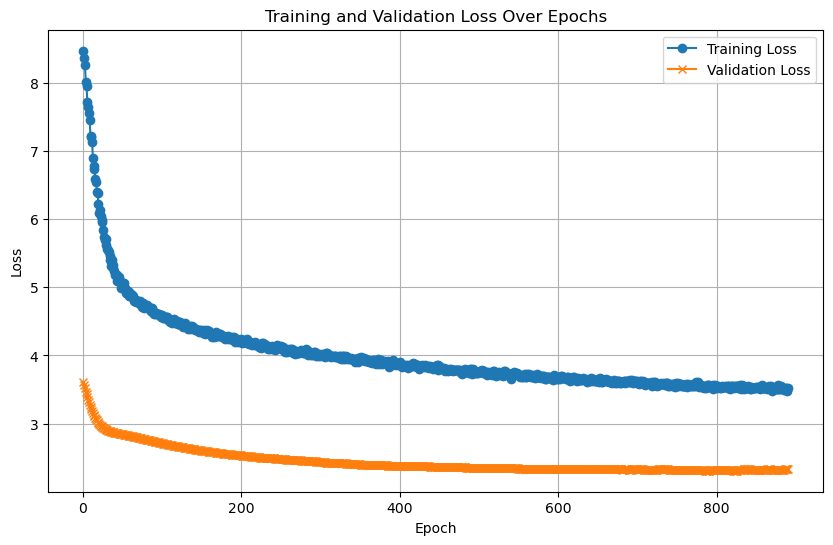

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/209], Loss: 5.2653
Test Batch [20/209], Loss: 5.4267
Test Batch [30/209], Loss: 5.7490
Test Batch [40/209], Loss: 6.0010
Test Batch [50/209], Loss: 7.3861
Test Batch [60/209], Loss: 5.8845


Test Batch [70/209], Loss: 4.9737
Test Batch [80/209], Loss: 5.0204
Test Batch [90/209], Loss: 4.9217
Test Batch [100/209], Loss: 4.9154
Test Batch [110/209], Loss: 4.7348
Test Batch [120/209], Loss: 4.4029
Test Batch [130/209], Loss: 4.8097
Test Batch [140/209], Loss: 4.8427
Test Batch [150/209], Loss: 4.7141


Test Batch [160/209], Loss: 5.0325
Test Batch [170/209], Loss: 5.0503
Test Batch [180/209], Loss: 5.1388
Test Batch [190/209], Loss: 5.1776
Test Batch [200/209], Loss: 5.2419

Test Loss: 5.2224


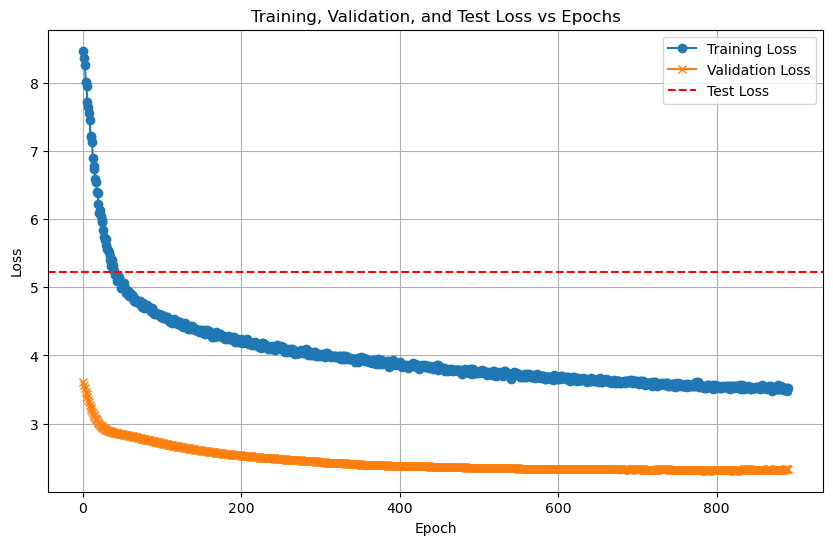

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/209 for test dataset.


  Processed batch 20/209 for test dataset.
  Processed batch 30/209 for test dataset.
  Processed batch 40/209 for test dataset.
  Processed batch 50/209 for test dataset.


  Processed batch 60/209 for test dataset.
  Processed batch 70/209 for test dataset.
  Processed batch 80/209 for test dataset.


  Processed batch 90/209 for test dataset.
  Processed batch 100/209 for test dataset.
  Processed batch 110/209 for test dataset.
  Processed batch 120/209 for test dataset.


  Processed batch 130/209 for test dataset.
  Processed batch 140/209 for test dataset.
  Processed batch 150/209 for test dataset.


  Processed batch 160/209 for test dataset.
  Processed batch 170/209 for test dataset.
  Processed batch 180/209 for test dataset.
  Processed batch 190/209 for test dataset.


  Processed batch 200/209 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (640, 128)
Train labels shape: (640,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53409, 128)
Test labels shape: (53409,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 88.75%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.71      1.00      0.83         5
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.67      0.80      0.73         5
           8       1.00      0.80      0.89         5
           9       1.00      1.00      1.00         5
          10       0.71      1.00      0.83         5
          11       1.00      0.80      0.89         5
          12       1.00      0.80      0.89         5
          13       0.8

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (640, 128)
Train labels shape: (640,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53409, 128)
Test labels shape: (53409,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7717  |  Val Loss: 2.7216
Validation loss improved from inf to 2.7216.
[Epoch 2/1000] Train Loss: 2.6822  |  Val Loss: 2.6427
Validation loss improved from 2.7216 to 2.6427.
[Epoch 3/1000] Train Loss: 2.6100  |  Val Loss: 2.5752
Validation loss improved from 2.6427 to 2.5752.
[Epoch 4/1000] Train Loss: 2.5456  |  Val Loss: 2.5198
Validation loss improved from 2.5752 to 2.5198.
[Epoch 5/1000] Train Loss: 2.4926  |  Val Loss: 2.4689
Validation loss improved from 2.5198 to 2.4689.
[Epoch 6/1000] Train Loss: 2.4427  |  Val Loss: 2.4218
Validation loss improved from 2.4689 to 2.4218.
[Epoch 7/1000] Train Loss: 2.3972  |  Val Loss: 2.3783
Validation loss improved from 2.4218 to 2.3783.
[Epoch 8/1000] Train Loss: 2.3545  |  Val Loss: 2.3388
Validation loss improved from 2.3783 to 2.3388.
[Epoch 9/1000] Train Loss: 2.3151  |  Val Loss: 2.3012
Validation loss improved from 2.3388 to 2.3012.


[Epoch 10/1000] Train Loss: 2.2783  |  Val Loss: 2.2657
Validation loss improved from 2.3012 to 2.2657.
[Epoch 11/1000] Train Loss: 2.2428  |  Val Loss: 2.2327
Validation loss improved from 2.2657 to 2.2327.
[Epoch 12/1000] Train Loss: 2.2097  |  Val Loss: 2.2007
Validation loss improved from 2.2327 to 2.2007.
[Epoch 13/1000] Train Loss: 2.1772  |  Val Loss: 2.1696
Validation loss improved from 2.2007 to 2.1696.
[Epoch 14/1000] Train Loss: 2.1454  |  Val Loss: 2.1397
Validation loss improved from 2.1696 to 2.1397.
[Epoch 15/1000] Train Loss: 2.1145  |  Val Loss: 2.1107
Validation loss improved from 2.1397 to 2.1107.
[Epoch 16/1000] Train Loss: 2.0852  |  Val Loss: 2.0814
Validation loss improved from 2.1107 to 2.0814.
[Epoch 17/1000] Train Loss: 2.0551  |  Val Loss: 2.0525
Validation loss improved from 2.0814 to 2.0525.
[Epoch 18/1000] Train Loss: 2.0252  |  Val Loss: 2.0237
Validation loss improved from 2.0525 to 2.0237.
[Epoch 19/1000] Train Loss: 1.9951  |  Val Loss: 1.9947
Validati

[Epoch 20/1000] Train Loss: 1.9648  |  Val Loss: 1.9650
Validation loss improved from 1.9947 to 1.9650.
[Epoch 21/1000] Train Loss: 1.9337  |  Val Loss: 1.9346
Validation loss improved from 1.9650 to 1.9346.
[Epoch 22/1000] Train Loss: 1.9020  |  Val Loss: 1.9033
Validation loss improved from 1.9346 to 1.9033.
[Epoch 23/1000] Train Loss: 1.8695  |  Val Loss: 1.8709
Validation loss improved from 1.9033 to 1.8709.
[Epoch 24/1000] Train Loss: 1.8364  |  Val Loss: 1.8381
Validation loss improved from 1.8709 to 1.8381.
[Epoch 25/1000] Train Loss: 1.8021  |  Val Loss: 1.8053
Validation loss improved from 1.8381 to 1.8053.
[Epoch 26/1000] Train Loss: 1.7686  |  Val Loss: 1.7720
Validation loss improved from 1.8053 to 1.7720.
[Epoch 27/1000] Train Loss: 1.7343  |  Val Loss: 1.7388
Validation loss improved from 1.7720 to 1.7388.
[Epoch 28/1000] Train Loss: 1.7005  |  Val Loss: 1.7056
Validation loss improved from 1.7388 to 1.7056.
[Epoch 29/1000] Train Loss: 1.6667  |  Val Loss: 1.6719
Validati

[Epoch 30/1000] Train Loss: 1.6319  |  Val Loss: 1.6392
Validation loss improved from 1.6719 to 1.6392.
[Epoch 31/1000] Train Loss: 1.5982  |  Val Loss: 1.6063
Validation loss improved from 1.6392 to 1.6063.
[Epoch 32/1000] Train Loss: 1.5650  |  Val Loss: 1.5745
Validation loss improved from 1.6063 to 1.5745.
[Epoch 33/1000] Train Loss: 1.5330  |  Val Loss: 1.5424
Validation loss improved from 1.5745 to 1.5424.
[Epoch 34/1000] Train Loss: 1.4996  |  Val Loss: 1.5123
Validation loss improved from 1.5424 to 1.5123.
[Epoch 35/1000] Train Loss: 1.4691  |  Val Loss: 1.4826
Validation loss improved from 1.5123 to 1.4826.
[Epoch 36/1000] Train Loss: 1.4378  |  Val Loss: 1.4529
Validation loss improved from 1.4826 to 1.4529.
[Epoch 37/1000] Train Loss: 1.4079  |  Val Loss: 1.4239
Validation loss improved from 1.4529 to 1.4239.
[Epoch 38/1000] Train Loss: 1.3787  |  Val Loss: 1.3963
Validation loss improved from 1.4239 to 1.3963.
[Epoch 39/1000] Train Loss: 1.3491  |  Val Loss: 1.3686
Validati

[Epoch 41/1000] Train Loss: 1.2929  |  Val Loss: 1.3149
Validation loss improved from 1.3412 to 1.3149.
[Epoch 42/1000] Train Loss: 1.2664  |  Val Loss: 1.2901
Validation loss improved from 1.3149 to 1.2901.
[Epoch 43/1000] Train Loss: 1.2399  |  Val Loss: 1.2641
Validation loss improved from 1.2901 to 1.2641.
[Epoch 44/1000] Train Loss: 1.2142  |  Val Loss: 1.2408
Validation loss improved from 1.2641 to 1.2408.
[Epoch 45/1000] Train Loss: 1.1889  |  Val Loss: 1.2174
Validation loss improved from 1.2408 to 1.2174.
[Epoch 46/1000] Train Loss: 1.1645  |  Val Loss: 1.1944
Validation loss improved from 1.2174 to 1.1944.
[Epoch 47/1000] Train Loss: 1.1407  |  Val Loss: 1.1724
Validation loss improved from 1.1944 to 1.1724.
[Epoch 48/1000] Train Loss: 1.1177  |  Val Loss: 1.1519
Validation loss improved from 1.1724 to 1.1519.
[Epoch 49/1000] Train Loss: 1.0955  |  Val Loss: 1.1313
Validation loss improved from 1.1519 to 1.1313.
[Epoch 50/1000] Train Loss: 1.0731  |  Val Loss: 1.1093
Validati

[Epoch 51/1000] Train Loss: 1.0520  |  Val Loss: 1.0903
Validation loss improved from 1.1093 to 1.0903.
[Epoch 52/1000] Train Loss: 1.0309  |  Val Loss: 1.0724
Validation loss improved from 1.0903 to 1.0724.
[Epoch 53/1000] Train Loss: 1.0107  |  Val Loss: 1.0536
Validation loss improved from 1.0724 to 1.0536.
[Epoch 54/1000] Train Loss: 0.9910  |  Val Loss: 1.0345
Validation loss improved from 1.0536 to 1.0345.
[Epoch 55/1000] Train Loss: 0.9713  |  Val Loss: 1.0158
Validation loss improved from 1.0345 to 1.0158.
[Epoch 56/1000] Train Loss: 0.9515  |  Val Loss: 1.0001
Validation loss improved from 1.0158 to 1.0001.
[Epoch 57/1000] Train Loss: 0.9322  |  Val Loss: 0.9818
Validation loss improved from 1.0001 to 0.9818.
[Epoch 58/1000] Train Loss: 0.9142  |  Val Loss: 0.9634
Validation loss improved from 0.9818 to 0.9634.
[Epoch 59/1000] Train Loss: 0.8954  |  Val Loss: 0.9490
Validation loss improved from 0.9634 to 0.9490.
[Epoch 60/1000] Train Loss: 0.8787  |  Val Loss: 0.9339
Validati

[Epoch 62/1000] Train Loss: 0.8423  |  Val Loss: 0.8999
Validation loss improved from 0.9128 to 0.8999.
[Epoch 63/1000] Train Loss: 0.8246  |  Val Loss: 0.8851
Validation loss improved from 0.8999 to 0.8851.
[Epoch 64/1000] Train Loss: 0.8083  |  Val Loss: 0.8681
Validation loss improved from 0.8851 to 0.8681.
[Epoch 65/1000] Train Loss: 0.7913  |  Val Loss: 0.8540
Validation loss improved from 0.8681 to 0.8540.
[Epoch 66/1000] Train Loss: 0.7751  |  Val Loss: 0.8396
Validation loss improved from 0.8540 to 0.8396.
[Epoch 67/1000] Train Loss: 0.7590  |  Val Loss: 0.8240
Validation loss improved from 0.8396 to 0.8240.
[Epoch 68/1000] Train Loss: 0.7434  |  Val Loss: 0.8109
Validation loss improved from 0.8240 to 0.8109.
[Epoch 69/1000] Train Loss: 0.7281  |  Val Loss: 0.7965
Validation loss improved from 0.8109 to 0.7965.
[Epoch 70/1000] Train Loss: 0.7132  |  Val Loss: 0.7845
Validation loss improved from 0.7965 to 0.7845.
[Epoch 71/1000] Train Loss: 0.6983  |  Val Loss: 0.7711
Validati

[Epoch 72/1000] Train Loss: 0.6837  |  Val Loss: 0.7592
Validation loss improved from 0.7711 to 0.7592.
[Epoch 73/1000] Train Loss: 0.6698  |  Val Loss: 0.7475
Validation loss improved from 0.7592 to 0.7475.
[Epoch 74/1000] Train Loss: 0.6561  |  Val Loss: 0.7344
Validation loss improved from 0.7475 to 0.7344.
[Epoch 75/1000] Train Loss: 0.6430  |  Val Loss: 0.7251
Validation loss improved from 0.7344 to 0.7251.
[Epoch 76/1000] Train Loss: 0.6299  |  Val Loss: 0.7130
Validation loss improved from 0.7251 to 0.7130.
[Epoch 77/1000] Train Loss: 0.6175  |  Val Loss: 0.7022
Validation loss improved from 0.7130 to 0.7022.
[Epoch 78/1000] Train Loss: 0.6049  |  Val Loss: 0.6908
Validation loss improved from 0.7022 to 0.6908.
[Epoch 79/1000] Train Loss: 0.5932  |  Val Loss: 0.6837
Validation loss improved from 0.6908 to 0.6837.
[Epoch 80/1000] Train Loss: 0.5810  |  Val Loss: 0.6715
Validation loss improved from 0.6837 to 0.6715.
[Epoch 81/1000] Train Loss: 0.5703  |  Val Loss: 0.6602
Validati

[Epoch 82/1000] Train Loss: 0.5595  |  Val Loss: 0.6560
Validation loss improved from 0.6602 to 0.6560.
[Epoch 83/1000] Train Loss: 0.5476  |  Val Loss: 0.6424
Validation loss improved from 0.6560 to 0.6424.
[Epoch 84/1000] Train Loss: 0.5369  |  Val Loss: 0.6332
Validation loss improved from 0.6424 to 0.6332.
[Epoch 85/1000] Train Loss: 0.5266  |  Val Loss: 0.6245
Validation loss improved from 0.6332 to 0.6245.
[Epoch 86/1000] Train Loss: 0.5165  |  Val Loss: 0.6197
Validation loss improved from 0.6245 to 0.6197.
[Epoch 87/1000] Train Loss: 0.5060  |  Val Loss: 0.6081
Validation loss improved from 0.6197 to 0.6081.
[Epoch 88/1000] Train Loss: 0.4968  |  Val Loss: 0.6000
Validation loss improved from 0.6081 to 0.6000.
[Epoch 89/1000] Train Loss: 0.4866  |  Val Loss: 0.5930
Validation loss improved from 0.6000 to 0.5930.
[Epoch 90/1000] Train Loss: 0.4778  |  Val Loss: 0.5838
Validation loss improved from 0.5930 to 0.5838.
[Epoch 91/1000] Train Loss: 0.4684  |  Val Loss: 0.5771
Validati

[Epoch 93/1000] Train Loss: 0.4506  |  Val Loss: 0.5623
Validation loss improved from 0.5715 to 0.5623.
[Epoch 94/1000] Train Loss: 0.4414  |  Val Loss: 0.5544
Validation loss improved from 0.5623 to 0.5544.
[Epoch 95/1000] Train Loss: 0.4327  |  Val Loss: 0.5490
Validation loss improved from 0.5544 to 0.5490.
[Epoch 96/1000] Train Loss: 0.4238  |  Val Loss: 0.5416
Validation loss improved from 0.5490 to 0.5416.
[Epoch 97/1000] Train Loss: 0.4155  |  Val Loss: 0.5334
Validation loss improved from 0.5416 to 0.5334.
[Epoch 98/1000] Train Loss: 0.4072  |  Val Loss: 0.5288
Validation loss improved from 0.5334 to 0.5288.
[Epoch 99/1000] Train Loss: 0.3993  |  Val Loss: 0.5215
Validation loss improved from 0.5288 to 0.5215.
[Epoch 100/1000] Train Loss: 0.3917  |  Val Loss: 0.5142
Validation loss improved from 0.5215 to 0.5142.
[Epoch 101/1000] Train Loss: 0.3842  |  Val Loss: 0.5098
Validation loss improved from 0.5142 to 0.5098.
[Epoch 102/1000] Train Loss: 0.3767  |  Val Loss: 0.5035
Valid

[Epoch 104/1000] Train Loss: 0.3633  |  Val Loss: 0.4945
Validation loss improved from 0.4981 to 0.4945.
[Epoch 105/1000] Train Loss: 0.3560  |  Val Loss: 0.4865
Validation loss improved from 0.4945 to 0.4865.
[Epoch 106/1000] Train Loss: 0.3498  |  Val Loss: 0.4824
Validation loss improved from 0.4865 to 0.4824.
[Epoch 107/1000] Train Loss: 0.3429  |  Val Loss: 0.4801
Validation loss improved from 0.4824 to 0.4801.
[Epoch 108/1000] Train Loss: 0.3370  |  Val Loss: 0.4784
Validation loss improved from 0.4801 to 0.4784.
[Epoch 109/1000] Train Loss: 0.3309  |  Val Loss: 0.4674
Validation loss improved from 0.4784 to 0.4674.
[Epoch 110/1000] Train Loss: 0.3244  |  Val Loss: 0.4691
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 111/1000] Train Loss: 0.3187  |  Val Loss: 0.4631
Validation loss improved from 0.4674 to 0.4631.
[Epoch 112/1000] Train Loss: 0.3125  |  Val Loss: 0.4601
Validation loss improved from 0.4631 to 0.4601.
[Epoch 113/1000] Train Loss: 0.3061  |  Val Loss:

[Epoch 114/1000] Train Loss: 0.3007  |  Val Loss: 0.4505
Validation loss improved from 0.4555 to 0.4505.
[Epoch 115/1000] Train Loss: 0.2953  |  Val Loss: 0.4505
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 116/1000] Train Loss: 0.2896  |  Val Loss: 0.4454
Validation loss improved from 0.4505 to 0.4454.
[Epoch 117/1000] Train Loss: 0.2840  |  Val Loss: 0.4400
Validation loss improved from 0.4454 to 0.4400.
[Epoch 118/1000] Train Loss: 0.2793  |  Val Loss: 0.4377
Validation loss improved from 0.4400 to 0.4377.
[Epoch 119/1000] Train Loss: 0.2743  |  Val Loss: 0.4376
Validation loss improved from 0.4377 to 0.4376.
[Epoch 120/1000] Train Loss: 0.2690  |  Val Loss: 0.4318
Validation loss improved from 0.4376 to 0.4318.
[Epoch 121/1000] Train Loss: 0.2648  |  Val Loss: 0.4268
Validation loss improved from 0.4318 to 0.4268.
[Epoch 122/1000] Train Loss: 0.2605  |  Val Loss: 0.4288
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 123/1000] Train Loss: 0.2559  |  Val Loss: 0.4256
Validation loss improved from 0.4268 to 0.4256.
[Epoch 124/1000] Train Loss: 0.2520  |  Val Loss: 0.4212
Validation loss improved from 0.4256 to 0.4212.
[Epoch 125/1000] Train Loss: 0.2475  |  Val Loss: 0.4227
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 126/1000] Train Loss: 0.2431  |  Val Loss: 0.4161
Validation loss improved from 0.4212 to 0.4161.
[Epoch 127/1000] Train Loss: 0.2388  |  Val Loss: 0.4167
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 128/1000] Train Loss: 0.2354  |  Val Loss: 0.4155
Validation loss improved from 0.4161 to 0.4155.
[Epoch 129/1000] Train Loss: 0.2314  |  Val Loss: 0.4097
Validation loss improved from 0.4155 to 0.4097.
[Epoch 130/1000] Train Loss: 0.2278  |  Val Loss: 0.4120
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 131/1000] Train Loss: 0.2242  |  Val Loss: 0.4088
Validation loss improved from 0.4097 to 0.4088.
[Epoch 132/1000] Train Loss: 0.2212  

[Epoch 133/1000] Train Loss: 0.2181  |  Val Loss: 0.4115
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 134/1000] Train Loss: 0.2147  |  Val Loss: 0.4033
Validation loss improved from 0.4076 to 0.4033.
[Epoch 135/1000] Train Loss: 0.2109  |  Val Loss: 0.4044
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 136/1000] Train Loss: 0.2083  |  Val Loss: 0.4048
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 137/1000] Train Loss: 0.2055  |  Val Loss: 0.4025
Validation loss improved from 0.4033 to 0.4025.
[Epoch 138/1000] Train Loss: 0.2025  |  Val Loss: 0.4019
Validation loss improved from 0.4025 to 0.4019.
[Epoch 139/1000] Train Loss: 0.1996  |  Val Loss: 0.3998
Validation loss improved from 0.4019 to 0.3998.
[Epoch 140/1000] Train Loss: 0.1972  |  Val Loss: 0.4009
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 141/1000] Train Loss: 0.1944  |  Val Loss: 0.3983
Validation loss improved from 0.3998 to 0.3983.
[Epoch 142/1000] Train Loss: 0.

[Epoch 143/1000] Train Loss: 0.1894  |  Val Loss: 0.4047
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 144/1000] Train Loss: 0.1871  |  Val Loss: 0.3960
Validation loss improved from 0.3975 to 0.3960.
[Epoch 145/1000] Train Loss: 0.1849  |  Val Loss: 0.3987
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 146/1000] Train Loss: 0.1828  |  Val Loss: 0.3964
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 147/1000] Train Loss: 0.1799  |  Val Loss: 0.3971
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 148/1000] Train Loss: 0.1779  |  Val Loss: 0.3981
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 149/1000] Train Loss: 0.1770  |  Val Loss: 0.3910
Validation loss improved from 0.3960 to 0.3910.
[Epoch 150/1000] Train Loss: 0.1734  |  Val Loss: 0.4030
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 151/1000] Train Loss: 0.1724  |  Val Loss: 0.3963
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 152/10

[Epoch 154/1000] Train Loss: 0.1660  |  Val Loss: 0.3916
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 155/1000] Train Loss: 0.1640  |  Val Loss: 0.3985
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 156/1000] Train Loss: 0.1623  |  Val Loss: 0.3960
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 157/1000] Train Loss: 0.1606  |  Val Loss: 0.3973
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 158/1000] Train Loss: 0.1588  |  Val Loss: 0.3942
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 159/1000] Train Loss: 0.1571  |  Val Loss: 0.3961
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 160/1000] Train Loss: 0.1554  |  Val Loss: 0.3963
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 161/1000] Train Loss: 0.1537  |  Val Loss: 0.3980
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 162/1000] Train Loss: 0.1529  |  Val Loss: 0.3923
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 164/1000] Train Loss: 0.1495  |  Val Loss: 0.3949
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 165/1000] Train Loss: 0.1484  |  Val Loss: 0.3986
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 166/1000] Train Loss: 0.1463  |  Val Loss: 0.3946
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 167/1000] Train Loss: 0.1453  |  Val Loss: 0.3944
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 168/1000] Train Loss: 0.1445  |  Val Loss: 0.4019
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 169/1000] Train Loss: 0.1430  |  Val Loss: 0.3953
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 170/1000] Train Loss: 0.1413  |  Val Loss: 0.3968
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 171/1000] Train Loss: 0.1409  |  Val Loss: 0.3984
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 172/1000] Train Loss: 0.1393  |  Val Loss: 0.4018
!! Validation loss did NOT improve !! Patience:

[Epoch 173/1000] Train Loss: 0.1388  |  Val Loss: 0.3997
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 174/1000] Train Loss: 0.1369  |  Val Loss: 0.3984
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 175/1000] Train Loss: 0.1358  |  Val Loss: 0.4010
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 176/1000] Train Loss: 0.1347  |  Val Loss: 0.3992
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 177/1000] Train Loss: 0.1334  |  Val Loss: 0.4049
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 178/1000] Train Loss: 0.1324  |  Val Loss: 0.4030
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 179/1000] Train Loss: 0.1317  |  Val Loss: 0.3989
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 180/1000] Train Loss: 0.1307  |  Val Loss: 0.4028
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 181/1000] Train Loss: 0.1294  |  Val Loss: 0.4076
!! Validation loss did NOT improve !! Patience:

[Epoch 184/1000] Train Loss: 0.1264  |  Val Loss: 0.4076
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 185/1000] Train Loss: 0.1257  |  Val Loss: 0.4044
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 186/1000] Train Loss: 0.1247  |  Val Loss: 0.4081
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 187/1000] Train Loss: 0.1238  |  Val Loss: 0.4088
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 188/1000] Train Loss: 0.1233  |  Val Loss: 0.4077
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 189/1000] Train Loss: 0.1223  |  Val Loss: 0.4097
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 190/1000] Train Loss: 0.1215  |  Val Loss: 0.4116
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 191/1000] Train Loss: 0.1204  |  Val Loss: 0.4082
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 192/1000] Train Loss: 0.1195  |  Val Loss: 0.4086
!! Validation loss did NOT improve !! Patience:

[Epoch 194/1000] Train Loss: 0.1179  |  Val Loss: 0.4144
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 195/1000] Train Loss: 0.1171  |  Val Loss: 0.4138
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 196/1000] Train Loss: 0.1162  |  Val Loss: 0.4134
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 197/1000] Train Loss: 0.1160  |  Val Loss: 0.4172
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 198/1000] Train Loss: 0.1150  |  Val Loss: 0.4160
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 199/1000] Train Loss: 0.1141  |  Val Loss: 0.4165
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 200/1000] Train Loss: 0.1137  |  Val Loss: 0.4223
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 201/1000] Train Loss: 0.1126  |  Val Loss: 0.4185
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 202/1000] Train Loss: 0.1127  |  Val Loss: 0.4192
!! Validation loss did NOT improve !! Patience:

[Epoch 205/1000] Train Loss: 0.1102  |  Val Loss: 0.4249
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 206/1000] Train Loss: 0.1092  |  Val Loss: 0.4241
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 207/1000] Train Loss: 0.1086  |  Val Loss: 0.4266
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 208/1000] Train Loss: 0.1080  |  Val Loss: 0.4240
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 209/1000] Train Loss: 0.1074  |  Val Loss: 0.4272
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 210/1000] Train Loss: 0.1072  |  Val Loss: 0.4245
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 211/1000] Train Loss: 0.1066  |  Val Loss: 0.4339
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 212/1000] Train Loss: 0.1057  |  Val Loss: 0.4306
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 213/1000] Train Loss: 0.1052  |  Val Loss: 0.4304
!! Validation loss did NOT improve !! Patience:

[Epoch 215/1000] Train Loss: 0.1043  |  Val Loss: 0.4352
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 216/1000] Train Loss: 0.1045  |  Val Loss: 0.4321
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 217/1000] Train Loss: 0.1036  |  Val Loss: 0.4344
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 218/1000] Train Loss: 0.1025  |  Val Loss: 0.4328
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 219/1000] Train Loss: 0.1021  |  Val Loss: 0.4394
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 220/1000] Train Loss: 0.1015  |  Val Loss: 0.4375
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 221/1000] Train Loss: 0.1012  |  Val Loss: 0.4366
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 222/1000] Train Loss: 0.1006  |  Val Loss: 0.4379
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 223/1000] Train Loss: 0.1004  |  Val Loss: 0.4430
!! Validation loss did NOT improve !! Patience:

[Epoch 225/1000] Train Loss: 0.0998  |  Val Loss: 0.4402
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 226/1000] Train Loss: 0.0987  |  Val Loss: 0.4389
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 227/1000] Train Loss: 0.0987  |  Val Loss: 0.4419
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 228/1000] Train Loss: 0.0983  |  Val Loss: 0.4479
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 229/1000] Train Loss: 0.0974  |  Val Loss: 0.4422
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 230/1000] Train Loss: 0.0974  |  Val Loss: 0.4418
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 231/1000] Train Loss: 0.0968  |  Val Loss: 0.4481
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 232/1000] Train Loss: 0.0963  |  Val Loss: 0.4516
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 233/1000] Train Loss: 0.0963  |  Val Loss: 0.4450
!! Validation loss did NOT improve !! Patience:

[Epoch 235/1000] Train Loss: 0.0951  |  Val Loss: 0.4492
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 236/1000] Train Loss: 0.0945  |  Val Loss: 0.4575
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 237/1000] Train Loss: 0.0941  |  Val Loss: 0.4500
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 238/1000] Train Loss: 0.0941  |  Val Loss: 0.4503
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 239/1000] Train Loss: 0.0934  |  Val Loss: 0.4546
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 240/1000] Train Loss: 0.0929  |  Val Loss: 0.4526
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 241/1000] Train Loss: 0.0926  |  Val Loss: 0.4572
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 242/1000] Train Loss: 0.0925  |  Val Loss: 0.4581
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 243/1000] Train Loss: 0.0920  |  Val Loss: 0.4620
!! Validation loss did NOT improve !! Patience:

[Epoch 246/1000] Train Loss: 0.0908  |  Val Loss: 0.4634
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 247/1000] Train Loss: 0.0903  |  Val Loss: 0.4640
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 248/1000] Train Loss: 0.0902  |  Val Loss: 0.4726
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 249/1000] Train Loss: 0.0895  |  Val Loss: 0.4680
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 249 !!
No improvement for 100 epochs.


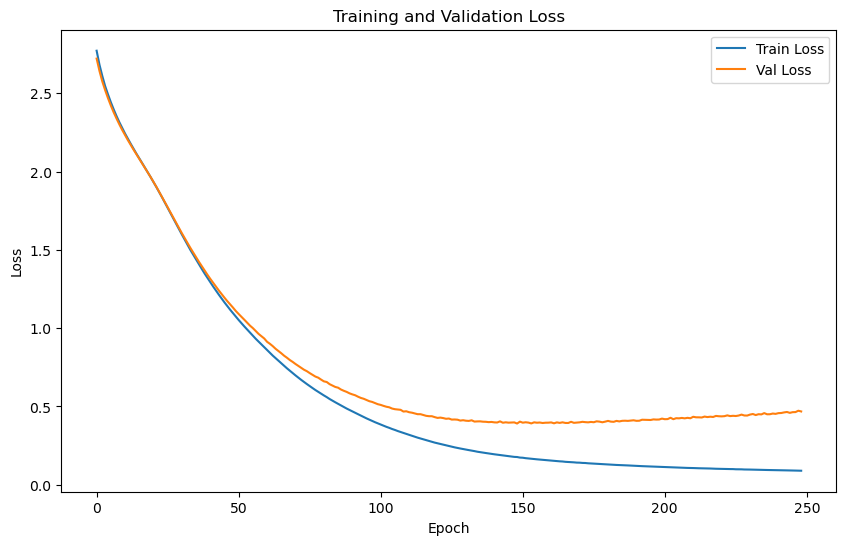

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.4269 | Test Accuracy: 86.02%


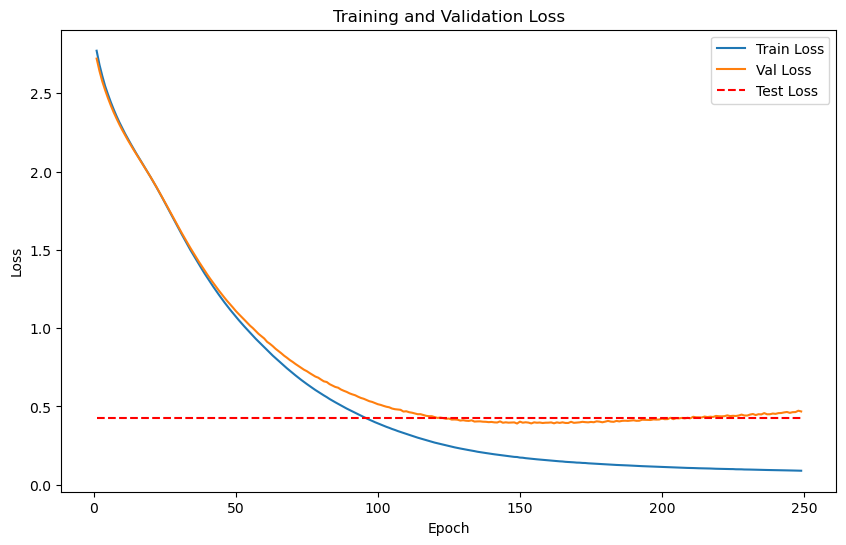

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 640 samples with 64 features each
LOG: Labels shape: (640,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53409 samples with 64 features each
LOG: Labels shape: (53409,)


Train embeddings shape: (640, 64), 
Train labels shape: (640,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53409, 64), 
Test labels shape: (53409,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.4713


    Batch [2/2], Train Loss: 0.4677
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.3947
Epoch [1/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.3856

Validation loss improved from inf to 0.3856. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/2], Train Loss: 0.4641


    Batch [2/2], Train Loss: 0.4646
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.3732
    Batch [2/2], Val Loss: 0.3936
Epoch [2/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.3834

Validation loss improved from 0.3856 to 0.3834. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/2], Train Loss: 0.4666


    Batch [2/2], Train Loss: 0.4621
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.3704
    Batch [2/2], Val Loss: 0.3896
Epoch [3/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.3800

Validation loss improved from 0.3834 to 0.3800. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/2], Train Loss: 0.4643


    Batch [2/2], Train Loss: 0.4637
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.3694
    Batch [2/2], Val Loss: 0.3828
Epoch [4/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.3761

Validation loss improved from 0.3800 to 0.3761. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/2], Train Loss: 0.4612


    Batch [2/2], Train Loss: 0.4637
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.3683
    Batch [2/2], Val Loss: 0.3752
Epoch [5/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.3717

Validation loss improved from 0.3761 to 0.3717. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/2], Train Loss: 0.4584


    Batch [2/2], Train Loss: 0.4600
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.3678
    Batch [2/2], Val Loss: 0.3685
Epoch [6/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.3682

Validation loss improved from 0.3717 to 0.3682. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/2], Train Loss: 0.4582


    Batch [2/2], Train Loss: 0.4635
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.3677
    Batch [2/2], Val Loss: 0.3644
Epoch [7/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.3661

Validation loss improved from 0.3682 to 0.3661. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/2], Train Loss: 0.4572


    Batch [2/2], Train Loss: 0.4560
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.3675
    Batch [2/2], Val Loss: 0.3608
Epoch [8/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.3641

Validation loss improved from 0.3661 to 0.3641. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/2], Train Loss: 0.4534


    Batch [2/2], Train Loss: 0.4532
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.3662
    Batch [2/2], Val Loss: 0.3578
Epoch [9/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.3620

Validation loss improved from 0.3641 to 0.3620. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/2], Train Loss: 0.4541
    Batch [2/2], Train Loss: 0.4502
LOG: Epoch [10/2000] - Validation


    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.3552
Epoch [10/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.3600

Validation loss improved from 0.3620 to 0.3600. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/2], Train Loss: 0.4492


    Batch [2/2], Train Loss: 0.4524
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.3633
    Batch [2/2], Val Loss: 0.3532
Epoch [11/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.3583

Validation loss improved from 0.3600 to 0.3583. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/2], Train Loss: 0.4491


    Batch [2/2], Train Loss: 0.4472
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.3618
    Batch [2/2], Val Loss: 0.3508
Epoch [12/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.3563

Validation loss improved from 0.3583 to 0.3563. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/2], Train Loss: 0.4477


    Batch [2/2], Train Loss: 0.4479
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.3485
Epoch [13/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.3544

Validation loss improved from 0.3563 to 0.3544. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/2], Train Loss: 0.4490


    Batch [2/2], Train Loss: 0.4454
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.3591
    Batch [2/2], Val Loss: 0.3470
Epoch [14/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.3531

Validation loss improved from 0.3544 to 0.3531. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/2], Train Loss: 0.4482
    Batch [2/2], Train Loss: 0.4461
LOG: Epoch [15/2000] - Validation


    Batch [1/2], Val Loss: 0.3580
    Batch [2/2], Val Loss: 0.3456
Epoch [15/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.3518

Validation loss improved from 0.3531 to 0.3518. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/2], Train Loss: 0.4450


    Batch [2/2], Train Loss: 0.4402
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.3567
    Batch [2/2], Val Loss: 0.3439
Epoch [16/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.3503

Validation loss improved from 0.3518 to 0.3503. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/2], Train Loss: 0.4421


    Batch [2/2], Train Loss: 0.4436
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.3557
    Batch [2/2], Val Loss: 0.3423
Epoch [17/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.3490

Validation loss improved from 0.3503 to 0.3490. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/2], Train Loss: 0.4454


    Batch [2/2], Train Loss: 0.4467
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.3547
    Batch [2/2], Val Loss: 0.3408
Epoch [18/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.3478

Validation loss improved from 0.3490 to 0.3478. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/2], Train Loss: 0.4458


    Batch [2/2], Train Loss: 0.4413
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.3536
    Batch [2/2], Val Loss: 0.3392
Epoch [19/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.3464

Validation loss improved from 0.3478 to 0.3464. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/2], Train Loss: 0.4375


    Batch [2/2], Train Loss: 0.4397
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.3524
    Batch [2/2], Val Loss: 0.3379
Epoch [20/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.3452

Validation loss improved from 0.3464 to 0.3452. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/2], Train Loss: 0.4402


    Batch [2/2], Train Loss: 0.4367
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.3511
    Batch [2/2], Val Loss: 0.3368
Epoch [21/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.3440

Validation loss improved from 0.3452 to 0.3440. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/2], Train Loss: 0.4398


    Batch [2/2], Train Loss: 0.4394
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.3498
    Batch [2/2], Val Loss: 0.3355
Epoch [22/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.3426

Validation loss improved from 0.3440 to 0.3426. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/2], Train Loss: 0.4290


    Batch [2/2], Train Loss: 0.4342
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.3340
Epoch [23/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.3413

Validation loss improved from 0.3426 to 0.3413. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/2], Train Loss: 0.4343


    Batch [2/2], Train Loss: 0.4308
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.3472
    Batch [2/2], Val Loss: 0.3324
Epoch [24/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.3398

Validation loss improved from 0.3413 to 0.3398. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/2], Train Loss: 0.4298


    Batch [2/2], Train Loss: 0.4370
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.3460
    Batch [2/2], Val Loss: 0.3305
Epoch [25/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.3383

Validation loss improved from 0.3398 to 0.3383. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/2], Train Loss: 0.4277


    Batch [2/2], Train Loss: 0.4353
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.3447
    Batch [2/2], Val Loss: 0.3289
Epoch [26/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.3368

Validation loss improved from 0.3383 to 0.3368. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/2], Train Loss: 0.4331


    Batch [2/2], Train Loss: 0.4265
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.3435
    Batch [2/2], Val Loss: 0.3273
Epoch [27/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.3354

Validation loss improved from 0.3368 to 0.3354. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/2], Train Loss: 0.4281
    Batch [2/2], Train Loss: 0.4266
LOG: Epoch [28/2000] - Validation


    Batch [1/2], Val Loss: 0.3422
    Batch [2/2], Val Loss: 0.3253
Epoch [28/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.3338

Validation loss improved from 0.3354 to 0.3338. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/2], Train Loss: 0.4325


    Batch [2/2], Train Loss: 0.4276
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.3410
    Batch [2/2], Val Loss: 0.3236
Epoch [29/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.3323

Validation loss improved from 0.3338 to 0.3323. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/2], Train Loss: 0.4282


    Batch [2/2], Train Loss: 0.4284
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.3398
    Batch [2/2], Val Loss: 0.3218
Epoch [30/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.3308

Validation loss improved from 0.3323 to 0.3308. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/2], Train Loss: 0.4259


    Batch [2/2], Train Loss: 0.4224
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.3386
    Batch [2/2], Val Loss: 0.3199
Epoch [31/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.3293

Validation loss improved from 0.3308 to 0.3293. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/2], Train Loss: 0.4261


    Batch [2/2], Train Loss: 0.4240
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.3374
    Batch [2/2], Val Loss: 0.3182
Epoch [32/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.3278

Validation loss improved from 0.3293 to 0.3278. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/2], Train Loss: 0.4204


    Batch [2/2], Train Loss: 0.4176
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.3362
    Batch [2/2], Val Loss: 0.3163
Epoch [33/2000], Avg Train Loss: 0.4190, Avg Val Loss: 0.3263

Validation loss improved from 0.3278 to 0.3263. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/2], Train Loss: 0.4227


    Batch [2/2], Train Loss: 0.4144
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.3352
    Batch [2/2], Val Loss: 0.3147
Epoch [34/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.3249

Validation loss improved from 0.3263 to 0.3249. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/2], Train Loss: 0.4229


    Batch [2/2], Train Loss: 0.4130
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.3130
Epoch [35/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.3235

Validation loss improved from 0.3249 to 0.3235. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/2], Train Loss: 0.4165


    Batch [2/2], Train Loss: 0.4192
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.3333
    Batch [2/2], Val Loss: 0.3111
Epoch [36/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.3222

Validation loss improved from 0.3235 to 0.3222. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/2], Train Loss: 0.4210


    Batch [2/2], Train Loss: 0.4147
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.3324
    Batch [2/2], Val Loss: 0.3093
Epoch [37/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.3209

Validation loss improved from 0.3222 to 0.3209. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/2], Train Loss: 0.4116
    Batch [2/2], Train Loss: 0.4180
LOG: Epoch [38/2000] - Validation


    Batch [1/2], Val Loss: 0.3315
    Batch [2/2], Val Loss: 0.3074
Epoch [38/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.3194

Validation loss improved from 0.3209 to 0.3194. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/2], Train Loss: 0.4153


    Batch [2/2], Train Loss: 0.4123
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.3307
    Batch [2/2], Val Loss: 0.3056
Epoch [39/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.3182

Validation loss improved from 0.3194 to 0.3182. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/2], Train Loss: 0.4158


    Batch [2/2], Train Loss: 0.4057
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.3297
    Batch [2/2], Val Loss: 0.3037
Epoch [40/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.3167

Validation loss improved from 0.3182 to 0.3167. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/2], Train Loss: 0.4047


    Batch [2/2], Train Loss: 0.4087
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.3286
    Batch [2/2], Val Loss: 0.3018
Epoch [41/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.3152

Validation loss improved from 0.3167 to 0.3152. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/2], Train Loss: 0.4077
    Batch [2/2], Train Loss: 0.4138
LOG: Epoch [42/2000] - Validation


    Batch [1/2], Val Loss: 0.3274
    Batch [2/2], Val Loss: 0.2997
Epoch [42/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.3136

Validation loss improved from 0.3152 to 0.3136. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/2], Train Loss: 0.4097


    Batch [2/2], Train Loss: 0.4036
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.3263
    Batch [2/2], Val Loss: 0.2977
Epoch [43/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.3120

Validation loss improved from 0.3136 to 0.3120. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/2], Train Loss: 0.4009


    Batch [2/2], Train Loss: 0.4086
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.3254
    Batch [2/2], Val Loss: 0.2959
Epoch [44/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.3106

Validation loss improved from 0.3120 to 0.3106. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/2], Train Loss: 0.4074


    Batch [2/2], Train Loss: 0.4068
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.3245
    Batch [2/2], Val Loss: 0.2945
Epoch [45/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.3095

Validation loss improved from 0.3106 to 0.3095. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/2], Train Loss: 0.4112


    Batch [2/2], Train Loss: 0.4023
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.3236
    Batch [2/2], Val Loss: 0.2930
Epoch [46/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.3083

Validation loss improved from 0.3095 to 0.3083. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/2], Train Loss: 0.4023


    Batch [2/2], Train Loss: 0.4040
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.3229
    Batch [2/2], Val Loss: 0.2918
Epoch [47/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.3074

Validation loss improved from 0.3083 to 0.3074. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/2], Train Loss: 0.4055
    Batch [2/2], Train Loss: 0.4006
LOG: Epoch [48/2000] - Validation


    Batch [1/2], Val Loss: 0.3219
    Batch [2/2], Val Loss: 0.2905
Epoch [48/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.3062

Validation loss improved from 0.3074 to 0.3062. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/2], Train Loss: 0.4012


    Batch [2/2], Train Loss: 0.3980
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.3212
    Batch [2/2], Val Loss: 0.2890
Epoch [49/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.3051

Validation loss improved from 0.3062 to 0.3051. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/2], Train Loss: 0.3995


    Batch [2/2], Train Loss: 0.3986
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.3203
    Batch [2/2], Val Loss: 0.2877
Epoch [50/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.3040

Validation loss improved from 0.3051 to 0.3040. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/2], Train Loss: 0.3949


    Batch [2/2], Train Loss: 0.3975
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.3196
    Batch [2/2], Val Loss: 0.2857
Epoch [51/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3027

Validation loss improved from 0.3040 to 0.3027. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/2], Train Loss: 0.4008


    Batch [2/2], Train Loss: 0.3974
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.3189
    Batch [2/2], Val Loss: 0.2840
Epoch [52/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.3015

Validation loss improved from 0.3027 to 0.3015. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/2], Train Loss: 0.3935


    Batch [2/2], Train Loss: 0.3955
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.3184
    Batch [2/2], Val Loss: 0.2823
Epoch [53/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3004

Validation loss improved from 0.3015 to 0.3004. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/2], Train Loss: 0.3979


    Batch [2/2], Train Loss: 0.3912
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.3178
    Batch [2/2], Val Loss: 0.2807
Epoch [54/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2993

Validation loss improved from 0.3004 to 0.2993. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/2], Train Loss: 0.3980


    Batch [2/2], Train Loss: 0.3914
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.2790
Epoch [55/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2981

Validation loss improved from 0.2993 to 0.2981. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/2], Train Loss: 0.3873


    Batch [2/2], Train Loss: 0.3909
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.3165
    Batch [2/2], Val Loss: 0.2774
Epoch [56/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2969

Validation loss improved from 0.2981 to 0.2969. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/2], Train Loss: 0.3963


    Batch [2/2], Train Loss: 0.3926
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.3158
    Batch [2/2], Val Loss: 0.2756
Epoch [57/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2957

Validation loss improved from 0.2969 to 0.2957. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/2], Train Loss: 0.3952


    Batch [2/2], Train Loss: 0.3855
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.3148
    Batch [2/2], Val Loss: 0.2740
Epoch [58/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2944

Validation loss improved from 0.2957 to 0.2944. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/2], Train Loss: 0.3899


    Batch [2/2], Train Loss: 0.3881
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.2725
Epoch [59/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.2932

Validation loss improved from 0.2944 to 0.2932. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/2], Train Loss: 0.3868


    Batch [2/2], Train Loss: 0.3849
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.3131
    Batch [2/2], Val Loss: 0.2709
Epoch [60/2000], Avg Train Loss: 0.3859, Avg Val Loss: 0.2920

Validation loss improved from 0.2932 to 0.2920. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/2], Train Loss: 0.3852


    Batch [2/2], Train Loss: 0.3840
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.3126
    Batch [2/2], Val Loss: 0.2689
Epoch [61/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.2907

Validation loss improved from 0.2920 to 0.2907. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/2], Train Loss: 0.3845


    Batch [2/2], Train Loss: 0.3903
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.3119
    Batch [2/2], Val Loss: 0.2673
Epoch [62/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.2896

Validation loss improved from 0.2907 to 0.2896. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/2], Train Loss: 0.3877


    Batch [2/2], Train Loss: 0.3843
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.3113
    Batch [2/2], Val Loss: 0.2655
Epoch [63/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.2884

Validation loss improved from 0.2896 to 0.2884. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/2], Train Loss: 0.3846


    Batch [2/2], Train Loss: 0.3890
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.2641
Epoch [64/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.2873

Validation loss improved from 0.2884 to 0.2873. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/2], Train Loss: 0.3867


    Batch [2/2], Train Loss: 0.3809
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.3099
    Batch [2/2], Val Loss: 0.2628
Epoch [65/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.2863

Validation loss improved from 0.2873 to 0.2863. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/2], Train Loss: 0.3875


    Batch [2/2], Train Loss: 0.3780
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.3093
    Batch [2/2], Val Loss: 0.2611
Epoch [66/2000], Avg Train Loss: 0.3828, Avg Val Loss: 0.2852

Validation loss improved from 0.2863 to 0.2852. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/2], Train Loss: 0.3751
    Batch [2/2], Train Loss: 0.3875
LOG: Epoch [67/2000] - Validation


    Batch [1/2], Val Loss: 0.3087
    Batch [2/2], Val Loss: 0.2596
Epoch [67/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2842

Validation loss improved from 0.2852 to 0.2842. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/2], Train Loss: 0.3801


    Batch [2/2], Train Loss: 0.3708
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.3082
    Batch [2/2], Val Loss: 0.2578
Epoch [68/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.2830

Validation loss improved from 0.2842 to 0.2830. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/2], Train Loss: 0.3825
    Batch [2/2], Train Loss: 0.3722
LOG: Epoch [69/2000] - Validation


    Batch [1/2], Val Loss: 0.3075
    Batch [2/2], Val Loss: 0.2560
Epoch [69/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.2817

Validation loss improved from 0.2830 to 0.2817. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/2], Train Loss: 0.3743


    Batch [2/2], Train Loss: 0.3831
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.3069
    Batch [2/2], Val Loss: 0.2544
Epoch [70/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.2806

Validation loss improved from 0.2817 to 0.2806. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/2], Train Loss: 0.3811


    Batch [2/2], Train Loss: 0.3702
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.3062
    Batch [2/2], Val Loss: 0.2529
Epoch [71/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.2795

Validation loss improved from 0.2806 to 0.2795. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/2], Train Loss: 0.3788


    Batch [2/2], Train Loss: 0.3771
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.3056
    Batch [2/2], Val Loss: 0.2514
Epoch [72/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.2785

Validation loss improved from 0.2795 to 0.2785. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/2], Train Loss: 0.3764


    Batch [2/2], Train Loss: 0.3669
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.3050
    Batch [2/2], Val Loss: 0.2502
Epoch [73/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.2776

Validation loss improved from 0.2785 to 0.2776. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/2], Train Loss: 0.3757


    Batch [2/2], Train Loss: 0.3739
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.3043
    Batch [2/2], Val Loss: 0.2489
Epoch [74/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.2766

Validation loss improved from 0.2776 to 0.2766. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/2], Train Loss: 0.3743


    Batch [2/2], Train Loss: 0.3706
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.3035
    Batch [2/2], Val Loss: 0.2475
Epoch [75/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.2755

Validation loss improved from 0.2766 to 0.2755. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/2], Train Loss: 0.3697


    Batch [2/2], Train Loss: 0.3688
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.3029
    Batch [2/2], Val Loss: 0.2466
Epoch [76/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.2747

Validation loss improved from 0.2755 to 0.2747. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/2], Train Loss: 0.3661


    Batch [2/2], Train Loss: 0.3748
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.3024
    Batch [2/2], Val Loss: 0.2455
Epoch [77/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.2740

Validation loss improved from 0.2747 to 0.2740. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/2], Train Loss: 0.3677


    Batch [2/2], Train Loss: 0.3616
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.3017
    Batch [2/2], Val Loss: 0.2445
Epoch [78/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2731

Validation loss improved from 0.2740 to 0.2731. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/2], Train Loss: 0.3619


    Batch [2/2], Train Loss: 0.3658
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.3011
    Batch [2/2], Val Loss: 0.2435
Epoch [79/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2723

Validation loss improved from 0.2731 to 0.2723. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/2], Train Loss: 0.3629


    Batch [2/2], Train Loss: 0.3707
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.3005
    Batch [2/2], Val Loss: 0.2428
Epoch [80/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2717

Validation loss improved from 0.2723 to 0.2717. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/2], Train Loss: 0.3678


    Batch [2/2], Train Loss: 0.3615
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.3000
    Batch [2/2], Val Loss: 0.2420
Epoch [81/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2710

Validation loss improved from 0.2717 to 0.2710. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/2], Train Loss: 0.3633


    Batch [2/2], Train Loss: 0.3592
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.2995
    Batch [2/2], Val Loss: 0.2412
Epoch [82/2000], Avg Train Loss: 0.3612, Avg Val Loss: 0.2703

Validation loss improved from 0.2710 to 0.2703. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/2], Train Loss: 0.3604


    Batch [2/2], Train Loss: 0.3660
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.2990
    Batch [2/2], Val Loss: 0.2402
Epoch [83/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.2696

Validation loss improved from 0.2703 to 0.2696. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/2], Train Loss: 0.3585


    Batch [2/2], Train Loss: 0.3589
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.2985
    Batch [2/2], Val Loss: 0.2387
Epoch [84/2000], Avg Train Loss: 0.3587, Avg Val Loss: 0.2686

Validation loss improved from 0.2696 to 0.2686. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/2], Train Loss: 0.3580


    Batch [2/2], Train Loss: 0.3538
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.2981
    Batch [2/2], Val Loss: 0.2373
Epoch [85/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.2677

Validation loss improved from 0.2686 to 0.2677. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/2], Train Loss: 0.3581


    Batch [2/2], Train Loss: 0.3585
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.2976
    Batch [2/2], Val Loss: 0.2359
Epoch [86/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.2667

Validation loss improved from 0.2677 to 0.2667. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/2], Train Loss: 0.3625


    Batch [2/2], Train Loss: 0.3644
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.2970
    Batch [2/2], Val Loss: 0.2347
Epoch [87/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2659

Validation loss improved from 0.2667 to 0.2659. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/2], Train Loss: 0.3524


    Batch [2/2], Train Loss: 0.3557
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.2966
    Batch [2/2], Val Loss: 0.2340
Epoch [88/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.2653

Validation loss improved from 0.2659 to 0.2653. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/2], Train Loss: 0.3600


    Batch [2/2], Train Loss: 0.3618
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.2961
    Batch [2/2], Val Loss: 0.2324
Epoch [89/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.2643

Validation loss improved from 0.2653 to 0.2643. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/2], Train Loss: 0.3556


    Batch [2/2], Train Loss: 0.3599
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.2955
    Batch [2/2], Val Loss: 0.2312
Epoch [90/2000], Avg Train Loss: 0.3578, Avg Val Loss: 0.2634

Validation loss improved from 0.2643 to 0.2634. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/2], Train Loss: 0.3583


    Batch [2/2], Train Loss: 0.3546
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.2950
    Batch [2/2], Val Loss: 0.2297
Epoch [91/2000], Avg Train Loss: 0.3564, Avg Val Loss: 0.2624

Validation loss improved from 0.2634 to 0.2624. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/2], Train Loss: 0.3555


    Batch [2/2], Train Loss: 0.3564
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.2945
    Batch [2/2], Val Loss: 0.2279
Epoch [92/2000], Avg Train Loss: 0.3560, Avg Val Loss: 0.2612

Validation loss improved from 0.2624 to 0.2612. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/2], Train Loss: 0.3535


    Batch [2/2], Train Loss: 0.3596
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.2940
    Batch [2/2], Val Loss: 0.2266
Epoch [93/2000], Avg Train Loss: 0.3566, Avg Val Loss: 0.2603

Validation loss improved from 0.2612 to 0.2603. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/2], Train Loss: 0.3499


    Batch [2/2], Train Loss: 0.3525
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.2937
    Batch [2/2], Val Loss: 0.2253
Epoch [94/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.2595

Validation loss improved from 0.2603 to 0.2595. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/2], Train Loss: 0.3498


    Batch [2/2], Train Loss: 0.3555
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.2932
    Batch [2/2], Val Loss: 0.2240
Epoch [95/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.2586

Validation loss improved from 0.2595 to 0.2586. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/2], Train Loss: 0.3509


    Batch [2/2], Train Loss: 0.3510
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.2926
    Batch [2/2], Val Loss: 0.2228
Epoch [96/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.2577

Validation loss improved from 0.2586 to 0.2577. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/2], Train Loss: 0.3521


    Batch [2/2], Train Loss: 0.3572
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.2920
    Batch [2/2], Val Loss: 0.2215
Epoch [97/2000], Avg Train Loss: 0.3546, Avg Val Loss: 0.2568

Validation loss improved from 0.2577 to 0.2568. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/2], Train Loss: 0.3456


    Batch [2/2], Train Loss: 0.3513
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.2915
    Batch [2/2], Val Loss: 0.2208
Epoch [98/2000], Avg Train Loss: 0.3485, Avg Val Loss: 0.2561

Validation loss improved from 0.2568 to 0.2561. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/2], Train Loss: 0.3438


    Batch [2/2], Train Loss: 0.3498
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.2911
    Batch [2/2], Val Loss: 0.2201
Epoch [99/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2556

Validation loss improved from 0.2561 to 0.2556. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/2], Train Loss: 0.3467


    Batch [2/2], Train Loss: 0.3427
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.2907
    Batch [2/2], Val Loss: 0.2190
Epoch [100/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2548

Validation loss improved from 0.2556 to 0.2548. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/2], Train Loss: 0.3473
    Batch [2/2], Train Loss: 0.3443
LOG: Epoch [101/2000] - Validation


    Batch [1/2], Val Loss: 0.2902
    Batch [2/2], Val Loss: 0.2178
Epoch [101/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2540

Validation loss improved from 0.2548 to 0.2540. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 0.3439


    Batch [2/2], Train Loss: 0.3467
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.2899
    Batch [2/2], Val Loss: 0.2174
Epoch [102/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2536

Validation loss improved from 0.2540 to 0.2536. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/2], Train Loss: 0.3502


    Batch [2/2], Train Loss: 0.3411
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.2895
    Batch [2/2], Val Loss: 0.2171
Epoch [103/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2533

Validation loss improved from 0.2536 to 0.2533. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/2], Train Loss: 0.3474


    Batch [2/2], Train Loss: 0.3471
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.2891
    Batch [2/2], Val Loss: 0.2163
Epoch [104/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2527

Validation loss improved from 0.2533 to 0.2527. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/2], Train Loss: 0.3543


    Batch [2/2], Train Loss: 0.3427
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.2155
Epoch [105/2000], Avg Train Loss: 0.3485, Avg Val Loss: 0.2521

Validation loss improved from 0.2527 to 0.2521. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/2], Train Loss: 0.3539


    Batch [2/2], Train Loss: 0.3426
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.2150
Epoch [106/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.2517

Validation loss improved from 0.2521 to 0.2517. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/2], Train Loss: 0.3404


    Batch [2/2], Train Loss: 0.3356
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.2880
    Batch [2/2], Val Loss: 0.2140
Epoch [107/2000], Avg Train Loss: 0.3380, Avg Val Loss: 0.2510

Validation loss improved from 0.2517 to 0.2510. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/2], Train Loss: 0.3379


    Batch [2/2], Train Loss: 0.3438
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.2877
    Batch [2/2], Val Loss: 0.2131
Epoch [108/2000], Avg Train Loss: 0.3409, Avg Val Loss: 0.2504

Validation loss improved from 0.2510 to 0.2504. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/2], Train Loss: 0.3387


    Batch [2/2], Train Loss: 0.3340
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.2876
    Batch [2/2], Val Loss: 0.2123
Epoch [109/2000], Avg Train Loss: 0.3364, Avg Val Loss: 0.2499

Validation loss improved from 0.2504 to 0.2499. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/2], Train Loss: 0.3458


    Batch [2/2], Train Loss: 0.3406
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.2873
    Batch [2/2], Val Loss: 0.2120
Epoch [110/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2497

Validation loss improved from 0.2499 to 0.2497. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/2], Train Loss: 0.3411


    Batch [2/2], Train Loss: 0.3373
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.2869
    Batch [2/2], Val Loss: 0.2114
Epoch [111/2000], Avg Train Loss: 0.3392, Avg Val Loss: 0.2491

Validation loss improved from 0.2497 to 0.2491. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/2], Train Loss: 0.3366


    Batch [2/2], Train Loss: 0.3443
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.2866
    Batch [2/2], Val Loss: 0.2107
Epoch [112/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.2487

Validation loss improved from 0.2491 to 0.2487. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/2], Train Loss: 0.3321


    Batch [2/2], Train Loss: 0.3415
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.2863
    Batch [2/2], Val Loss: 0.2094
Epoch [113/2000], Avg Train Loss: 0.3368, Avg Val Loss: 0.2478

Validation loss improved from 0.2487 to 0.2478. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/2], Train Loss: 0.3375


    Batch [2/2], Train Loss: 0.3289
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.2860
    Batch [2/2], Val Loss: 0.2089
Epoch [114/2000], Avg Train Loss: 0.3332, Avg Val Loss: 0.2475

Validation loss improved from 0.2478 to 0.2475. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/2], Train Loss: 0.3325


    Batch [2/2], Train Loss: 0.3258
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.2859
    Batch [2/2], Val Loss: 0.2077
Epoch [115/2000], Avg Train Loss: 0.3292, Avg Val Loss: 0.2468

Validation loss improved from 0.2475 to 0.2468. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/2], Train Loss: 0.3400


    Batch [2/2], Train Loss: 0.3322
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.2857
    Batch [2/2], Val Loss: 0.2067
Epoch [116/2000], Avg Train Loss: 0.3361, Avg Val Loss: 0.2462

Validation loss improved from 0.2468 to 0.2462. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/2], Train Loss: 0.3355


    Batch [2/2], Train Loss: 0.3296
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.2854
    Batch [2/2], Val Loss: 0.2062
Epoch [117/2000], Avg Train Loss: 0.3326, Avg Val Loss: 0.2458

Validation loss improved from 0.2462 to 0.2458. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/2], Train Loss: 0.3395


    Batch [2/2], Train Loss: 0.3338
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.2849
    Batch [2/2], Val Loss: 0.2063
Epoch [118/2000], Avg Train Loss: 0.3366, Avg Val Loss: 0.2456

Validation loss improved from 0.2458 to 0.2456. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/2], Train Loss: 0.3271


    Batch [2/2], Train Loss: 0.3270
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.2845
    Batch [2/2], Val Loss: 0.2060
Epoch [119/2000], Avg Train Loss: 0.3271, Avg Val Loss: 0.2453

Validation loss improved from 0.2456 to 0.2453. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/2], Train Loss: 0.3309


    Batch [2/2], Train Loss: 0.3314
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.2840
    Batch [2/2], Val Loss: 0.2062
Epoch [120/2000], Avg Train Loss: 0.3312, Avg Val Loss: 0.2451

Validation loss improved from 0.2453 to 0.2451. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/2], Train Loss: 0.3267


    Batch [2/2], Train Loss: 0.3367
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.2834
    Batch [2/2], Val Loss: 0.2062
Epoch [121/2000], Avg Train Loss: 0.3317, Avg Val Loss: 0.2448

Validation loss improved from 0.2451 to 0.2448. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/2], Train Loss: 0.3268


    Batch [2/2], Train Loss: 0.3243
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.2830
    Batch [2/2], Val Loss: 0.2056
Epoch [122/2000], Avg Train Loss: 0.3255, Avg Val Loss: 0.2443

Validation loss improved from 0.2448 to 0.2443. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/2], Train Loss: 0.3211


    Batch [2/2], Train Loss: 0.3304
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.2826
    Batch [2/2], Val Loss: 0.2043
Epoch [123/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.2435

Validation loss improved from 0.2443 to 0.2435. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/2], Train Loss: 0.3323


    Batch [2/2], Train Loss: 0.3268
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.2823
    Batch [2/2], Val Loss: 0.2039
Epoch [124/2000], Avg Train Loss: 0.3296, Avg Val Loss: 0.2431

Validation loss improved from 0.2435 to 0.2431. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/2], Train Loss: 0.3315


    Batch [2/2], Train Loss: 0.3218
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.2819
    Batch [2/2], Val Loss: 0.2026
Epoch [125/2000], Avg Train Loss: 0.3267, Avg Val Loss: 0.2423

Validation loss improved from 0.2431 to 0.2423. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/2], Train Loss: 0.3247


    Batch [2/2], Train Loss: 0.3218
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.2817
    Batch [2/2], Val Loss: 0.2011
Epoch [126/2000], Avg Train Loss: 0.3232, Avg Val Loss: 0.2414

Validation loss improved from 0.2423 to 0.2414. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/2], Train Loss: 0.3261


    Batch [2/2], Train Loss: 0.3232
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.2811
    Batch [2/2], Val Loss: 0.2001
Epoch [127/2000], Avg Train Loss: 0.3247, Avg Val Loss: 0.2406

Validation loss improved from 0.2414 to 0.2406. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/2], Train Loss: 0.3254


    Batch [2/2], Train Loss: 0.3245
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.2807
    Batch [2/2], Val Loss: 0.1990
Epoch [128/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.2398

Validation loss improved from 0.2406 to 0.2398. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/2], Train Loss: 0.3187
    Batch [2/2], Train Loss: 0.3315
LOG: Epoch [129/2000] - Validation


    Batch [1/2], Val Loss: 0.2803
    Batch [2/2], Val Loss: 0.1973
Epoch [129/2000], Avg Train Loss: 0.3251, Avg Val Loss: 0.2388

Validation loss improved from 0.2398 to 0.2388. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/2], Train Loss: 0.3226


    Batch [2/2], Train Loss: 0.3278
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.2799
    Batch [2/2], Val Loss: 0.1968
Epoch [130/2000], Avg Train Loss: 0.3252, Avg Val Loss: 0.2384

Validation loss improved from 0.2388 to 0.2384. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/2], Train Loss: 0.3251


    Batch [2/2], Train Loss: 0.3285
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.2798
    Batch [2/2], Val Loss: 0.1965
Epoch [131/2000], Avg Train Loss: 0.3268, Avg Val Loss: 0.2381

Validation loss improved from 0.2384 to 0.2381. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/2], Train Loss: 0.3226


    Batch [2/2], Train Loss: 0.3247
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.2795
    Batch [2/2], Val Loss: 0.1956
Epoch [132/2000], Avg Train Loss: 0.3236, Avg Val Loss: 0.2375

Validation loss improved from 0.2381 to 0.2375. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/2], Train Loss: 0.3311


    Batch [2/2], Train Loss: 0.3180
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.2791
    Batch [2/2], Val Loss: 0.1949
Epoch [133/2000], Avg Train Loss: 0.3246, Avg Val Loss: 0.2370

Validation loss improved from 0.2375 to 0.2370. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/2], Train Loss: 0.3193


    Batch [2/2], Train Loss: 0.3253
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.2786
    Batch [2/2], Val Loss: 0.1938
Epoch [134/2000], Avg Train Loss: 0.3223, Avg Val Loss: 0.2362

Validation loss improved from 0.2370 to 0.2362. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/2], Train Loss: 0.3141


    Batch [2/2], Train Loss: 0.3208
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.2783
    Batch [2/2], Val Loss: 0.1938
Epoch [135/2000], Avg Train Loss: 0.3175, Avg Val Loss: 0.2360

Validation loss improved from 0.2362 to 0.2360. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/2], Train Loss: 0.3160


    Batch [2/2], Train Loss: 0.3254
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.2779
    Batch [2/2], Val Loss: 0.1941
Epoch [136/2000], Avg Train Loss: 0.3207, Avg Val Loss: 0.2360

Validation loss improved from 0.2360 to 0.2360. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/2], Train Loss: 0.3213
    Batch [2/2], Train Loss: 0.3237
LOG: Epoch [137/2000] - Validation


    Batch [1/2], Val Loss: 0.2775
    Batch [2/2], Val Loss: 0.1938
Epoch [137/2000], Avg Train Loss: 0.3225, Avg Val Loss: 0.2357

Validation loss improved from 0.2360 to 0.2357. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/2], Train Loss: 0.3166


    Batch [2/2], Train Loss: 0.3174
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.2770
    Batch [2/2], Val Loss: 0.1937
Epoch [138/2000], Avg Train Loss: 0.3170, Avg Val Loss: 0.2353

Validation loss improved from 0.2357 to 0.2353. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/2], Train Loss: 0.3206


    Batch [2/2], Train Loss: 0.3211
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.2766
    Batch [2/2], Val Loss: 0.1931
Epoch [139/2000], Avg Train Loss: 0.3208, Avg Val Loss: 0.2349

Validation loss improved from 0.2353 to 0.2349. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/2], Train Loss: 0.3194


    Batch [2/2], Train Loss: 0.3173
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.2763
    Batch [2/2], Val Loss: 0.1922
Epoch [140/2000], Avg Train Loss: 0.3184, Avg Val Loss: 0.2342

Validation loss improved from 0.2349 to 0.2342. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/2], Train Loss: 0.3136


    Batch [2/2], Train Loss: 0.3231
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.2759
    Batch [2/2], Val Loss: 0.1910
Epoch [141/2000], Avg Train Loss: 0.3184, Avg Val Loss: 0.2334

Validation loss improved from 0.2342 to 0.2334. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/2], Train Loss: 0.3181


    Batch [2/2], Train Loss: 0.3159
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.2756
    Batch [2/2], Val Loss: 0.1901
Epoch [142/2000], Avg Train Loss: 0.3170, Avg Val Loss: 0.2329

Validation loss improved from 0.2334 to 0.2329. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/2], Train Loss: 0.3145


    Batch [2/2], Train Loss: 0.3064
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.2754
    Batch [2/2], Val Loss: 0.1889
Epoch [143/2000], Avg Train Loss: 0.3104, Avg Val Loss: 0.2322

Validation loss improved from 0.2329 to 0.2322. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/2], Train Loss: 0.3117
    Batch [2/2], Train Loss: 0.3205
LOG: Epoch [144/2000] - Validation


    Batch [1/2], Val Loss: 0.2752
    Batch [2/2], Val Loss: 0.1891
Epoch [144/2000], Avg Train Loss: 0.3161, Avg Val Loss: 0.2322

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [145/2000] - Training


    Batch [1/2], Train Loss: 0.3228


    Batch [2/2], Train Loss: 0.3141
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.2748
    Batch [2/2], Val Loss: 0.1896
Epoch [145/2000], Avg Train Loss: 0.3185, Avg Val Loss: 0.2322

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [146/2000] - Training


    Batch [1/2], Train Loss: 0.3156


    Batch [2/2], Train Loss: 0.3099
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.2744
    Batch [2/2], Val Loss: 0.1891
Epoch [146/2000], Avg Train Loss: 0.3128, Avg Val Loss: 0.2318

Validation loss improved from 0.2322 to 0.2318. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/2], Train Loss: 0.3203


    Batch [2/2], Train Loss: 0.3080
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.2742
    Batch [2/2], Val Loss: 0.1885
Epoch [147/2000], Avg Train Loss: 0.3142, Avg Val Loss: 0.2313

Validation loss improved from 0.2318 to 0.2313. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/2], Train Loss: 0.3185


    Batch [2/2], Train Loss: 0.3097
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.2737
    Batch [2/2], Val Loss: 0.1882
Epoch [148/2000], Avg Train Loss: 0.3141, Avg Val Loss: 0.2310

Validation loss improved from 0.2313 to 0.2310. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/2], Train Loss: 0.3115


    Batch [2/2], Train Loss: 0.3129
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.2736
    Batch [2/2], Val Loss: 0.1870
Epoch [149/2000], Avg Train Loss: 0.3122, Avg Val Loss: 0.2303

Validation loss improved from 0.2310 to 0.2303. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/2], Train Loss: 0.3110


    Batch [2/2], Train Loss: 0.3056
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.2734
    Batch [2/2], Val Loss: 0.1862
Epoch [150/2000], Avg Train Loss: 0.3083, Avg Val Loss: 0.2298

Validation loss improved from 0.2303 to 0.2298. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/2], Train Loss: 0.3060


    Batch [2/2], Train Loss: 0.3094
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.2732
    Batch [2/2], Val Loss: 0.1863
Epoch [151/2000], Avg Train Loss: 0.3077, Avg Val Loss: 0.2297

Validation loss improved from 0.2298 to 0.2297. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/2], Train Loss: 0.3099


    Batch [2/2], Train Loss: 0.3107
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.2729
    Batch [2/2], Val Loss: 0.1865
Epoch [152/2000], Avg Train Loss: 0.3103, Avg Val Loss: 0.2297

Validation loss improved from 0.2297 to 0.2297. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/2], Train Loss: 0.3059


    Batch [2/2], Train Loss: 0.3096
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.2724
    Batch [2/2], Val Loss: 0.1862
Epoch [153/2000], Avg Train Loss: 0.3078, Avg Val Loss: 0.2293

Validation loss improved from 0.2297 to 0.2293. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/2], Train Loss: 0.3088


    Batch [2/2], Train Loss: 0.3130
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.2720
    Batch [2/2], Val Loss: 0.1857
Epoch [154/2000], Avg Train Loss: 0.3109, Avg Val Loss: 0.2289

Validation loss improved from 0.2293 to 0.2289. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/2], Train Loss: 0.3084


    Batch [2/2], Train Loss: 0.3091
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.2718
    Batch [2/2], Val Loss: 0.1849
Epoch [155/2000], Avg Train Loss: 0.3088, Avg Val Loss: 0.2283

Validation loss improved from 0.2289 to 0.2283. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/2], Train Loss: 0.3012


    Batch [2/2], Train Loss: 0.3023
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.2715
    Batch [2/2], Val Loss: 0.1839
Epoch [156/2000], Avg Train Loss: 0.3018, Avg Val Loss: 0.2277

Validation loss improved from 0.2283 to 0.2277. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/2], Train Loss: 0.3075


    Batch [2/2], Train Loss: 0.3041
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.2712
    Batch [2/2], Val Loss: 0.1832
Epoch [157/2000], Avg Train Loss: 0.3058, Avg Val Loss: 0.2272

Validation loss improved from 0.2277 to 0.2272. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/2], Train Loss: 0.3168


    Batch [2/2], Train Loss: 0.2986
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.2710
    Batch [2/2], Val Loss: 0.1824
Epoch [158/2000], Avg Train Loss: 0.3077, Avg Val Loss: 0.2267

Validation loss improved from 0.2272 to 0.2267. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/2], Train Loss: 0.2998


    Batch [2/2], Train Loss: 0.3060
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.2705
    Batch [2/2], Val Loss: 0.1818
Epoch [159/2000], Avg Train Loss: 0.3029, Avg Val Loss: 0.2261

Validation loss improved from 0.2267 to 0.2261. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/2], Train Loss: 0.3018


    Batch [2/2], Train Loss: 0.3052
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.2701
    Batch [2/2], Val Loss: 0.1818
Epoch [160/2000], Avg Train Loss: 0.3035, Avg Val Loss: 0.2260

Validation loss improved from 0.2261 to 0.2260. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/2], Train Loss: 0.3005


    Batch [2/2], Train Loss: 0.3080
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.2697
    Batch [2/2], Val Loss: 0.1816
Epoch [161/2000], Avg Train Loss: 0.3042, Avg Val Loss: 0.2256

Validation loss improved from 0.2260 to 0.2256. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/2], Train Loss: 0.2975


    Batch [2/2], Train Loss: 0.3032
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.2693
    Batch [2/2], Val Loss: 0.1821
Epoch [162/2000], Avg Train Loss: 0.3004, Avg Val Loss: 0.2257

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [163/2000] - Training


    Batch [1/2], Train Loss: 0.3115


    Batch [2/2], Train Loss: 0.2963
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.2687
    Batch [2/2], Val Loss: 0.1818
Epoch [163/2000], Avg Train Loss: 0.3039, Avg Val Loss: 0.2253

Validation loss improved from 0.2256 to 0.2253. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/2], Train Loss: 0.2900


    Batch [2/2], Train Loss: 0.2979
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.2684
    Batch [2/2], Val Loss: 0.1821
Epoch [164/2000], Avg Train Loss: 0.2939, Avg Val Loss: 0.2253

Validation loss improved from 0.2253 to 0.2253. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/2], Train Loss: 0.3037


    Batch [2/2], Train Loss: 0.3095
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.2678
    Batch [2/2], Val Loss: 0.1826
Epoch [165/2000], Avg Train Loss: 0.3066, Avg Val Loss: 0.2252

Validation loss improved from 0.2253 to 0.2252. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/2], Train Loss: 0.2986


    Batch [2/2], Train Loss: 0.2924
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.2674
    Batch [2/2], Val Loss: 0.1824
Epoch [166/2000], Avg Train Loss: 0.2955, Avg Val Loss: 0.2249

Validation loss improved from 0.2252 to 0.2249. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/2], Train Loss: 0.3023


    Batch [2/2], Train Loss: 0.3009
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.2669
    Batch [2/2], Val Loss: 0.1813
Epoch [167/2000], Avg Train Loss: 0.3016, Avg Val Loss: 0.2241

Validation loss improved from 0.2249 to 0.2241. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/2], Train Loss: 0.2969


    Batch [2/2], Train Loss: 0.2998
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.2664
    Batch [2/2], Val Loss: 0.1804
Epoch [168/2000], Avg Train Loss: 0.2983, Avg Val Loss: 0.2234

Validation loss improved from 0.2241 to 0.2234. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/2], Train Loss: 0.2978


    Batch [2/2], Train Loss: 0.3010
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.2660
    Batch [2/2], Val Loss: 0.1797
Epoch [169/2000], Avg Train Loss: 0.2994, Avg Val Loss: 0.2228

Validation loss improved from 0.2234 to 0.2228. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/2], Train Loss: 0.2965


    Batch [2/2], Train Loss: 0.2986
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.2656
    Batch [2/2], Val Loss: 0.1793
Epoch [170/2000], Avg Train Loss: 0.2975, Avg Val Loss: 0.2224

Validation loss improved from 0.2228 to 0.2224. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/2], Train Loss: 0.3018


    Batch [2/2], Train Loss: 0.2930
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.2654
    Batch [2/2], Val Loss: 0.1788
Epoch [171/2000], Avg Train Loss: 0.2974, Avg Val Loss: 0.2221

Validation loss improved from 0.2224 to 0.2221. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/2], Train Loss: 0.3009


    Batch [2/2], Train Loss: 0.2953
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.2651
    Batch [2/2], Val Loss: 0.1783
Epoch [172/2000], Avg Train Loss: 0.2981, Avg Val Loss: 0.2217

Validation loss improved from 0.2221 to 0.2217. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/2], Train Loss: 0.2961


    Batch [2/2], Train Loss: 0.2996
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.2648
    Batch [2/2], Val Loss: 0.1776
Epoch [173/2000], Avg Train Loss: 0.2979, Avg Val Loss: 0.2212

Validation loss improved from 0.2217 to 0.2212. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/2], Train Loss: 0.2922
    Batch [2/2], Train Loss: 0.2971
LOG: Epoch [174/2000] - Validation


    Batch [1/2], Val Loss: 0.2643
    Batch [2/2], Val Loss: 0.1771
Epoch [174/2000], Avg Train Loss: 0.2946, Avg Val Loss: 0.2207

Validation loss improved from 0.2212 to 0.2207. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/2], Train Loss: 0.3046


    Batch [2/2], Train Loss: 0.2974
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.2638
    Batch [2/2], Val Loss: 0.1765
Epoch [175/2000], Avg Train Loss: 0.3010, Avg Val Loss: 0.2201

Validation loss improved from 0.2207 to 0.2201. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/2], Train Loss: 0.3000


    Batch [2/2], Train Loss: 0.2996
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.2633
    Batch [2/2], Val Loss: 0.1764
Epoch [176/2000], Avg Train Loss: 0.2998, Avg Val Loss: 0.2198

Validation loss improved from 0.2201 to 0.2198. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/2], Train Loss: 0.3018


    Batch [2/2], Train Loss: 0.2954
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.2629
    Batch [2/2], Val Loss: 0.1764
Epoch [177/2000], Avg Train Loss: 0.2986, Avg Val Loss: 0.2196

Validation loss improved from 0.2198 to 0.2196. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/2], Train Loss: 0.2985


    Batch [2/2], Train Loss: 0.2999
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.2625
    Batch [2/2], Val Loss: 0.1762
Epoch [178/2000], Avg Train Loss: 0.2992, Avg Val Loss: 0.2193

Validation loss improved from 0.2196 to 0.2193. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/2], Train Loss: 0.3022


    Batch [2/2], Train Loss: 0.2949
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.2619
    Batch [2/2], Val Loss: 0.1764
Epoch [179/2000], Avg Train Loss: 0.2985, Avg Val Loss: 0.2191

Validation loss improved from 0.2193 to 0.2191. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/2], Train Loss: 0.2941


    Batch [2/2], Train Loss: 0.2824
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.2617
    Batch [2/2], Val Loss: 0.1756
Epoch [180/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.2186

Validation loss improved from 0.2191 to 0.2186. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/2], Train Loss: 0.2845


    Batch [2/2], Train Loss: 0.2901
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.2616
    Batch [2/2], Val Loss: 0.1744
Epoch [181/2000], Avg Train Loss: 0.2873, Avg Val Loss: 0.2180

Validation loss improved from 0.2186 to 0.2180. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/2], Train Loss: 0.2886


    Batch [2/2], Train Loss: 0.2904
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.2617
    Batch [2/2], Val Loss: 0.1733
Epoch [182/2000], Avg Train Loss: 0.2895, Avg Val Loss: 0.2175

Validation loss improved from 0.2180 to 0.2175. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/2], Train Loss: 0.3038


    Batch [2/2], Train Loss: 0.2768
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.2616
    Batch [2/2], Val Loss: 0.1727
Epoch [183/2000], Avg Train Loss: 0.2903, Avg Val Loss: 0.2171

Validation loss improved from 0.2175 to 0.2171. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/2], Train Loss: 0.2909


    Batch [2/2], Train Loss: 0.2824
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.2619
    Batch [2/2], Val Loss: 0.1718
Epoch [184/2000], Avg Train Loss: 0.2867, Avg Val Loss: 0.2168

Validation loss improved from 0.2171 to 0.2168. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/2], Train Loss: 0.2911


    Batch [2/2], Train Loss: 0.2888
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.2618
    Batch [2/2], Val Loss: 0.1709
Epoch [185/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.2163

Validation loss improved from 0.2168 to 0.2163. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/2], Train Loss: 0.2925


    Batch [2/2], Train Loss: 0.2917
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.2616
    Batch [2/2], Val Loss: 0.1703
Epoch [186/2000], Avg Train Loss: 0.2921, Avg Val Loss: 0.2160

Validation loss improved from 0.2163 to 0.2160. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/2], Train Loss: 0.2871


    Batch [2/2], Train Loss: 0.2943
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.2611
    Batch [2/2], Val Loss: 0.1709
Epoch [187/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.2160

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [188/2000] - Training


    Batch [1/2], Train Loss: 0.2906


    Batch [2/2], Train Loss: 0.2910
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.2606
    Batch [2/2], Val Loss: 0.1706
Epoch [188/2000], Avg Train Loss: 0.2908, Avg Val Loss: 0.2156

Validation loss improved from 0.2160 to 0.2156. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/2], Train Loss: 0.2891


    Batch [2/2], Train Loss: 0.2894
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.2603
    Batch [2/2], Val Loss: 0.1702
Epoch [189/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.2152

Validation loss improved from 0.2156 to 0.2152. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/2], Train Loss: 0.2882


    Batch [2/2], Train Loss: 0.2871
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.2599
    Batch [2/2], Val Loss: 0.1698
Epoch [190/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.2149

Validation loss improved from 0.2152 to 0.2149. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/2], Train Loss: 0.2846


    Batch [2/2], Train Loss: 0.2851
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.2594
    Batch [2/2], Val Loss: 0.1700
Epoch [191/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.2147

Validation loss improved from 0.2149 to 0.2147. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/2], Train Loss: 0.2877


    Batch [2/2], Train Loss: 0.2854
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.2587
    Batch [2/2], Val Loss: 0.1704
Epoch [192/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.2146

Validation loss improved from 0.2147 to 0.2146. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/2], Train Loss: 0.2955


    Batch [2/2], Train Loss: 0.2808
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.2582
    Batch [2/2], Val Loss: 0.1709
Epoch [193/2000], Avg Train Loss: 0.2881, Avg Val Loss: 0.2145

Validation loss improved from 0.2146 to 0.2145. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/2], Train Loss: 0.2792


    Batch [2/2], Train Loss: 0.2889
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.2578
    Batch [2/2], Val Loss: 0.1716
Epoch [194/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.2147

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [195/2000] - Training


    Batch [1/2], Train Loss: 0.2931


    Batch [2/2], Train Loss: 0.2824
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.2572
    Batch [2/2], Val Loss: 0.1713
Epoch [195/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.2143

Validation loss improved from 0.2145 to 0.2143. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/2], Train Loss: 0.2922


    Batch [2/2], Train Loss: 0.2777
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.2569
    Batch [2/2], Val Loss: 0.1710
Epoch [196/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.2140

Validation loss improved from 0.2143 to 0.2140. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/2], Train Loss: 0.2885


    Batch [2/2], Train Loss: 0.2840
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.2568
    Batch [2/2], Val Loss: 0.1705
Epoch [197/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.2136

Validation loss improved from 0.2140 to 0.2136. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/2], Train Loss: 0.2916


    Batch [2/2], Train Loss: 0.2762
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.2564
    Batch [2/2], Val Loss: 0.1706
Epoch [198/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.2135

Validation loss improved from 0.2136 to 0.2135. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/2], Train Loss: 0.2839


    Batch [2/2], Train Loss: 0.2814
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.2559
    Batch [2/2], Val Loss: 0.1705
Epoch [199/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.2132

Validation loss improved from 0.2135 to 0.2132. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/2], Train Loss: 0.2881


    Batch [2/2], Train Loss: 0.2822
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.2551
    Batch [2/2], Val Loss: 0.1706
Epoch [200/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.2128

Validation loss improved from 0.2132 to 0.2128. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/2], Train Loss: 0.2802


    Batch [2/2], Train Loss: 0.2815
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.2550
    Batch [2/2], Val Loss: 0.1700
Epoch [201/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2125

Validation loss improved from 0.2128 to 0.2125. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/2], Train Loss: 0.2711


    Batch [2/2], Train Loss: 0.2749
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.2551
    Batch [2/2], Val Loss: 0.1693
Epoch [202/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.2122

Validation loss improved from 0.2125 to 0.2122. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/2], Train Loss: 0.2829


    Batch [2/2], Train Loss: 0.2781
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.2550
    Batch [2/2], Val Loss: 0.1690
Epoch [203/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2120

Validation loss improved from 0.2122 to 0.2120. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/2], Train Loss: 0.2895


    Batch [2/2], Train Loss: 0.2809
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.2553
    Batch [2/2], Val Loss: 0.1685
Epoch [204/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.2119

Validation loss improved from 0.2120 to 0.2119. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/2], Train Loss: 0.2666


    Batch [2/2], Train Loss: 0.2746
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.2556
    Batch [2/2], Val Loss: 0.1677
Epoch [205/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2117

Validation loss improved from 0.2119 to 0.2117. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/2], Train Loss: 0.2783
    Batch [2/2], Train Loss: 0.2805
LOG: Epoch [206/2000] - Validation


    Batch [1/2], Val Loss: 0.2556
    Batch [2/2], Val Loss: 0.1674
Epoch [206/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2115

Validation loss improved from 0.2117 to 0.2115. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/2], Train Loss: 0.2794


    Batch [2/2], Train Loss: 0.2738
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.2558
    Batch [2/2], Val Loss: 0.1662
Epoch [207/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.2110

Validation loss improved from 0.2115 to 0.2110. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/2], Train Loss: 0.2837


    Batch [2/2], Train Loss: 0.2849
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.2555
    Batch [2/2], Val Loss: 0.1654
Epoch [208/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.2104

Validation loss improved from 0.2110 to 0.2104. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/2], Train Loss: 0.2713


    Batch [2/2], Train Loss: 0.2691
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.2551
    Batch [2/2], Val Loss: 0.1649
Epoch [209/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2100

Validation loss improved from 0.2104 to 0.2100. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/2], Train Loss: 0.2752


    Batch [2/2], Train Loss: 0.2806
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.2549
    Batch [2/2], Val Loss: 0.1641
Epoch [210/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2095

Validation loss improved from 0.2100 to 0.2095. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/2], Train Loss: 0.2874


    Batch [2/2], Train Loss: 0.2740
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.2544
    Batch [2/2], Val Loss: 0.1643
Epoch [211/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2094

Validation loss improved from 0.2095 to 0.2094. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/2], Train Loss: 0.2742
    Batch [2/2], Train Loss: 0.2721
LOG: Epoch [212/2000] - Validation


    Batch [1/2], Val Loss: 0.2541
    Batch [2/2], Val Loss: 0.1639
Epoch [212/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.2090

Validation loss improved from 0.2094 to 0.2090. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/2], Train Loss: 0.2794


    Batch [2/2], Train Loss: 0.2748
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.2535
    Batch [2/2], Val Loss: 0.1646
Epoch [213/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.2090

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [214/2000] - Training


    Batch [1/2], Train Loss: 0.2762


    Batch [2/2], Train Loss: 0.2728
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.2531
    Batch [2/2], Val Loss: 0.1647
Epoch [214/2000], Avg Train Loss: 0.2745, Avg Val Loss: 0.2089

Validation loss improved from 0.2090 to 0.2089. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/2], Train Loss: 0.2806


    Batch [2/2], Train Loss: 0.2793
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.2531
    Batch [2/2], Val Loss: 0.1638
Epoch [215/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2084

Validation loss improved from 0.2089 to 0.2084. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/2], Train Loss: 0.2780


    Batch [2/2], Train Loss: 0.2738
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.2530
    Batch [2/2], Val Loss: 0.1638
Epoch [216/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.2084

Validation loss improved from 0.2084 to 0.2084. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/2], Train Loss: 0.2720


    Batch [2/2], Train Loss: 0.2762
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.2529
    Batch [2/2], Val Loss: 0.1640
Epoch [217/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.2085

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [218/2000] - Training


    Batch [1/2], Train Loss: 0.2738


    Batch [2/2], Train Loss: 0.2729
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.2527
    Batch [2/2], Val Loss: 0.1637
Epoch [218/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.2082

Validation loss improved from 0.2084 to 0.2082. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/2], Train Loss: 0.2755


    Batch [2/2], Train Loss: 0.2713
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.2524
    Batch [2/2], Val Loss: 0.1635
Epoch [219/2000], Avg Train Loss: 0.2734, Avg Val Loss: 0.2079

Validation loss improved from 0.2082 to 0.2079. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/2], Train Loss: 0.2804


    Batch [2/2], Train Loss: 0.2711
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.2519
    Batch [2/2], Val Loss: 0.1638
Epoch [220/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2078

Validation loss improved from 0.2079 to 0.2078. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/2], Train Loss: 0.2732


    Batch [2/2], Train Loss: 0.2727
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.2517
    Batch [2/2], Val Loss: 0.1627
Epoch [221/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.2072

Validation loss improved from 0.2078 to 0.2072. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/2], Train Loss: 0.2737


    Batch [2/2], Train Loss: 0.2705
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.1625
Epoch [222/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2068

Validation loss improved from 0.2072 to 0.2068. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/2], Train Loss: 0.2683


    Batch [2/2], Train Loss: 0.2790
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.2503
    Batch [2/2], Val Loss: 0.1621
Epoch [223/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.2062

Validation loss improved from 0.2068 to 0.2062. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/2], Train Loss: 0.2606


    Batch [2/2], Train Loss: 0.2676
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.2497
    Batch [2/2], Val Loss: 0.1617
Epoch [224/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2057

Validation loss improved from 0.2062 to 0.2057. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/2], Train Loss: 0.2654


    Batch [2/2], Train Loss: 0.2762
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.1611
Epoch [225/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2049

Validation loss improved from 0.2057 to 0.2049. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/2], Train Loss: 0.2744


    Batch [2/2], Train Loss: 0.2681
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.1601
Epoch [226/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.2041

Validation loss improved from 0.2049 to 0.2041. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/2], Train Loss: 0.2646


    Batch [2/2], Train Loss: 0.2647
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.2476
    Batch [2/2], Val Loss: 0.1592
Epoch [227/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.2034

Validation loss improved from 0.2041 to 0.2034. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/2], Train Loss: 0.2760


    Batch [2/2], Train Loss: 0.2710
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.2471
    Batch [2/2], Val Loss: 0.1588
Epoch [228/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.2030

Validation loss improved from 0.2034 to 0.2030. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/2], Train Loss: 0.2676


    Batch [2/2], Train Loss: 0.2770
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.2467
    Batch [2/2], Val Loss: 0.1585
Epoch [229/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.2026

Validation loss improved from 0.2030 to 0.2026. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/2], Train Loss: 0.2692


    Batch [2/2], Train Loss: 0.2564
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.2464
    Batch [2/2], Val Loss: 0.1589
Epoch [230/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2026

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [231/2000] - Training


    Batch [1/2], Train Loss: 0.2650


    Batch [2/2], Train Loss: 0.2722
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.2459
    Batch [2/2], Val Loss: 0.1589
Epoch [231/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.2024

Validation loss improved from 0.2026 to 0.2024. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/2], Train Loss: 0.2715


    Batch [2/2], Train Loss: 0.2667
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.2456
    Batch [2/2], Val Loss: 0.1586
Epoch [232/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2021

Validation loss improved from 0.2024 to 0.2021. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/2], Train Loss: 0.2713


    Batch [2/2], Train Loss: 0.2638
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.2455
    Batch [2/2], Val Loss: 0.1585
Epoch [233/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2020

Validation loss improved from 0.2021 to 0.2020. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/2], Train Loss: 0.2729


    Batch [2/2], Train Loss: 0.2711
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.2451
    Batch [2/2], Val Loss: 0.1584
Epoch [234/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.2017

Validation loss improved from 0.2020 to 0.2017. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/2], Train Loss: 0.2637


    Batch [2/2], Train Loss: 0.2648
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.2447
    Batch [2/2], Val Loss: 0.1576
Epoch [235/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.2012

Validation loss improved from 0.2017 to 0.2012. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/2], Train Loss: 0.2647


    Batch [2/2], Train Loss: 0.2591
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.2448
    Batch [2/2], Val Loss: 0.1566
Epoch [236/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.2007

Validation loss improved from 0.2012 to 0.2007. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/2], Train Loss: 0.2718
    Batch [2/2], Train Loss: 0.2667
LOG: Epoch [237/2000] - Validation


    Batch [1/2], Val Loss: 0.2445
    Batch [2/2], Val Loss: 0.1567
Epoch [237/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2006

Validation loss improved from 0.2007 to 0.2006. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/2], Train Loss: 0.2604


    Batch [2/2], Train Loss: 0.2673
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.2442
    Batch [2/2], Val Loss: 0.1561
Epoch [238/2000], Avg Train Loss: 0.2639, Avg Val Loss: 0.2002

Validation loss improved from 0.2006 to 0.2002. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/2], Train Loss: 0.2621


    Batch [2/2], Train Loss: 0.2591
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.2441
    Batch [2/2], Val Loss: 0.1554
Epoch [239/2000], Avg Train Loss: 0.2606, Avg Val Loss: 0.1997

Validation loss improved from 0.2002 to 0.1997. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/2], Train Loss: 0.2630


    Batch [2/2], Train Loss: 0.2677
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.2439
    Batch [2/2], Val Loss: 0.1543
Epoch [240/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.1991

Validation loss improved from 0.1997 to 0.1991. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/2], Train Loss: 0.2617
    Batch [2/2], Train Loss: 0.2644
LOG: Epoch [241/2000] - Validation


    Batch [1/2], Val Loss: 0.2438
    Batch [2/2], Val Loss: 0.1535
Epoch [241/2000], Avg Train Loss: 0.2630, Avg Val Loss: 0.1987

Validation loss improved from 0.1991 to 0.1987. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/2], Train Loss: 0.2657


    Batch [2/2], Train Loss: 0.2715
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.2441
    Batch [2/2], Val Loss: 0.1530
Epoch [242/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.1985

Validation loss improved from 0.1987 to 0.1985. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/2], Train Loss: 0.2534


    Batch [2/2], Train Loss: 0.2655
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.2437
    Batch [2/2], Val Loss: 0.1530
Epoch [243/2000], Avg Train Loss: 0.2594, Avg Val Loss: 0.1983

Validation loss improved from 0.1985 to 0.1983. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/2], Train Loss: 0.2537


    Batch [2/2], Train Loss: 0.2672
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.2431
    Batch [2/2], Val Loss: 0.1533
Epoch [244/2000], Avg Train Loss: 0.2605, Avg Val Loss: 0.1982

Validation loss improved from 0.1983 to 0.1982. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/2], Train Loss: 0.2644


    Batch [2/2], Train Loss: 0.2599
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.2426
    Batch [2/2], Val Loss: 0.1531
Epoch [245/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.1979

Validation loss improved from 0.1982 to 0.1979. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/2], Train Loss: 0.2629


    Batch [2/2], Train Loss: 0.2593
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.2424
    Batch [2/2], Val Loss: 0.1523
Epoch [246/2000], Avg Train Loss: 0.2611, Avg Val Loss: 0.1973

Validation loss improved from 0.1979 to 0.1973. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/2], Train Loss: 0.2570


    Batch [2/2], Train Loss: 0.2560
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.2420
    Batch [2/2], Val Loss: 0.1521
Epoch [247/2000], Avg Train Loss: 0.2565, Avg Val Loss: 0.1971

Validation loss improved from 0.1973 to 0.1971. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/2], Train Loss: 0.2662


    Batch [2/2], Train Loss: 0.2553
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.2418
    Batch [2/2], Val Loss: 0.1521
Epoch [248/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.1969

Validation loss improved from 0.1971 to 0.1969. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/2], Train Loss: 0.2537


    Batch [2/2], Train Loss: 0.2571
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.2416
    Batch [2/2], Val Loss: 0.1520
Epoch [249/2000], Avg Train Loss: 0.2554, Avg Val Loss: 0.1968

Validation loss improved from 0.1969 to 0.1968. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/2], Train Loss: 0.2565
    Batch [2/2], Train Loss: 0.2588
LOG: Epoch [250/2000] - Validation


    Batch [1/2], Val Loss: 0.2414
    Batch [2/2], Val Loss: 0.1520
Epoch [250/2000], Avg Train Loss: 0.2576, Avg Val Loss: 0.1967

Validation loss improved from 0.1968 to 0.1967. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/2], Train Loss: 0.2498


    Batch [2/2], Train Loss: 0.2552
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.2413
    Batch [2/2], Val Loss: 0.1515
Epoch [251/2000], Avg Train Loss: 0.2525, Avg Val Loss: 0.1964

Validation loss improved from 0.1967 to 0.1964. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/2], Train Loss: 0.2645


    Batch [2/2], Train Loss: 0.2500
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.2411
    Batch [2/2], Val Loss: 0.1508
Epoch [252/2000], Avg Train Loss: 0.2572, Avg Val Loss: 0.1960

Validation loss improved from 0.1964 to 0.1960. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/2], Train Loss: 0.2558


    Batch [2/2], Train Loss: 0.2562
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.2410
    Batch [2/2], Val Loss: 0.1504
Epoch [253/2000], Avg Train Loss: 0.2560, Avg Val Loss: 0.1957

Validation loss improved from 0.1960 to 0.1957. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/2], Train Loss: 0.2568
    Batch [2/2], Train Loss: 0.2590
LOG: Epoch [254/2000] - Validation


    Batch [1/2], Val Loss: 0.2411
    Batch [2/2], Val Loss: 0.1502
Epoch [254/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.1957

Validation loss improved from 0.1957 to 0.1957. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/2], Train Loss: 0.2492


    Batch [2/2], Train Loss: 0.2543
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.2414
    Batch [2/2], Val Loss: 0.1505
Epoch [255/2000], Avg Train Loss: 0.2518, Avg Val Loss: 0.1959

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [256/2000] - Training


    Batch [1/2], Train Loss: 0.2503


    Batch [2/2], Train Loss: 0.2552
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.2416
    Batch [2/2], Val Loss: 0.1506
Epoch [256/2000], Avg Train Loss: 0.2528, Avg Val Loss: 0.1961

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [257/2000] - Training


    Batch [1/2], Train Loss: 0.2550


    Batch [2/2], Train Loss: 0.2522
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.2418
    Batch [2/2], Val Loss: 0.1506
Epoch [257/2000], Avg Train Loss: 0.2536, Avg Val Loss: 0.1962

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [258/2000] - Training


    Batch [1/2], Train Loss: 0.2532


    Batch [2/2], Train Loss: 0.2575
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.2413
    Batch [2/2], Val Loss: 0.1506
Epoch [258/2000], Avg Train Loss: 0.2554, Avg Val Loss: 0.1960

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [259/2000] - Training


    Batch [1/2], Train Loss: 0.2591


    Batch [2/2], Train Loss: 0.2549
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.2407
    Batch [2/2], Val Loss: 0.1513
Epoch [259/2000], Avg Train Loss: 0.2570, Avg Val Loss: 0.1960

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [260/2000] - Training


    Batch [1/2], Train Loss: 0.2538


    Batch [2/2], Train Loss: 0.2589
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.2403
    Batch [2/2], Val Loss: 0.1515
Epoch [260/2000], Avg Train Loss: 0.2564, Avg Val Loss: 0.1959

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [261/2000] - Training


    Batch [1/2], Train Loss: 0.2489


    Batch [2/2], Train Loss: 0.2514
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.2400
    Batch [2/2], Val Loss: 0.1520
Epoch [261/2000], Avg Train Loss: 0.2501, Avg Val Loss: 0.1960

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [262/2000] - Training


    Batch [1/2], Train Loss: 0.2578


    Batch [2/2], Train Loss: 0.2496
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.2398
    Batch [2/2], Val Loss: 0.1527
Epoch [262/2000], Avg Train Loss: 0.2537, Avg Val Loss: 0.1963

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [263/2000] - Training


    Batch [1/2], Train Loss: 0.2514


    Batch [2/2], Train Loss: 0.2491
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.2391
    Batch [2/2], Val Loss: 0.1533
Epoch [263/2000], Avg Train Loss: 0.2503, Avg Val Loss: 0.1962

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [264/2000] - Training


    Batch [1/2], Train Loss: 0.2561


    Batch [2/2], Train Loss: 0.2539
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.2383
    Batch [2/2], Val Loss: 0.1541
Epoch [264/2000], Avg Train Loss: 0.2550, Avg Val Loss: 0.1962

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [265/2000] - Training


    Batch [1/2], Train Loss: 0.2511


    Batch [2/2], Train Loss: 0.2543
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.2379
    Batch [2/2], Val Loss: 0.1544
Epoch [265/2000], Avg Train Loss: 0.2527, Avg Val Loss: 0.1962

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [266/2000] - Training


    Batch [1/2], Train Loss: 0.2491


    Batch [2/2], Train Loss: 0.2551
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.2373
    Batch [2/2], Val Loss: 0.1538
Epoch [266/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.1956

Validation loss improved from 0.1957 to 0.1956. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/2], Train Loss: 0.2554


    Batch [2/2], Train Loss: 0.2469
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.2371
    Batch [2/2], Val Loss: 0.1531
Epoch [267/2000], Avg Train Loss: 0.2511, Avg Val Loss: 0.1951

Validation loss improved from 0.1956 to 0.1951. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/2], Train Loss: 0.2438
    Batch [2/2], Train Loss: 0.2596
LOG: Epoch [268/2000] - Validation


    Batch [1/2], Val Loss: 0.2370
    Batch [2/2], Val Loss: 0.1518
Epoch [268/2000], Avg Train Loss: 0.2517, Avg Val Loss: 0.1944

Validation loss improved from 0.1951 to 0.1944. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/2], Train Loss: 0.2535


    Batch [2/2], Train Loss: 0.2436
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.2374
    Batch [2/2], Val Loss: 0.1514
Epoch [269/2000], Avg Train Loss: 0.2486, Avg Val Loss: 0.1944

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [270/2000] - Training


    Batch [1/2], Train Loss: 0.2533


    Batch [2/2], Train Loss: 0.2420
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.2374
    Batch [2/2], Val Loss: 0.1513
Epoch [270/2000], Avg Train Loss: 0.2477, Avg Val Loss: 0.1943

Validation loss improved from 0.1944 to 0.1943. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/2], Train Loss: 0.2584


    Batch [2/2], Train Loss: 0.2517
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.2373
    Batch [2/2], Val Loss: 0.1518
Epoch [271/2000], Avg Train Loss: 0.2550, Avg Val Loss: 0.1945

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [272/2000] - Training


    Batch [1/2], Train Loss: 0.2515


    Batch [2/2], Train Loss: 0.2571
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.2371
    Batch [2/2], Val Loss: 0.1514
Epoch [272/2000], Avg Train Loss: 0.2543, Avg Val Loss: 0.1943

Validation loss improved from 0.1943 to 0.1943. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/2], Train Loss: 0.2491


    Batch [2/2], Train Loss: 0.2540
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.2369
    Batch [2/2], Val Loss: 0.1518
Epoch [273/2000], Avg Train Loss: 0.2516, Avg Val Loss: 0.1944

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [274/2000] - Training


    Batch [1/2], Train Loss: 0.2551


    Batch [2/2], Train Loss: 0.2517
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.2365
    Batch [2/2], Val Loss: 0.1512
Epoch [274/2000], Avg Train Loss: 0.2534, Avg Val Loss: 0.1939

Validation loss improved from 0.1943 to 0.1939. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/2], Train Loss: 0.2496


    Batch [2/2], Train Loss: 0.2522
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.2358
    Batch [2/2], Val Loss: 0.1516
Epoch [275/2000], Avg Train Loss: 0.2509, Avg Val Loss: 0.1937

Validation loss improved from 0.1939 to 0.1937. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/2], Train Loss: 0.2499


    Batch [2/2], Train Loss: 0.2401
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.2352
    Batch [2/2], Val Loss: 0.1513
Epoch [276/2000], Avg Train Loss: 0.2450, Avg Val Loss: 0.1932

Validation loss improved from 0.1937 to 0.1932. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/2], Train Loss: 0.2475


    Batch [2/2], Train Loss: 0.2472
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.2349
    Batch [2/2], Val Loss: 0.1512
Epoch [277/2000], Avg Train Loss: 0.2473, Avg Val Loss: 0.1930

Validation loss improved from 0.1932 to 0.1930. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/2], Train Loss: 0.2536


    Batch [2/2], Train Loss: 0.2460
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.2345
    Batch [2/2], Val Loss: 0.1508
Epoch [278/2000], Avg Train Loss: 0.2498, Avg Val Loss: 0.1926

Validation loss improved from 0.1930 to 0.1926. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/2], Train Loss: 0.2465


    Batch [2/2], Train Loss: 0.2403
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.2341
    Batch [2/2], Val Loss: 0.1506
Epoch [279/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.1923

Validation loss improved from 0.1926 to 0.1923. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/2], Train Loss: 0.2406


    Batch [2/2], Train Loss: 0.2443
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.2341
    Batch [2/2], Val Loss: 0.1502
Epoch [280/2000], Avg Train Loss: 0.2424, Avg Val Loss: 0.1921

Validation loss improved from 0.1923 to 0.1921. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/2], Train Loss: 0.2567


    Batch [2/2], Train Loss: 0.2427
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.2339
    Batch [2/2], Val Loss: 0.1501
Epoch [281/2000], Avg Train Loss: 0.2497, Avg Val Loss: 0.1920

Validation loss improved from 0.1921 to 0.1920. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/2], Train Loss: 0.2374


    Batch [2/2], Train Loss: 0.2487
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.2339
    Batch [2/2], Val Loss: 0.1500
Epoch [282/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.1919

Validation loss improved from 0.1920 to 0.1919. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/2], Train Loss: 0.2528


    Batch [2/2], Train Loss: 0.2436
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.2341
    Batch [2/2], Val Loss: 0.1500
Epoch [283/2000], Avg Train Loss: 0.2482, Avg Val Loss: 0.1921

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [284/2000] - Training


    Batch [1/2], Train Loss: 0.2496


    Batch [2/2], Train Loss: 0.2360
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.2345
    Batch [2/2], Val Loss: 0.1500
Epoch [284/2000], Avg Train Loss: 0.2428, Avg Val Loss: 0.1922

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [285/2000] - Training


    Batch [1/2], Train Loss: 0.2385


    Batch [2/2], Train Loss: 0.2441
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.2347
    Batch [2/2], Val Loss: 0.1500
Epoch [285/2000], Avg Train Loss: 0.2413, Avg Val Loss: 0.1923

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [286/2000] - Training


    Batch [1/2], Train Loss: 0.2490


    Batch [2/2], Train Loss: 0.2377
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.2348
    Batch [2/2], Val Loss: 0.1502
Epoch [286/2000], Avg Train Loss: 0.2433, Avg Val Loss: 0.1925

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [287/2000] - Training


    Batch [1/2], Train Loss: 0.2453


    Batch [2/2], Train Loss: 0.2420
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.2346
    Batch [2/2], Val Loss: 0.1504
Epoch [287/2000], Avg Train Loss: 0.2436, Avg Val Loss: 0.1925

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [288/2000] - Training


    Batch [1/2], Train Loss: 0.2458


    Batch [2/2], Train Loss: 0.2457
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.2338
    Batch [2/2], Val Loss: 0.1498
Epoch [288/2000], Avg Train Loss: 0.2458, Avg Val Loss: 0.1918

Validation loss improved from 0.1919 to 0.1918. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/2], Train Loss: 0.2416


    Batch [2/2], Train Loss: 0.2374
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.2337
    Batch [2/2], Val Loss: 0.1491
Epoch [289/2000], Avg Train Loss: 0.2395, Avg Val Loss: 0.1914

Validation loss improved from 0.1918 to 0.1914. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/2], Train Loss: 0.2418


    Batch [2/2], Train Loss: 0.2408
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.2332
    Batch [2/2], Val Loss: 0.1474
Epoch [290/2000], Avg Train Loss: 0.2413, Avg Val Loss: 0.1903

Validation loss improved from 0.1914 to 0.1903. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/2], Train Loss: 0.2457


    Batch [2/2], Train Loss: 0.2513
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.2324
    Batch [2/2], Val Loss: 0.1465
Epoch [291/2000], Avg Train Loss: 0.2485, Avg Val Loss: 0.1895

Validation loss improved from 0.1903 to 0.1895. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/2], Train Loss: 0.2484


    Batch [2/2], Train Loss: 0.2483
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.2321
    Batch [2/2], Val Loss: 0.1460
Epoch [292/2000], Avg Train Loss: 0.2483, Avg Val Loss: 0.1891

Validation loss improved from 0.1895 to 0.1891. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/2], Train Loss: 0.2407


    Batch [2/2], Train Loss: 0.2486
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.2323
    Batch [2/2], Val Loss: 0.1453
Epoch [293/2000], Avg Train Loss: 0.2446, Avg Val Loss: 0.1888

Validation loss improved from 0.1891 to 0.1888. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/2], Train Loss: 0.2372


    Batch [2/2], Train Loss: 0.2407
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.2322
    Batch [2/2], Val Loss: 0.1445
Epoch [294/2000], Avg Train Loss: 0.2390, Avg Val Loss: 0.1883

Validation loss improved from 0.1888 to 0.1883. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/2], Train Loss: 0.2470


    Batch [2/2], Train Loss: 0.2366
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.2319
    Batch [2/2], Val Loss: 0.1438
Epoch [295/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.1879

Validation loss improved from 0.1883 to 0.1879. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/2], Train Loss: 0.2413


    Batch [2/2], Train Loss: 0.2380
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.2323
    Batch [2/2], Val Loss: 0.1434
Epoch [296/2000], Avg Train Loss: 0.2396, Avg Val Loss: 0.1879

Validation loss improved from 0.1879 to 0.1879. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/2], Train Loss: 0.2434


    Batch [2/2], Train Loss: 0.2322
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.2323
    Batch [2/2], Val Loss: 0.1438
Epoch [297/2000], Avg Train Loss: 0.2378, Avg Val Loss: 0.1880

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [298/2000] - Training


    Batch [1/2], Train Loss: 0.2429


    Batch [2/2], Train Loss: 0.2325
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.2322
    Batch [2/2], Val Loss: 0.1446
Epoch [298/2000], Avg Train Loss: 0.2377, Avg Val Loss: 0.1884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [299/2000] - Training


    Batch [1/2], Train Loss: 0.2337


    Batch [2/2], Train Loss: 0.2396
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.2327
    Batch [2/2], Val Loss: 0.1448
Epoch [299/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.1887

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [300/2000] - Training


    Batch [1/2], Train Loss: 0.2373


    Batch [2/2], Train Loss: 0.2438
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.2325
    Batch [2/2], Val Loss: 0.1447
Epoch [300/2000], Avg Train Loss: 0.2405, Avg Val Loss: 0.1886

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [301/2000] - Training


    Batch [1/2], Train Loss: 0.2379


    Batch [2/2], Train Loss: 0.2418
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.2324
    Batch [2/2], Val Loss: 0.1451
Epoch [301/2000], Avg Train Loss: 0.2399, Avg Val Loss: 0.1888

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [302/2000] - Training


    Batch [1/2], Train Loss: 0.2406


    Batch [2/2], Train Loss: 0.2430
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.2321
    Batch [2/2], Val Loss: 0.1454
Epoch [302/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.1887

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [303/2000] - Training


    Batch [1/2], Train Loss: 0.2441


    Batch [2/2], Train Loss: 0.2361
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.2316
    Batch [2/2], Val Loss: 0.1457
Epoch [303/2000], Avg Train Loss: 0.2401, Avg Val Loss: 0.1886

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [304/2000] - Training


    Batch [1/2], Train Loss: 0.2352


    Batch [2/2], Train Loss: 0.2353
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.2308
    Batch [2/2], Val Loss: 0.1463
Epoch [304/2000], Avg Train Loss: 0.2352, Avg Val Loss: 0.1886

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [305/2000] - Training


    Batch [1/2], Train Loss: 0.2404


    Batch [2/2], Train Loss: 0.2355
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.2306
    Batch [2/2], Val Loss: 0.1459
Epoch [305/2000], Avg Train Loss: 0.2380, Avg Val Loss: 0.1883

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [306/2000] - Training


    Batch [1/2], Train Loss: 0.2342


    Batch [2/2], Train Loss: 0.2434
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.2300
    Batch [2/2], Val Loss: 0.1456
Epoch [306/2000], Avg Train Loss: 0.2388, Avg Val Loss: 0.1878

Validation loss improved from 0.1879 to 0.1878. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/2], Train Loss: 0.2412


    Batch [2/2], Train Loss: 0.2302
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.2299
    Batch [2/2], Val Loss: 0.1450
Epoch [307/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.1875

Validation loss improved from 0.1878 to 0.1875. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/2], Train Loss: 0.2395


    Batch [2/2], Train Loss: 0.2341
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.2297
    Batch [2/2], Val Loss: 0.1440
Epoch [308/2000], Avg Train Loss: 0.2368, Avg Val Loss: 0.1868

Validation loss improved from 0.1875 to 0.1868. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/2], Train Loss: 0.2422
    Batch [2/2], Train Loss: 0.2370
LOG: Epoch [309/2000] - Validation


    Batch [1/2], Val Loss: 0.2292
    Batch [2/2], Val Loss: 0.1437
Epoch [309/2000], Avg Train Loss: 0.2396, Avg Val Loss: 0.1864

Validation loss improved from 0.1868 to 0.1864. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/2], Train Loss: 0.2415


    Batch [2/2], Train Loss: 0.2375
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.2291
    Batch [2/2], Val Loss: 0.1437
Epoch [310/2000], Avg Train Loss: 0.2395, Avg Val Loss: 0.1864

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [311/2000] - Training


    Batch [1/2], Train Loss: 0.2400


    Batch [2/2], Train Loss: 0.2224
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.2293
    Batch [2/2], Val Loss: 0.1440
Epoch [311/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.1866

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [312/2000] - Training


    Batch [1/2], Train Loss: 0.2385


    Batch [2/2], Train Loss: 0.2339
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.2293
    Batch [2/2], Val Loss: 0.1446
Epoch [312/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.1870

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [313/2000] - Training


    Batch [1/2], Train Loss: 0.2424


    Batch [2/2], Train Loss: 0.2331
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.2294
    Batch [2/2], Val Loss: 0.1454
Epoch [313/2000], Avg Train Loss: 0.2378, Avg Val Loss: 0.1874

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [314/2000] - Training


    Batch [1/2], Train Loss: 0.2502


    Batch [2/2], Train Loss: 0.2387
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.2294
    Batch [2/2], Val Loss: 0.1461
Epoch [314/2000], Avg Train Loss: 0.2444, Avg Val Loss: 0.1877

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [315/2000] - Training


    Batch [1/2], Train Loss: 0.2277


    Batch [2/2], Train Loss: 0.2375
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.2289
    Batch [2/2], Val Loss: 0.1464
Epoch [315/2000], Avg Train Loss: 0.2326, Avg Val Loss: 0.1876

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [316/2000] - Training


    Batch [1/2], Train Loss: 0.2347


    Batch [2/2], Train Loss: 0.2356
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.2284
    Batch [2/2], Val Loss: 0.1460
Epoch [316/2000], Avg Train Loss: 0.2351, Avg Val Loss: 0.1872

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [317/2000] - Training


    Batch [1/2], Train Loss: 0.2327


    Batch [2/2], Train Loss: 0.2366
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.2279
    Batch [2/2], Val Loss: 0.1452
Epoch [317/2000], Avg Train Loss: 0.2347, Avg Val Loss: 0.1865

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [318/2000] - Training


    Batch [1/2], Train Loss: 0.2361


    Batch [2/2], Train Loss: 0.2362
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.2273
    Batch [2/2], Val Loss: 0.1449
Epoch [318/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.1861

Validation loss improved from 0.1864 to 0.1861. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/2], Train Loss: 0.2333


    Batch [2/2], Train Loss: 0.2331
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.1443
Epoch [319/2000], Avg Train Loss: 0.2332, Avg Val Loss: 0.1858

Validation loss improved from 0.1861 to 0.1858. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/2], Train Loss: 0.2374


    Batch [2/2], Train Loss: 0.2414
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.2265
    Batch [2/2], Val Loss: 0.1447
Epoch [320/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.1856

Validation loss improved from 0.1858 to 0.1856. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/2], Train Loss: 0.2384


    Batch [2/2], Train Loss: 0.2401
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.2267
    Batch [2/2], Val Loss: 0.1457
Epoch [321/2000], Avg Train Loss: 0.2393, Avg Val Loss: 0.1862

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [322/2000] - Training


    Batch [1/2], Train Loss: 0.2387


    Batch [2/2], Train Loss: 0.2455
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.2269
    Batch [2/2], Val Loss: 0.1471
Epoch [322/2000], Avg Train Loss: 0.2421, Avg Val Loss: 0.1870

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [323/2000] - Training


    Batch [1/2], Train Loss: 0.2365


    Batch [2/2], Train Loss: 0.2402
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.2277
    Batch [2/2], Val Loss: 0.1477
Epoch [323/2000], Avg Train Loss: 0.2384, Avg Val Loss: 0.1877

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [324/2000] - Training


    Batch [1/2], Train Loss: 0.2290


    Batch [2/2], Train Loss: 0.2347
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.2279
    Batch [2/2], Val Loss: 0.1480
Epoch [324/2000], Avg Train Loss: 0.2318, Avg Val Loss: 0.1880

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [325/2000] - Training


    Batch [1/2], Train Loss: 0.2306


    Batch [2/2], Train Loss: 0.2257
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.2275
    Batch [2/2], Val Loss: 0.1469
Epoch [325/2000], Avg Train Loss: 0.2281, Avg Val Loss: 0.1872

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [326/2000] - Training


    Batch [1/2], Train Loss: 0.2291


    Batch [2/2], Train Loss: 0.2295
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.2267
    Batch [2/2], Val Loss: 0.1453
Epoch [326/2000], Avg Train Loss: 0.2293, Avg Val Loss: 0.1860

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [327/2000] - Training


    Batch [1/2], Train Loss: 0.2331


    Batch [2/2], Train Loss: 0.2326
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.2257
    Batch [2/2], Val Loss: 0.1441
Epoch [327/2000], Avg Train Loss: 0.2329, Avg Val Loss: 0.1849

Validation loss improved from 0.1856 to 0.1849. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/2], Train Loss: 0.2431


    Batch [2/2], Train Loss: 0.2277
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.2251
    Batch [2/2], Val Loss: 0.1433
Epoch [328/2000], Avg Train Loss: 0.2354, Avg Val Loss: 0.1842

Validation loss improved from 0.1849 to 0.1842. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/2], Train Loss: 0.2305


    Batch [2/2], Train Loss: 0.2352
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.2251
    Batch [2/2], Val Loss: 0.1431
Epoch [329/2000], Avg Train Loss: 0.2328, Avg Val Loss: 0.1841

Validation loss improved from 0.1842 to 0.1841. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/2], Train Loss: 0.2317


    Batch [2/2], Train Loss: 0.2377
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.2255
    Batch [2/2], Val Loss: 0.1436
Epoch [330/2000], Avg Train Loss: 0.2347, Avg Val Loss: 0.1845

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [331/2000] - Training


    Batch [1/2], Train Loss: 0.2253


    Batch [2/2], Train Loss: 0.2378
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.2258
    Batch [2/2], Val Loss: 0.1438
Epoch [331/2000], Avg Train Loss: 0.2315, Avg Val Loss: 0.1848

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [332/2000] - Training


    Batch [1/2], Train Loss: 0.2443


    Batch [2/2], Train Loss: 0.2243
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.2262
    Batch [2/2], Val Loss: 0.1433
Epoch [332/2000], Avg Train Loss: 0.2343, Avg Val Loss: 0.1847

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [333/2000] - Training


    Batch [1/2], Train Loss: 0.2339


    Batch [2/2], Train Loss: 0.2248
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.2266
    Batch [2/2], Val Loss: 0.1426
Epoch [333/2000], Avg Train Loss: 0.2294, Avg Val Loss: 0.1846

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [334/2000] - Training


    Batch [1/2], Train Loss: 0.2315


    Batch [2/2], Train Loss: 0.2362
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.2268
    Batch [2/2], Val Loss: 0.1420
Epoch [334/2000], Avg Train Loss: 0.2339, Avg Val Loss: 0.1844

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [335/2000] - Training


    Batch [1/2], Train Loss: 0.2219


    Batch [2/2], Train Loss: 0.2259
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.2265
    Batch [2/2], Val Loss: 0.1412
Epoch [335/2000], Avg Train Loss: 0.2239, Avg Val Loss: 0.1838

Validation loss improved from 0.1841 to 0.1838. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/2], Train Loss: 0.2332


    Batch [2/2], Train Loss: 0.2189
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.2264
    Batch [2/2], Val Loss: 0.1407
Epoch [336/2000], Avg Train Loss: 0.2260, Avg Val Loss: 0.1836

Validation loss improved from 0.1838 to 0.1836. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/2], Train Loss: 0.2193


    Batch [2/2], Train Loss: 0.2317
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.2267
    Batch [2/2], Val Loss: 0.1403
Epoch [337/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.1835

Validation loss improved from 0.1836 to 0.1835. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/2], Train Loss: 0.2302


    Batch [2/2], Train Loss: 0.2323
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.2267
    Batch [2/2], Val Loss: 0.1404
Epoch [338/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/2], Train Loss: 0.2246


    Batch [2/2], Train Loss: 0.2304
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.2264
    Batch [2/2], Val Loss: 0.1406
Epoch [339/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/2], Train Loss: 0.2322


    Batch [2/2], Train Loss: 0.2289
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.2254
    Batch [2/2], Val Loss: 0.1412
Epoch [340/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.1833

Validation loss improved from 0.1835 to 0.1833. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/2], Train Loss: 0.2168


    Batch [2/2], Train Loss: 0.2247
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.2246
    Batch [2/2], Val Loss: 0.1411
Epoch [341/2000], Avg Train Loss: 0.2207, Avg Val Loss: 0.1828

Validation loss improved from 0.1833 to 0.1828. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/2], Train Loss: 0.2268


    Batch [2/2], Train Loss: 0.2271
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.2239
    Batch [2/2], Val Loss: 0.1407
Epoch [342/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.1823

Validation loss improved from 0.1828 to 0.1823. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/2], Train Loss: 0.2225


    Batch [2/2], Train Loss: 0.2297
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.2235
    Batch [2/2], Val Loss: 0.1406
Epoch [343/2000], Avg Train Loss: 0.2261, Avg Val Loss: 0.1821

Validation loss improved from 0.1823 to 0.1821. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/2], Train Loss: 0.2284


    Batch [2/2], Train Loss: 0.2193
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.2230
    Batch [2/2], Val Loss: 0.1405
Epoch [344/2000], Avg Train Loss: 0.2239, Avg Val Loss: 0.1817

Validation loss improved from 0.1821 to 0.1817. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/2], Train Loss: 0.2226


    Batch [2/2], Train Loss: 0.2226
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.2230
    Batch [2/2], Val Loss: 0.1403
Epoch [345/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.1817

Validation loss improved from 0.1817 to 0.1817. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/2], Train Loss: 0.2256


    Batch [2/2], Train Loss: 0.2198
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.2230
    Batch [2/2], Val Loss: 0.1402
Epoch [346/2000], Avg Train Loss: 0.2227, Avg Val Loss: 0.1816

Validation loss improved from 0.1817 to 0.1816. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/2], Train Loss: 0.2250


    Batch [2/2], Train Loss: 0.2247
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.2234
    Batch [2/2], Val Loss: 0.1401
Epoch [347/2000], Avg Train Loss: 0.2249, Avg Val Loss: 0.1818

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [348/2000] - Training


    Batch [1/2], Train Loss: 0.2258


    Batch [2/2], Train Loss: 0.2274
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.2240
    Batch [2/2], Val Loss: 0.1407
Epoch [348/2000], Avg Train Loss: 0.2266, Avg Val Loss: 0.1823

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [349/2000] - Training


    Batch [1/2], Train Loss: 0.2170


    Batch [2/2], Train Loss: 0.2290
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.2239
    Batch [2/2], Val Loss: 0.1410
Epoch [349/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.1824

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [350/2000] - Training


    Batch [1/2], Train Loss: 0.2235


    Batch [2/2], Train Loss: 0.2223
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.2241
    Batch [2/2], Val Loss: 0.1407
Epoch [350/2000], Avg Train Loss: 0.2229, Avg Val Loss: 0.1824

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [351/2000] - Training


    Batch [1/2], Train Loss: 0.2218


    Batch [2/2], Train Loss: 0.2288
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.2236
    Batch [2/2], Val Loss: 0.1406
Epoch [351/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.1821

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [352/2000] - Training


    Batch [1/2], Train Loss: 0.2229


    Batch [2/2], Train Loss: 0.2284
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.2239
    Batch [2/2], Val Loss: 0.1399
Epoch [352/2000], Avg Train Loss: 0.2256, Avg Val Loss: 0.1819

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [353/2000] - Training


    Batch [1/2], Train Loss: 0.2244


    Batch [2/2], Train Loss: 0.2214
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.2240
    Batch [2/2], Val Loss: 0.1394
Epoch [353/2000], Avg Train Loss: 0.2229, Avg Val Loss: 0.1817

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [354/2000] - Training


    Batch [1/2], Train Loss: 0.2206
    Batch [2/2], Train Loss: 0.2233
LOG: Epoch [354/2000] - Validation


    Batch [1/2], Val Loss: 0.2238
    Batch [2/2], Val Loss: 0.1395
Epoch [354/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.1816

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [355/2000] - Training


    Batch [1/2], Train Loss: 0.2106


    Batch [2/2], Train Loss: 0.2143
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.2241
    Batch [2/2], Val Loss: 0.1390
Epoch [355/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.1816

Validation loss improved from 0.1816 to 0.1816. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/2], Train Loss: 0.2193


    Batch [2/2], Train Loss: 0.2211
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.2241
    Batch [2/2], Val Loss: 0.1386
Epoch [356/2000], Avg Train Loss: 0.2202, Avg Val Loss: 0.1813

Validation loss improved from 0.1816 to 0.1813. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/2], Train Loss: 0.2220


    Batch [2/2], Train Loss: 0.2291
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.2238
    Batch [2/2], Val Loss: 0.1383
Epoch [357/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.1810

Validation loss improved from 0.1813 to 0.1810. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/2], Train Loss: 0.2299


    Batch [2/2], Train Loss: 0.2168
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.2241
    Batch [2/2], Val Loss: 0.1382
Epoch [358/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.1811

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [359/2000] - Training


    Batch [1/2], Train Loss: 0.2242


    Batch [2/2], Train Loss: 0.2132
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.2240
    Batch [2/2], Val Loss: 0.1383
Epoch [359/2000], Avg Train Loss: 0.2187, Avg Val Loss: 0.1812

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [360/2000] - Training


    Batch [1/2], Train Loss: 0.2267


    Batch [2/2], Train Loss: 0.2131
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.2242
    Batch [2/2], Val Loss: 0.1385
Epoch [360/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.1813

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [361/2000] - Training


    Batch [1/2], Train Loss: 0.2215


    Batch [2/2], Train Loss: 0.2229
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.2241
    Batch [2/2], Val Loss: 0.1381
Epoch [361/2000], Avg Train Loss: 0.2222, Avg Val Loss: 0.1811

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [362/2000] - Training


    Batch [1/2], Train Loss: 0.2300


    Batch [2/2], Train Loss: 0.2237
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.2240
    Batch [2/2], Val Loss: 0.1375
Epoch [362/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.1807

Validation loss improved from 0.1810 to 0.1807. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/2], Train Loss: 0.2175


    Batch [2/2], Train Loss: 0.2175
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.2234
    Batch [2/2], Val Loss: 0.1368
Epoch [363/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.1801

Validation loss improved from 0.1807 to 0.1801. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/2], Train Loss: 0.2249


    Batch [2/2], Train Loss: 0.2167
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.2229
    Batch [2/2], Val Loss: 0.1364
Epoch [364/2000], Avg Train Loss: 0.2208, Avg Val Loss: 0.1797

Validation loss improved from 0.1801 to 0.1797. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/2], Train Loss: 0.2148


    Batch [2/2], Train Loss: 0.2234
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.2225
    Batch [2/2], Val Loss: 0.1362
Epoch [365/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.1794

Validation loss improved from 0.1797 to 0.1794. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/2], Train Loss: 0.2276


    Batch [2/2], Train Loss: 0.2169
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.2218
    Batch [2/2], Val Loss: 0.1364
Epoch [366/2000], Avg Train Loss: 0.2222, Avg Val Loss: 0.1791

Validation loss improved from 0.1794 to 0.1791. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/2], Train Loss: 0.2258


    Batch [2/2], Train Loss: 0.2225
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.2217
    Batch [2/2], Val Loss: 0.1371
Epoch [367/2000], Avg Train Loss: 0.2242, Avg Val Loss: 0.1794

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [368/2000] - Training


    Batch [1/2], Train Loss: 0.2301


    Batch [2/2], Train Loss: 0.2205
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.2220
    Batch [2/2], Val Loss: 0.1379
Epoch [368/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.1799

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [369/2000] - Training


    Batch [1/2], Train Loss: 0.2186


    Batch [2/2], Train Loss: 0.2208
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.2213
    Batch [2/2], Val Loss: 0.1386
Epoch [369/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.1800

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [370/2000] - Training


    Batch [1/2], Train Loss: 0.2223


    Batch [2/2], Train Loss: 0.2289
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.2211
    Batch [2/2], Val Loss: 0.1391
Epoch [370/2000], Avg Train Loss: 0.2256, Avg Val Loss: 0.1801

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [371/2000] - Training


    Batch [1/2], Train Loss: 0.2242


    Batch [2/2], Train Loss: 0.2139
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.2210
    Batch [2/2], Val Loss: 0.1397
Epoch [371/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.1804

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [372/2000] - Training


    Batch [1/2], Train Loss: 0.2228


    Batch [2/2], Train Loss: 0.2214
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.2212
    Batch [2/2], Val Loss: 0.1400
Epoch [372/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.1806

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [373/2000] - Training


    Batch [1/2], Train Loss: 0.2208


    Batch [2/2], Train Loss: 0.2191
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.2209
    Batch [2/2], Val Loss: 0.1405
Epoch [373/2000], Avg Train Loss: 0.2200, Avg Val Loss: 0.1807

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [374/2000] - Training


    Batch [1/2], Train Loss: 0.2146


    Batch [2/2], Train Loss: 0.2211
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.2206
    Batch [2/2], Val Loss: 0.1406
Epoch [374/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.1806

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [375/2000] - Training


    Batch [1/2], Train Loss: 0.2276


    Batch [2/2], Train Loss: 0.2279
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.2204
    Batch [2/2], Val Loss: 0.1404
Epoch [375/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.1804

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [376/2000] - Training


    Batch [1/2], Train Loss: 0.2179


    Batch [2/2], Train Loss: 0.2198
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.2206
    Batch [2/2], Val Loss: 0.1398
Epoch [376/2000], Avg Train Loss: 0.2189, Avg Val Loss: 0.1802

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [377/2000] - Training


    Batch [1/2], Train Loss: 0.2217


    Batch [2/2], Train Loss: 0.2119
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.2206
    Batch [2/2], Val Loss: 0.1386
Epoch [377/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.1796

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [378/2000] - Training


    Batch [1/2], Train Loss: 0.2137


    Batch [2/2], Train Loss: 0.2164
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.2198
    Batch [2/2], Val Loss: 0.1375
Epoch [378/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.1787

Validation loss improved from 0.1791 to 0.1787. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/2], Train Loss: 0.2189


    Batch [2/2], Train Loss: 0.2151
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.2194
    Batch [2/2], Val Loss: 0.1367
Epoch [379/2000], Avg Train Loss: 0.2170, Avg Val Loss: 0.1780

Validation loss improved from 0.1787 to 0.1780. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/2], Train Loss: 0.2177


    Batch [2/2], Train Loss: 0.2140
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.2191
    Batch [2/2], Val Loss: 0.1366
Epoch [380/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.1779

Validation loss improved from 0.1780 to 0.1779. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/2], Train Loss: 0.2237


    Batch [2/2], Train Loss: 0.2106
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.2197
    Batch [2/2], Val Loss: 0.1365
Epoch [381/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.1781

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [382/2000] - Training


    Batch [1/2], Train Loss: 0.2184


    Batch [2/2], Train Loss: 0.2196
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.2200
    Batch [2/2], Val Loss: 0.1365
Epoch [382/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.1782

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [383/2000] - Training


    Batch [1/2], Train Loss: 0.2142


    Batch [2/2], Train Loss: 0.2137
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.2204
    Batch [2/2], Val Loss: 0.1367
Epoch [383/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.1785

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [384/2000] - Training


    Batch [1/2], Train Loss: 0.2082


    Batch [2/2], Train Loss: 0.2114
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.2211
    Batch [2/2], Val Loss: 0.1363
Epoch [384/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.1787

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [385/2000] - Training


    Batch [1/2], Train Loss: 0.2149


    Batch [2/2], Train Loss: 0.2143
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.2212
    Batch [2/2], Val Loss: 0.1362
Epoch [385/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.1787

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [386/2000] - Training


    Batch [1/2], Train Loss: 0.2176


    Batch [2/2], Train Loss: 0.2078
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.2210
    Batch [2/2], Val Loss: 0.1363
Epoch [386/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.1787

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [387/2000] - Training


    Batch [1/2], Train Loss: 0.2129


    Batch [2/2], Train Loss: 0.2205
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.2210
    Batch [2/2], Val Loss: 0.1363
Epoch [387/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.1787

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [388/2000] - Training


    Batch [1/2], Train Loss: 0.2060


    Batch [2/2], Train Loss: 0.2217
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.2214
    Batch [2/2], Val Loss: 0.1365
Epoch [388/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.1789

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [389/2000] - Training


    Batch [1/2], Train Loss: 0.2149


    Batch [2/2], Train Loss: 0.2103
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.2214
    Batch [2/2], Val Loss: 0.1365
Epoch [389/2000], Avg Train Loss: 0.2126, Avg Val Loss: 0.1789

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [390/2000] - Training


    Batch [1/2], Train Loss: 0.2101


    Batch [2/2], Train Loss: 0.2105
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.2205
    Batch [2/2], Val Loss: 0.1360
Epoch [390/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.1782

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [391/2000] - Training


    Batch [1/2], Train Loss: 0.2199


    Batch [2/2], Train Loss: 0.2217
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.2200
    Batch [2/2], Val Loss: 0.1351
Epoch [391/2000], Avg Train Loss: 0.2208, Avg Val Loss: 0.1776

Validation loss improved from 0.1779 to 0.1776. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/2], Train Loss: 0.2098


    Batch [2/2], Train Loss: 0.2106
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.2194
    Batch [2/2], Val Loss: 0.1345
Epoch [392/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.1769

Validation loss improved from 0.1776 to 0.1769. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/2], Train Loss: 0.2132


    Batch [2/2], Train Loss: 0.2097
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.2189
    Batch [2/2], Val Loss: 0.1342
Epoch [393/2000], Avg Train Loss: 0.2115, Avg Val Loss: 0.1765

Validation loss improved from 0.1769 to 0.1765. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/2], Train Loss: 0.2210


    Batch [2/2], Train Loss: 0.2143
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.2189
    Batch [2/2], Val Loss: 0.1342
Epoch [394/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.1766

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [395/2000] - Training


    Batch [1/2], Train Loss: 0.2193


    Batch [2/2], Train Loss: 0.2116
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.2195
    Batch [2/2], Val Loss: 0.1348
Epoch [395/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [396/2000] - Training


    Batch [1/2], Train Loss: 0.2158


    Batch [2/2], Train Loss: 0.2081
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.2206
    Batch [2/2], Val Loss: 0.1354
Epoch [396/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.1780

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [397/2000] - Training


    Batch [1/2], Train Loss: 0.2153


    Batch [2/2], Train Loss: 0.2088
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.2215
    Batch [2/2], Val Loss: 0.1357
Epoch [397/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.1786

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [398/2000] - Training


    Batch [1/2], Train Loss: 0.2131


    Batch [2/2], Train Loss: 0.2180
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.2214
    Batch [2/2], Val Loss: 0.1359
Epoch [398/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.1786

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [399/2000] - Training


    Batch [1/2], Train Loss: 0.2159


    Batch [2/2], Train Loss: 0.2090
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.2211
    Batch [2/2], Val Loss: 0.1358
Epoch [399/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.1785

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [400/2000] - Training


    Batch [1/2], Train Loss: 0.2126


    Batch [2/2], Train Loss: 0.2162
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.2206
    Batch [2/2], Val Loss: 0.1357
Epoch [400/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1781

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [401/2000] - Training


    Batch [1/2], Train Loss: 0.2147


    Batch [2/2], Train Loss: 0.2154
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.2210
    Batch [2/2], Val Loss: 0.1359
Epoch [401/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.1785

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [402/2000] - Training


    Batch [1/2], Train Loss: 0.2054


    Batch [2/2], Train Loss: 0.2053
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.2211
    Batch [2/2], Val Loss: 0.1359
Epoch [402/2000], Avg Train Loss: 0.2054, Avg Val Loss: 0.1785

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [403/2000] - Training


    Batch [1/2], Train Loss: 0.2176


    Batch [2/2], Train Loss: 0.2174
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.2205
    Batch [2/2], Val Loss: 0.1358
Epoch [403/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.1782

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [404/2000] - Training


    Batch [1/2], Train Loss: 0.2112


    Batch [2/2], Train Loss: 0.2078
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.2205
    Batch [2/2], Val Loss: 0.1362
Epoch [404/2000], Avg Train Loss: 0.2095, Avg Val Loss: 0.1783

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [405/2000] - Training


    Batch [1/2], Train Loss: 0.2063


    Batch [2/2], Train Loss: 0.2137
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.2204
    Batch [2/2], Val Loss: 0.1367
Epoch [405/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.1785

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [406/2000] - Training


    Batch [1/2], Train Loss: 0.2083


    Batch [2/2], Train Loss: 0.2133
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.2205
    Batch [2/2], Val Loss: 0.1373
Epoch [406/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.1789

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [407/2000] - Training


    Batch [1/2], Train Loss: 0.2033


    Batch [2/2], Train Loss: 0.2084
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.2204
    Batch [2/2], Val Loss: 0.1373
Epoch [407/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.1789

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [408/2000] - Training


    Batch [1/2], Train Loss: 0.2166


    Batch [2/2], Train Loss: 0.2123
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.2196
    Batch [2/2], Val Loss: 0.1372
Epoch [408/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1784

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [409/2000] - Training


    Batch [1/2], Train Loss: 0.2151


    Batch [2/2], Train Loss: 0.2157
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.2193
    Batch [2/2], Val Loss: 0.1374
Epoch [409/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.1783

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [410/2000] - Training


    Batch [1/2], Train Loss: 0.2131


    Batch [2/2], Train Loss: 0.2190
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.2194
    Batch [2/2], Val Loss: 0.1382
Epoch [410/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.1788

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [411/2000] - Training


    Batch [1/2], Train Loss: 0.2101


    Batch [2/2], Train Loss: 0.2132
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.2193
    Batch [2/2], Val Loss: 0.1394
Epoch [411/2000], Avg Train Loss: 0.2117, Avg Val Loss: 0.1794

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [412/2000] - Training


    Batch [1/2], Train Loss: 0.2073


    Batch [2/2], Train Loss: 0.2091
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.2203
    Batch [2/2], Val Loss: 0.1402
Epoch [412/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.1803

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [413/2000] - Training


    Batch [1/2], Train Loss: 0.2098


    Batch [2/2], Train Loss: 0.2140
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.2194
    Batch [2/2], Val Loss: 0.1398
Epoch [413/2000], Avg Train Loss: 0.2119, Avg Val Loss: 0.1796

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [414/2000] - Training


    Batch [1/2], Train Loss: 0.2087


    Batch [2/2], Train Loss: 0.2054
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.2190
    Batch [2/2], Val Loss: 0.1392
Epoch [414/2000], Avg Train Loss: 0.2071, Avg Val Loss: 0.1791

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [415/2000] - Training


    Batch [1/2], Train Loss: 0.2088


    Batch [2/2], Train Loss: 0.2169
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.2178
    Batch [2/2], Val Loss: 0.1382
Epoch [415/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.1780

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [416/2000] - Training


    Batch [1/2], Train Loss: 0.2131


    Batch [2/2], Train Loss: 0.2083
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.2175
    Batch [2/2], Val Loss: 0.1376
Epoch [416/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [417/2000] - Training


    Batch [1/2], Train Loss: 0.1995


    Batch [2/2], Train Loss: 0.2060
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.2173
    Batch [2/2], Val Loss: 0.1369
Epoch [417/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.1771

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [418/2000] - Training


    Batch [1/2], Train Loss: 0.2129


    Batch [2/2], Train Loss: 0.2158
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.2173
    Batch [2/2], Val Loss: 0.1370
Epoch [418/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1771

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [419/2000] - Training


    Batch [1/2], Train Loss: 0.2073


    Batch [2/2], Train Loss: 0.2062
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.2178
    Batch [2/2], Val Loss: 0.1369
Epoch [419/2000], Avg Train Loss: 0.2067, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [420/2000] - Training


    Batch [1/2], Train Loss: 0.2164


    Batch [2/2], Train Loss: 0.2053
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.2172
    Batch [2/2], Val Loss: 0.1364
Epoch [420/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.1768

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [421/2000] - Training


    Batch [1/2], Train Loss: 0.2040


    Batch [2/2], Train Loss: 0.2041
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.2174
    Batch [2/2], Val Loss: 0.1360
Epoch [421/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.1767

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [422/2000] - Training


    Batch [1/2], Train Loss: 0.2070


    Batch [2/2], Train Loss: 0.2176
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.2177
    Batch [2/2], Val Loss: 0.1357
Epoch [422/2000], Avg Train Loss: 0.2123, Avg Val Loss: 0.1767

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [423/2000] - Training


    Batch [1/2], Train Loss: 0.2027


    Batch [2/2], Train Loss: 0.2230
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.2176
    Batch [2/2], Val Loss: 0.1351
Epoch [423/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.1764

Validation loss improved from 0.1765 to 0.1764. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/2], Train Loss: 0.2116


    Batch [2/2], Train Loss: 0.2110
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.2174
    Batch [2/2], Val Loss: 0.1350
Epoch [424/2000], Avg Train Loss: 0.2113, Avg Val Loss: 0.1762

Validation loss improved from 0.1764 to 0.1762. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/2], Train Loss: 0.2097


    Batch [2/2], Train Loss: 0.2044
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.2178
    Batch [2/2], Val Loss: 0.1347
Epoch [425/2000], Avg Train Loss: 0.2071, Avg Val Loss: 0.1763

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [426/2000] - Training


    Batch [1/2], Train Loss: 0.2108


    Batch [2/2], Train Loss: 0.2051
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.2176
    Batch [2/2], Val Loss: 0.1345
Epoch [426/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.1761

Validation loss improved from 0.1762 to 0.1761. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/2], Train Loss: 0.2037


    Batch [2/2], Train Loss: 0.2167
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.2177
    Batch [2/2], Val Loss: 0.1341
Epoch [427/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.1759

Validation loss improved from 0.1761 to 0.1759. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/2], Train Loss: 0.1999


    Batch [2/2], Train Loss: 0.2116
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.2178
    Batch [2/2], Val Loss: 0.1339
Epoch [428/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.1759

Validation loss improved from 0.1759 to 0.1759. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/2], Train Loss: 0.2123


    Batch [2/2], Train Loss: 0.2137
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.2179
    Batch [2/2], Val Loss: 0.1337
Epoch [429/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.1758

Validation loss improved from 0.1759 to 0.1758. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/2], Train Loss: 0.2134


    Batch [2/2], Train Loss: 0.2106
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.2172
    Batch [2/2], Val Loss: 0.1339
Epoch [430/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.1755

Validation loss improved from 0.1758 to 0.1755. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/2], Train Loss: 0.1986


    Batch [2/2], Train Loss: 0.2040
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.2167
    Batch [2/2], Val Loss: 0.1340
Epoch [431/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.1754

Validation loss improved from 0.1755 to 0.1754. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/2], Train Loss: 0.2046
    Batch [2/2], Train Loss: 0.2120
LOG: Epoch [432/2000] - Validation


    Batch [1/2], Val Loss: 0.2164
    Batch [2/2], Val Loss: 0.1340
Epoch [432/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.1752

Validation loss improved from 0.1754 to 0.1752. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/2], Train Loss: 0.2056


    Batch [2/2], Train Loss: 0.2100
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.2161
    Batch [2/2], Val Loss: 0.1339
Epoch [433/2000], Avg Train Loss: 0.2078, Avg Val Loss: 0.1750

Validation loss improved from 0.1752 to 0.1750. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/2], Train Loss: 0.1989


    Batch [2/2], Train Loss: 0.2033
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.2168
    Batch [2/2], Val Loss: 0.1340
Epoch [434/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.1754

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [435/2000] - Training


    Batch [1/2], Train Loss: 0.2039


    Batch [2/2], Train Loss: 0.2129
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.2170
    Batch [2/2], Val Loss: 0.1340
Epoch [435/2000], Avg Train Loss: 0.2084, Avg Val Loss: 0.1755

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [436/2000] - Training


    Batch [1/2], Train Loss: 0.2069


    Batch [2/2], Train Loss: 0.2053
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.2175
    Batch [2/2], Val Loss: 0.1338
Epoch [436/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [437/2000] - Training


    Batch [1/2], Train Loss: 0.2077


    Batch [2/2], Train Loss: 0.1995
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.2171
    Batch [2/2], Val Loss: 0.1336
Epoch [437/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.1754

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [438/2000] - Training


    Batch [1/2], Train Loss: 0.2107


    Batch [2/2], Train Loss: 0.2065
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.2171
    Batch [2/2], Val Loss: 0.1337
Epoch [438/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.1754

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [439/2000] - Training


    Batch [1/2], Train Loss: 0.2075


    Batch [2/2], Train Loss: 0.2016
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.2169
    Batch [2/2], Val Loss: 0.1341
Epoch [439/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.1755

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [440/2000] - Training


    Batch [1/2], Train Loss: 0.2136


    Batch [2/2], Train Loss: 0.2067
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.2168
    Batch [2/2], Val Loss: 0.1342
Epoch [440/2000], Avg Train Loss: 0.2101, Avg Val Loss: 0.1755

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [441/2000] - Training


    Batch [1/2], Train Loss: 0.2134


    Batch [2/2], Train Loss: 0.2039
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.2170
    Batch [2/2], Val Loss: 0.1342
Epoch [441/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [442/2000] - Training


    Batch [1/2], Train Loss: 0.2151


    Batch [2/2], Train Loss: 0.2114
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.2172
    Batch [2/2], Val Loss: 0.1343
Epoch [442/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [443/2000] - Training


    Batch [1/2], Train Loss: 0.2110


    Batch [2/2], Train Loss: 0.2094
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.2173
    Batch [2/2], Val Loss: 0.1340
Epoch [443/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [444/2000] - Training


    Batch [1/2], Train Loss: 0.2027


    Batch [2/2], Train Loss: 0.2131
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.2172
    Batch [2/2], Val Loss: 0.1342
Epoch [444/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [445/2000] - Training


    Batch [1/2], Train Loss: 0.2145


    Batch [2/2], Train Loss: 0.2111
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.2173
    Batch [2/2], Val Loss: 0.1338
Epoch [445/2000], Avg Train Loss: 0.2128, Avg Val Loss: 0.1755

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [446/2000] - Training


    Batch [1/2], Train Loss: 0.2059


    Batch [2/2], Train Loss: 0.2051
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.2172
    Batch [2/2], Val Loss: 0.1336
Epoch [446/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.1754

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [447/2000] - Training


    Batch [1/2], Train Loss: 0.2150


    Batch [2/2], Train Loss: 0.2020
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.2173
    Batch [2/2], Val Loss: 0.1338
Epoch [447/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.1755

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [448/2000] - Training


    Batch [1/2], Train Loss: 0.2109


    Batch [2/2], Train Loss: 0.2116
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.2169
    Batch [2/2], Val Loss: 0.1339
Epoch [448/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.1754

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [449/2000] - Training


    Batch [1/2], Train Loss: 0.2138


    Batch [2/2], Train Loss: 0.2008
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.2175
    Batch [2/2], Val Loss: 0.1336
Epoch [449/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [450/2000] - Training


    Batch [1/2], Train Loss: 0.2061


    Batch [2/2], Train Loss: 0.2107
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.2177
    Batch [2/2], Val Loss: 0.1337
Epoch [450/2000], Avg Train Loss: 0.2084, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [451/2000] - Training


    Batch [1/2], Train Loss: 0.2092


    Batch [2/2], Train Loss: 0.1997
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.2175
    Batch [2/2], Val Loss: 0.1339
Epoch [451/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [452/2000] - Training


    Batch [1/2], Train Loss: 0.1969


    Batch [2/2], Train Loss: 0.2029
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.2180
    Batch [2/2], Val Loss: 0.1336
Epoch [452/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [453/2000] - Training


    Batch [1/2], Train Loss: 0.2080
    Batch [2/2], Train Loss: 0.2036
LOG: Epoch [453/2000] - Validation


    Batch [1/2], Val Loss: 0.2180
    Batch [2/2], Val Loss: 0.1336
Epoch [453/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [454/2000] - Training


    Batch [1/2], Train Loss: 0.2139


    Batch [2/2], Train Loss: 0.2078
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.2177
    Batch [2/2], Val Loss: 0.1338
Epoch [454/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [455/2000] - Training


    Batch [1/2], Train Loss: 0.2004


    Batch [2/2], Train Loss: 0.2058
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.2174
    Batch [2/2], Val Loss: 0.1337
Epoch [455/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [456/2000] - Training


    Batch [1/2], Train Loss: 0.2031


    Batch [2/2], Train Loss: 0.2014
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.2176
    Batch [2/2], Val Loss: 0.1334
Epoch [456/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.1755

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [457/2000] - Training


    Batch [1/2], Train Loss: 0.1998


    Batch [2/2], Train Loss: 0.2039
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.2178
    Batch [2/2], Val Loss: 0.1332
Epoch [457/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.1755

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [458/2000] - Training


    Batch [1/2], Train Loss: 0.2111


    Batch [2/2], Train Loss: 0.2063
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.2178
    Batch [2/2], Val Loss: 0.1331
Epoch [458/2000], Avg Train Loss: 0.2087, Avg Val Loss: 0.1755

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [459/2000] - Training


    Batch [1/2], Train Loss: 0.2166


    Batch [2/2], Train Loss: 0.2040
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.2179
    Batch [2/2], Val Loss: 0.1328
Epoch [459/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.1754

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [460/2000] - Training


    Batch [1/2], Train Loss: 0.2140


    Batch [2/2], Train Loss: 0.2039
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.2178
    Batch [2/2], Val Loss: 0.1331
Epoch [460/2000], Avg Train Loss: 0.2090, Avg Val Loss: 0.1755

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [461/2000] - Training


    Batch [1/2], Train Loss: 0.2075


    Batch [2/2], Train Loss: 0.2028
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.2176
    Batch [2/2], Val Loss: 0.1336
Epoch [461/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [462/2000] - Training


    Batch [1/2], Train Loss: 0.2101


    Batch [2/2], Train Loss: 0.1983
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.2174
    Batch [2/2], Val Loss: 0.1338
Epoch [462/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [463/2000] - Training


    Batch [1/2], Train Loss: 0.2074


    Batch [2/2], Train Loss: 0.2155
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.2174
    Batch [2/2], Val Loss: 0.1338
Epoch [463/2000], Avg Train Loss: 0.2114, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [464/2000] - Training


    Batch [1/2], Train Loss: 0.2173


    Batch [2/2], Train Loss: 0.2022
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.2174
    Batch [2/2], Val Loss: 0.1341
Epoch [464/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [465/2000] - Training


    Batch [1/2], Train Loss: 0.2041


    Batch [2/2], Train Loss: 0.1948
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.2177
    Batch [2/2], Val Loss: 0.1338
Epoch [465/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [466/2000] - Training


    Batch [1/2], Train Loss: 0.2062


    Batch [2/2], Train Loss: 0.2014
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.2175
    Batch [2/2], Val Loss: 0.1340
Epoch [466/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [467/2000] - Training


    Batch [1/2], Train Loss: 0.2054


    Batch [2/2], Train Loss: 0.2063
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.2178
    Batch [2/2], Val Loss: 0.1341
Epoch [467/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [468/2000] - Training


    Batch [1/2], Train Loss: 0.2171


    Batch [2/2], Train Loss: 0.2040
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.2180
    Batch [2/2], Val Loss: 0.1341
Epoch [468/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [469/2000] - Training


    Batch [1/2], Train Loss: 0.2071


    Batch [2/2], Train Loss: 0.2160
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.2176
    Batch [2/2], Val Loss: 0.1339
Epoch [469/2000], Avg Train Loss: 0.2115, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [470/2000] - Training


    Batch [1/2], Train Loss: 0.2057


    Batch [2/2], Train Loss: 0.2060
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.2177
    Batch [2/2], Val Loss: 0.1340
Epoch [470/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [471/2000] - Training


    Batch [1/2], Train Loss: 0.2045


    Batch [2/2], Train Loss: 0.2073
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.2179
    Batch [2/2], Val Loss: 0.1338
Epoch [471/2000], Avg Train Loss: 0.2059, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [472/2000] - Training


    Batch [1/2], Train Loss: 0.2045


    Batch [2/2], Train Loss: 0.2046
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.2179
    Batch [2/2], Val Loss: 0.1338
Epoch [472/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [473/2000] - Training


    Batch [1/2], Train Loss: 0.2076


    Batch [2/2], Train Loss: 0.2030
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.2177
    Batch [2/2], Val Loss: 0.1340
Epoch [473/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [474/2000] - Training


    Batch [1/2], Train Loss: 0.1997


    Batch [2/2], Train Loss: 0.2096
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.2178
    Batch [2/2], Val Loss: 0.1340
Epoch [474/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [475/2000] - Training


    Batch [1/2], Train Loss: 0.2083


    Batch [2/2], Train Loss: 0.2046
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.2178
    Batch [2/2], Val Loss: 0.1338
Epoch [475/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [476/2000] - Training


    Batch [1/2], Train Loss: 0.2105


    Batch [2/2], Train Loss: 0.2011
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.2177
    Batch [2/2], Val Loss: 0.1334
Epoch [476/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.1755

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [477/2000] - Training


    Batch [1/2], Train Loss: 0.2017


    Batch [2/2], Train Loss: 0.2073
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.2181
    Batch [2/2], Val Loss: 0.1335
Epoch [477/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [478/2000] - Training


    Batch [1/2], Train Loss: 0.2056


    Batch [2/2], Train Loss: 0.2086
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.2179
    Batch [2/2], Val Loss: 0.1336
Epoch [478/2000], Avg Train Loss: 0.2071, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [479/2000] - Training


    Batch [1/2], Train Loss: 0.2153


    Batch [2/2], Train Loss: 0.2085
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.2179
    Batch [2/2], Val Loss: 0.1333
Epoch [479/2000], Avg Train Loss: 0.2119, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [480/2000] - Training


    Batch [1/2], Train Loss: 0.2090


    Batch [2/2], Train Loss: 0.2070
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.2183
    Batch [2/2], Val Loss: 0.1333
Epoch [480/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [481/2000] - Training


    Batch [1/2], Train Loss: 0.2113


    Batch [2/2], Train Loss: 0.2047
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.2180
    Batch [2/2], Val Loss: 0.1333
Epoch [481/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [482/2000] - Training


    Batch [1/2], Train Loss: 0.1995


    Batch [2/2], Train Loss: 0.2103
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.2182
    Batch [2/2], Val Loss: 0.1334
Epoch [482/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [483/2000] - Training


    Batch [1/2], Train Loss: 0.2020


    Batch [2/2], Train Loss: 0.2116
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.2181
    Batch [2/2], Val Loss: 0.1334
Epoch [483/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [484/2000] - Training


    Batch [1/2], Train Loss: 0.2132


    Batch [2/2], Train Loss: 0.2089
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.2177
    Batch [2/2], Val Loss: 0.1334
Epoch [484/2000], Avg Train Loss: 0.2111, Avg Val Loss: 0.1755

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [485/2000] - Training


    Batch [1/2], Train Loss: 0.2075


    Batch [2/2], Train Loss: 0.1997
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.2174
    Batch [2/2], Val Loss: 0.1336
Epoch [485/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.1755

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [486/2000] - Training


    Batch [1/2], Train Loss: 0.2113


    Batch [2/2], Train Loss: 0.2031
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.2175
    Batch [2/2], Val Loss: 0.1334
Epoch [486/2000], Avg Train Loss: 0.2072, Avg Val Loss: 0.1755

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [487/2000] - Training


    Batch [1/2], Train Loss: 0.2108


    Batch [2/2], Train Loss: 0.2132
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.2176
    Batch [2/2], Val Loss: 0.1334
Epoch [487/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.1755

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [488/2000] - Training


    Batch [1/2], Train Loss: 0.2016


    Batch [2/2], Train Loss: 0.2109
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.2176
    Batch [2/2], Val Loss: 0.1334
Epoch [488/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.1755

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [489/2000] - Training


    Batch [1/2], Train Loss: 0.1960


    Batch [2/2], Train Loss: 0.2069
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.2175
    Batch [2/2], Val Loss: 0.1337
Epoch [489/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [490/2000] - Training


    Batch [1/2], Train Loss: 0.2062


    Batch [2/2], Train Loss: 0.2012
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.2178
    Batch [2/2], Val Loss: 0.1335
Epoch [490/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [491/2000] - Training


    Batch [1/2], Train Loss: 0.2089


    Batch [2/2], Train Loss: 0.2118
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.2178
    Batch [2/2], Val Loss: 0.1337
Epoch [491/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [492/2000] - Training


    Batch [1/2], Train Loss: 0.1931


    Batch [2/2], Train Loss: 0.2104
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.2180
    Batch [2/2], Val Loss: 0.1337
Epoch [492/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [493/2000] - Training


    Batch [1/2], Train Loss: 0.2053


    Batch [2/2], Train Loss: 0.2088
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.2177
    Batch [2/2], Val Loss: 0.1335
Epoch [493/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [494/2000] - Training


    Batch [1/2], Train Loss: 0.2081


    Batch [2/2], Train Loss: 0.2090
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.2179
    Batch [2/2], Val Loss: 0.1333
Epoch [494/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [495/2000] - Training


    Batch [1/2], Train Loss: 0.2130


    Batch [2/2], Train Loss: 0.2119
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.2176
    Batch [2/2], Val Loss: 0.1336
Epoch [495/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [496/2000] - Training


    Batch [1/2], Train Loss: 0.2200


    Batch [2/2], Train Loss: 0.2077
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.2176
    Batch [2/2], Val Loss: 0.1335
Epoch [496/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [497/2000] - Training


    Batch [1/2], Train Loss: 0.2124


    Batch [2/2], Train Loss: 0.2040
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.2172
    Batch [2/2], Val Loss: 0.1335
Epoch [497/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.1754

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [498/2000] - Training


    Batch [1/2], Train Loss: 0.2083


    Batch [2/2], Train Loss: 0.1975
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.2176
    Batch [2/2], Val Loss: 0.1336
Epoch [498/2000], Avg Train Loss: 0.2029, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [499/2000] - Training


    Batch [1/2], Train Loss: 0.2034


    Batch [2/2], Train Loss: 0.2079
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.2176
    Batch [2/2], Val Loss: 0.1335
Epoch [499/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.1755

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [500/2000] - Training


    Batch [1/2], Train Loss: 0.1990


    Batch [2/2], Train Loss: 0.2095
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.2177
    Batch [2/2], Val Loss: 0.1335
Epoch [500/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [501/2000] - Training


    Batch [1/2], Train Loss: 0.2094


    Batch [2/2], Train Loss: 0.2106
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.2178
    Batch [2/2], Val Loss: 0.1336
Epoch [501/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [502/2000] - Training


    Batch [1/2], Train Loss: 0.1984


    Batch [2/2], Train Loss: 0.2043
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.2178
    Batch [2/2], Val Loss: 0.1334
Epoch [502/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [503/2000] - Training


    Batch [1/2], Train Loss: 0.2024


    Batch [2/2], Train Loss: 0.2078
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.2178
    Batch [2/2], Val Loss: 0.1335
Epoch [503/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [504/2000] - Training


    Batch [1/2], Train Loss: 0.2083


    Batch [2/2], Train Loss: 0.2058
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.2176
    Batch [2/2], Val Loss: 0.1336
Epoch [504/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [505/2000] - Training


    Batch [1/2], Train Loss: 0.2079


    Batch [2/2], Train Loss: 0.2060
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.2180
    Batch [2/2], Val Loss: 0.1334
Epoch [505/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [506/2000] - Training


    Batch [1/2], Train Loss: 0.2068


    Batch [2/2], Train Loss: 0.2010
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.2178
    Batch [2/2], Val Loss: 0.1334
Epoch [506/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [507/2000] - Training


    Batch [1/2], Train Loss: 0.2106


    Batch [2/2], Train Loss: 0.2122
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.2181
    Batch [2/2], Val Loss: 0.1335
Epoch [507/2000], Avg Train Loss: 0.2114, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [508/2000] - Training


    Batch [1/2], Train Loss: 0.2067


    Batch [2/2], Train Loss: 0.2034
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.2184
    Batch [2/2], Val Loss: 0.1334
Epoch [508/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [509/2000] - Training


    Batch [1/2], Train Loss: 0.2058


    Batch [2/2], Train Loss: 0.2048
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.2189
    Batch [2/2], Val Loss: 0.1331
Epoch [509/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [510/2000] - Training


    Batch [1/2], Train Loss: 0.2112


    Batch [2/2], Train Loss: 0.2110
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.2189
    Batch [2/2], Val Loss: 0.1333
Epoch [510/2000], Avg Train Loss: 0.2111, Avg Val Loss: 0.1761

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [511/2000] - Training


    Batch [1/2], Train Loss: 0.1996


    Batch [2/2], Train Loss: 0.2087
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.2187
    Batch [2/2], Val Loss: 0.1334
Epoch [511/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [512/2000] - Training


    Batch [1/2], Train Loss: 0.2125


    Batch [2/2], Train Loss: 0.2065
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.2186
    Batch [2/2], Val Loss: 0.1332
Epoch [512/2000], Avg Train Loss: 0.2095, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [513/2000] - Training


    Batch [1/2], Train Loss: 0.2111


    Batch [2/2], Train Loss: 0.2001
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.2185
    Batch [2/2], Val Loss: 0.1333
Epoch [513/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [514/2000] - Training


    Batch [1/2], Train Loss: 0.2024


    Batch [2/2], Train Loss: 0.2090
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.2185
    Batch [2/2], Val Loss: 0.1333
Epoch [514/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [515/2000] - Training


    Batch [1/2], Train Loss: 0.2110


    Batch [2/2], Train Loss: 0.2047
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.2182
    Batch [2/2], Val Loss: 0.1335
Epoch [515/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [516/2000] - Training


    Batch [1/2], Train Loss: 0.2126


    Batch [2/2], Train Loss: 0.2002
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.2184
    Batch [2/2], Val Loss: 0.1334
Epoch [516/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [517/2000] - Training


    Batch [1/2], Train Loss: 0.2060


    Batch [2/2], Train Loss: 0.2025
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.2183
    Batch [2/2], Val Loss: 0.1334
Epoch [517/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [518/2000] - Training


    Batch [1/2], Train Loss: 0.2042


    Batch [2/2], Train Loss: 0.2038
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.2187
    Batch [2/2], Val Loss: 0.1338
Epoch [518/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [519/2000] - Training


    Batch [1/2], Train Loss: 0.2051


    Batch [2/2], Train Loss: 0.1997
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.2186
    Batch [2/2], Val Loss: 0.1339
Epoch [519/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [520/2000] - Training


    Batch [1/2], Train Loss: 0.2051


    Batch [2/2], Train Loss: 0.2042
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.2187
    Batch [2/2], Val Loss: 0.1336
Epoch [520/2000], Avg Train Loss: 0.2047, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [521/2000] - Training


    Batch [1/2], Train Loss: 0.2141


    Batch [2/2], Train Loss: 0.2120
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.2185
    Batch [2/2], Val Loss: 0.1335
Epoch [521/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [522/2000] - Training


    Batch [1/2], Train Loss: 0.2013


    Batch [2/2], Train Loss: 0.2040
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.2188
    Batch [2/2], Val Loss: 0.1334
Epoch [522/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.1761

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [523/2000] - Training


    Batch [1/2], Train Loss: 0.2077


    Batch [2/2], Train Loss: 0.1976
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.2188
    Batch [2/2], Val Loss: 0.1336
Epoch [523/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [524/2000] - Training


    Batch [1/2], Train Loss: 0.2052


    Batch [2/2], Train Loss: 0.2161
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.2185
    Batch [2/2], Val Loss: 0.1334
Epoch [524/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [525/2000] - Training


    Batch [1/2], Train Loss: 0.2086


    Batch [2/2], Train Loss: 0.2077
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.2181
    Batch [2/2], Val Loss: 0.1331
Epoch [525/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [526/2000] - Training


    Batch [1/2], Train Loss: 0.2083


    Batch [2/2], Train Loss: 0.2052
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.2181
    Batch [2/2], Val Loss: 0.1330
Epoch [526/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [527/2000] - Training


    Batch [1/2], Train Loss: 0.2038


    Batch [2/2], Train Loss: 0.2121
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.2180
    Batch [2/2], Val Loss: 0.1333
Epoch [527/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [528/2000] - Training


    Batch [1/2], Train Loss: 0.2031


    Batch [2/2], Train Loss: 0.2089
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.2182
    Batch [2/2], Val Loss: 0.1332
Epoch [528/2000], Avg Train Loss: 0.2060, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [529/2000] - Training


    Batch [1/2], Train Loss: 0.2067


    Batch [2/2], Train Loss: 0.2153
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.2183
    Batch [2/2], Val Loss: 0.1334
Epoch [529/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [530/2000] - Training


    Batch [1/2], Train Loss: 0.2083


    Batch [2/2], Train Loss: 0.2086
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.2183
    Batch [2/2], Val Loss: 0.1334
Epoch [530/2000], Avg Train Loss: 0.2084, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [531/2000] - Training


    Batch [1/2], Train Loss: 0.1973


    Batch [2/2], Train Loss: 0.2058
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.2179
    Batch [2/2], Val Loss: 0.1336
Epoch [531/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [532/2000] - Training


    Batch [1/2], Train Loss: 0.1939


    Batch [2/2], Train Loss: 0.2021
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.2176
    Batch [2/2], Val Loss: 0.1333
Epoch [532/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.1754

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [533/2000] - Training


    Batch [1/2], Train Loss: 0.2024


    Batch [2/2], Train Loss: 0.2034
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.2173
    Batch [2/2], Val Loss: 0.1336
Epoch [533/2000], Avg Train Loss: 0.2029, Avg Val Loss: 0.1755

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 533!!
No improvement for 100 epochs


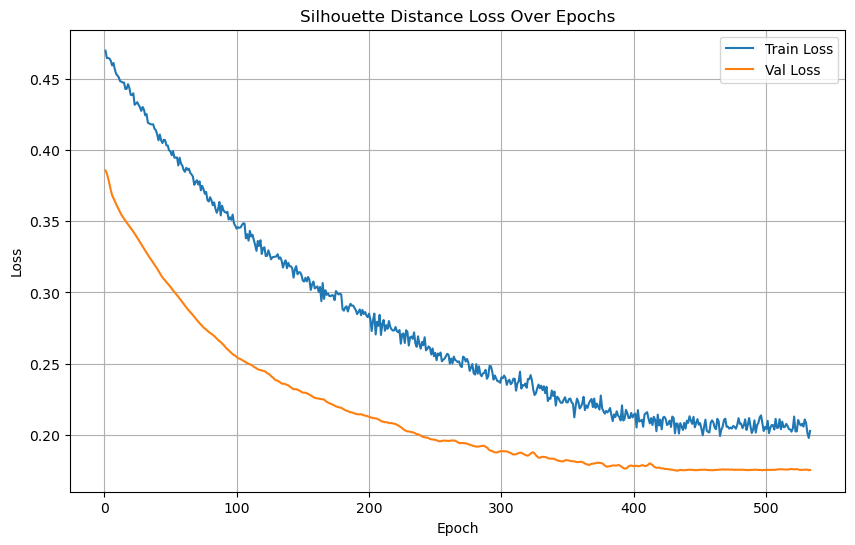

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/835], Loss: 0.1091
Test Batch [20/835], Loss: 0.1290


Test Batch [30/835], Loss: 0.1712
Test Batch [40/835], Loss: 0.5000
Test Batch [50/835], Loss: 0.5000
Test Batch [60/835], Loss: 0.1226
Test Batch [70/835], Loss: 0.1576


Test Batch [80/835], Loss: 0.1475
Test Batch [90/835], Loss: 0.0866


Test Batch [100/835], Loss: 0.1749
Test Batch [110/835], Loss: 0.1263
Test Batch [120/835], Loss: 0.1190
Test Batch [130/835], Loss: 0.1626
Test Batch [140/835], Loss: 0.1359
Test Batch [150/835], Loss: 0.1059


Test Batch [160/835], Loss: 0.1004
Test Batch [170/835], Loss: 0.1217


Test Batch [180/835], Loss: 0.1750
Test Batch [190/835], Loss: 0.1745


Test Batch [200/835], Loss: 0.0917
Test Batch [210/835], Loss: 0.0613
Test Batch [220/835], Loss: 0.0566


Test Batch [230/835], Loss: 0.0914
Test Batch [240/835], Loss: 0.0826


Test Batch [250/835], Loss: 0.1028
Test Batch [260/835], Loss: 0.1178


Test Batch [270/835], Loss: 0.1406
Test Batch [280/835], Loss: 0.1046


Test Batch [290/835], Loss: 0.1686
Test Batch [300/835], Loss: 0.1697


Test Batch [310/835], Loss: 0.1946
Test Batch [320/835], Loss: 0.1581
Test Batch [330/835], Loss: 0.1833
Test Batch [340/835], Loss: 0.5000
Test Batch [350/835], Loss: 0.5000


Test Batch [360/835], Loss: 0.5000
Test Batch [370/835], Loss: 0.5000
Test Batch [380/835], Loss: 0.5000
Test Batch [390/835], Loss: 0.5000


Test Batch [400/835], Loss: 0.5000
Test Batch [410/835], Loss: 0.5000
Test Batch [420/835], Loss: 0.1071
Test Batch [430/835], Loss: 0.0558
Test Batch [440/835], Loss: 0.0674


Test Batch [450/835], Loss: 0.1605
Test Batch [460/835], Loss: 0.0927


Test Batch [470/835], Loss: 0.0817
Test Batch [480/835], Loss: 0.0934
Test Batch [490/835], Loss: 0.5000
Test Batch [500/835], Loss: 0.0773
Test Batch [510/835], Loss: 0.0564


Test Batch [520/835], Loss: 0.0686


Test Batch [530/835], Loss: 0.0495
Test Batch [540/835], Loss: 0.0703
Test Batch [550/835], Loss: 0.0748
Test Batch [560/835], Loss: 0.0790


Test Batch [570/835], Loss: 0.0901
Test Batch [580/835], Loss: 0.1500


Test Batch [590/835], Loss: 0.0703
Test Batch [600/835], Loss: 0.0979
Test Batch [610/835], Loss: 0.5000


Test Batch [620/835], Loss: 0.2662
Test Batch [630/835], Loss: 0.5000


Test Batch [640/835], Loss: 0.1538
Test Batch [650/835], Loss: 0.0959
Test Batch [660/835], Loss: 0.1077


Test Batch [670/835], Loss: 0.3620
Test Batch [680/835], Loss: 0.1022


Test Batch [690/835], Loss: 0.0548
Test Batch [700/835], Loss: 0.3652
Test Batch [710/835], Loss: 0.1640


Test Batch [720/835], Loss: 0.3342
Test Batch [730/835], Loss: 0.3047


Test Batch [740/835], Loss: 0.2293
Test Batch [750/835], Loss: 0.0677
Test Batch [760/835], Loss: 0.1250
Test Batch [770/835], Loss: 0.1953


Test Batch [780/835], Loss: 0.5000
Test Batch [790/835], Loss: 0.1487


Test Batch [800/835], Loss: 0.1706
Test Batch [810/835], Loss: 0.5000
Test Batch [820/835], Loss: 0.1447
Test Batch [830/835], Loss: 0.5000

Test Loss: 0.1976


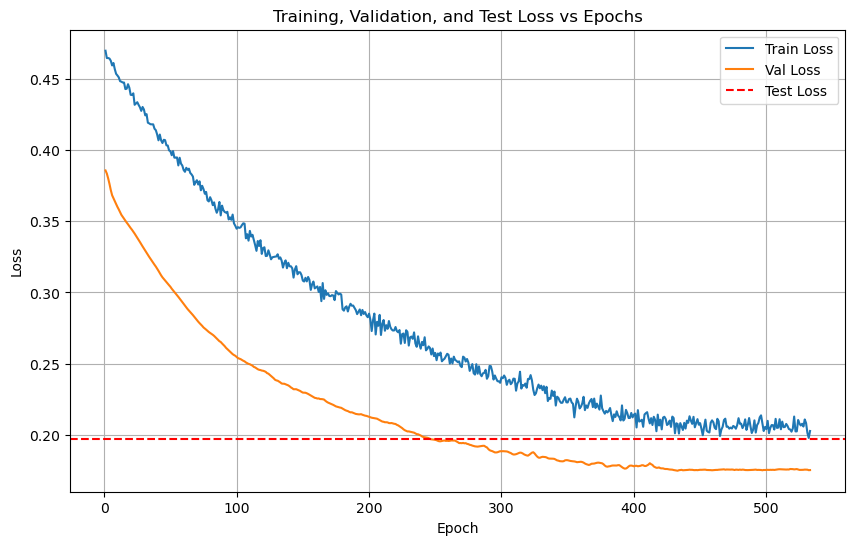

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/835 for test dataset.
  Processed batch 20/835 for test dataset.


  Processed batch 30/835 for test dataset.
  Processed batch 40/835 for test dataset.
  Processed batch 50/835 for test dataset.
  Processed batch 60/835 for test dataset.


  Processed batch 70/835 for test dataset.
  Processed batch 80/835 for test dataset.
  Processed batch 90/835 for test dataset.
  Processed batch 100/835 for test dataset.


  Processed batch 110/835 for test dataset.
  Processed batch 120/835 for test dataset.
  Processed batch 130/835 for test dataset.
  Processed batch 140/835 for test dataset.


  Processed batch 150/835 for test dataset.
  Processed batch 160/835 for test dataset.
  Processed batch 170/835 for test dataset.


  Processed batch 180/835 for test dataset.
  Processed batch 190/835 for test dataset.
  Processed batch 200/835 for test dataset.
  Processed batch 210/835 for test dataset.


  Processed batch 220/835 for test dataset.
  Processed batch 230/835 for test dataset.
  Processed batch 240/835 for test dataset.


  Processed batch 250/835 for test dataset.
  Processed batch 260/835 for test dataset.
  Processed batch 270/835 for test dataset.


  Processed batch 280/835 for test dataset.
  Processed batch 290/835 for test dataset.
  Processed batch 300/835 for test dataset.


  Processed batch 310/835 for test dataset.
  Processed batch 320/835 for test dataset.
  Processed batch 330/835 for test dataset.


  Processed batch 340/835 for test dataset.
  Processed batch 350/835 for test dataset.
  Processed batch 360/835 for test dataset.
  Processed batch 370/835 for test dataset.


  Processed batch 380/835 for test dataset.
  Processed batch 390/835 for test dataset.
  Processed batch 400/835 for test dataset.
  Processed batch 410/835 for test dataset.


  Processed batch 420/835 for test dataset.
  Processed batch 430/835 for test dataset.
  Processed batch 440/835 for test dataset.


  Processed batch 450/835 for test dataset.
  Processed batch 460/835 for test dataset.
  Processed batch 470/835 for test dataset.


  Processed batch 480/835 for test dataset.
  Processed batch 490/835 for test dataset.
  Processed batch 500/835 for test dataset.


  Processed batch 510/835 for test dataset.
  Processed batch 520/835 for test dataset.
  Processed batch 530/835 for test dataset.


  Processed batch 540/835 for test dataset.
  Processed batch 550/835 for test dataset.
  Processed batch 560/835 for test dataset.


  Processed batch 570/835 for test dataset.
  Processed batch 580/835 for test dataset.
  Processed batch 590/835 for test dataset.


  Processed batch 600/835 for test dataset.
  Processed batch 610/835 for test dataset.
  Processed batch 620/835 for test dataset.


  Processed batch 630/835 for test dataset.
  Processed batch 640/835 for test dataset.
  Processed batch 650/835 for test dataset.


  Processed batch 660/835 for test dataset.
  Processed batch 670/835 for test dataset.
  Processed batch 680/835 for test dataset.
  Processed batch 690/835 for test dataset.


  Processed batch 700/835 for test dataset.
  Processed batch 710/835 for test dataset.
  Processed batch 720/835 for test dataset.


  Processed batch 730/835 for test dataset.
  Processed batch 740/835 for test dataset.
  Processed batch 750/835 for test dataset.


  Processed batch 760/835 for test dataset.
  Processed batch 770/835 for test dataset.
  Processed batch 780/835 for test dataset.


  Processed batch 790/835 for test dataset.
  Processed batch 800/835 for test dataset.
  Processed batch 810/835 for test dataset.


  Processed batch 820/835 for test dataset.
  Processed batch 830/835 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (640, 128)
Train labels shape: (640,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53409, 128)
Test labels shape: (53409,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 90.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.71      1.00      0.83         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.67      0.80      0.73         5
           8       1.00      0.80      0.89         5
           9       0.83      1.00      0.91         5
          10       0.83      1.00      0.91         5
          11       1.00      0.80      0.89         5
          12       1.00      0.80      0.89         5
          13       0.7

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (640, 128)
Train labels shape: (640,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53409, 128)
Test labels shape: (53409,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7910  |  Val Loss: 2.7271
Validation loss improved from inf to 2.7271.
[Epoch 2/1000] Train Loss: 2.6797  |  Val Loss: 2.6315
Validation loss improved from 2.7271 to 2.6315.
[Epoch 3/1000] Train Loss: 2.5851  |  Val Loss: 2.5495
Validation loss improved from 2.6315 to 2.5495.
[Epoch 4/1000] Train Loss: 2.5014  |  Val Loss: 2.4793
Validation loss improved from 2.5495 to 2.4793.
[Epoch 5/1000] Train Loss: 2.4306  |  Val Loss: 2.4202
Validation loss improved from 2.4793 to 2.4202.
[Epoch 6/1000] Train Loss: 2.3664  |  Val Loss: 2.3651
Validation loss improved from 2.4202 to 2.3651.
[Epoch 7/1000] Train Loss: 2.3057  |  Val Loss: 2.3140
Validation loss improved from 2.3651 to 2.3140.


[Epoch 8/1000] Train Loss: 2.2470  |  Val Loss: 2.2646
Validation loss improved from 2.3140 to 2.2646.
[Epoch 9/1000] Train Loss: 2.1901  |  Val Loss: 2.2142
Validation loss improved from 2.2646 to 2.2142.
[Epoch 10/1000] Train Loss: 2.1341  |  Val Loss: 2.1643
Validation loss improved from 2.2142 to 2.1643.


[Epoch 11/1000] Train Loss: 2.0778  |  Val Loss: 2.1151
Validation loss improved from 2.1643 to 2.1151.
[Epoch 12/1000] Train Loss: 2.0218  |  Val Loss: 2.0660
Validation loss improved from 2.1151 to 2.0660.
[Epoch 13/1000] Train Loss: 1.9657  |  Val Loss: 2.0170
Validation loss improved from 2.0660 to 2.0170.
[Epoch 14/1000] Train Loss: 1.9092  |  Val Loss: 1.9666
Validation loss improved from 2.0170 to 1.9666.
[Epoch 15/1000] Train Loss: 1.8518  |  Val Loss: 1.9167
Validation loss improved from 1.9666 to 1.9167.
[Epoch 16/1000] Train Loss: 1.7945  |  Val Loss: 1.8660
Validation loss improved from 1.9167 to 1.8660.
[Epoch 17/1000] Train Loss: 1.7351  |  Val Loss: 1.8142
Validation loss improved from 1.8660 to 1.8142.


[Epoch 18/1000] Train Loss: 1.6756  |  Val Loss: 1.7634
Validation loss improved from 1.8142 to 1.7634.
[Epoch 19/1000] Train Loss: 1.6165  |  Val Loss: 1.7132
Validation loss improved from 1.7634 to 1.7132.
[Epoch 20/1000] Train Loss: 1.5595  |  Val Loss: 1.6644
Validation loss improved from 1.7132 to 1.6644.
[Epoch 21/1000] Train Loss: 1.5041  |  Val Loss: 1.6170
Validation loss improved from 1.6644 to 1.6170.


[Epoch 22/1000] Train Loss: 1.4506  |  Val Loss: 1.5726
Validation loss improved from 1.6170 to 1.5726.
[Epoch 23/1000] Train Loss: 1.3988  |  Val Loss: 1.5296
Validation loss improved from 1.5726 to 1.5296.
[Epoch 24/1000] Train Loss: 1.3494  |  Val Loss: 1.4889
Validation loss improved from 1.5296 to 1.4889.
[Epoch 25/1000] Train Loss: 1.3017  |  Val Loss: 1.4487
Validation loss improved from 1.4889 to 1.4487.
[Epoch 26/1000] Train Loss: 1.2561  |  Val Loss: 1.4116
Validation loss improved from 1.4487 to 1.4116.
[Epoch 27/1000] Train Loss: 1.2121  |  Val Loss: 1.3755
Validation loss improved from 1.4116 to 1.3755.
[Epoch 28/1000] Train Loss: 1.1699  |  Val Loss: 1.3404
Validation loss improved from 1.3755 to 1.3404.


[Epoch 29/1000] Train Loss: 1.1300  |  Val Loss: 1.3063
Validation loss improved from 1.3404 to 1.3063.
[Epoch 30/1000] Train Loss: 1.0912  |  Val Loss: 1.2755
Validation loss improved from 1.3063 to 1.2755.
[Epoch 31/1000] Train Loss: 1.0526  |  Val Loss: 1.2438
Validation loss improved from 1.2755 to 1.2438.
[Epoch 32/1000] Train Loss: 1.0167  |  Val Loss: 1.2101
Validation loss improved from 1.2438 to 1.2101.


[Epoch 33/1000] Train Loss: 0.9824  |  Val Loss: 1.1778
Validation loss improved from 1.2101 to 1.1778.
[Epoch 34/1000] Train Loss: 0.9480  |  Val Loss: 1.1492
Validation loss improved from 1.1778 to 1.1492.
[Epoch 35/1000] Train Loss: 0.9160  |  Val Loss: 1.1204
Validation loss improved from 1.1492 to 1.1204.
[Epoch 36/1000] Train Loss: 0.8854  |  Val Loss: 1.0901
Validation loss improved from 1.1204 to 1.0901.
[Epoch 37/1000] Train Loss: 0.8551  |  Val Loss: 1.0659
Validation loss improved from 1.0901 to 1.0659.
[Epoch 38/1000] Train Loss: 0.8272  |  Val Loss: 1.0399
Validation loss improved from 1.0659 to 1.0399.


[Epoch 39/1000] Train Loss: 0.8001  |  Val Loss: 1.0150
Validation loss improved from 1.0399 to 1.0150.
[Epoch 40/1000] Train Loss: 0.7739  |  Val Loss: 0.9852
Validation loss improved from 1.0150 to 0.9852.
[Epoch 41/1000] Train Loss: 0.7489  |  Val Loss: 0.9617
Validation loss improved from 0.9852 to 0.9617.
[Epoch 42/1000] Train Loss: 0.7243  |  Val Loss: 0.9346
Validation loss improved from 0.9617 to 0.9346.


[Epoch 43/1000] Train Loss: 0.7014  |  Val Loss: 0.9105
Validation loss improved from 0.9346 to 0.9105.
[Epoch 44/1000] Train Loss: 0.6786  |  Val Loss: 0.8924
Validation loss improved from 0.9105 to 0.8924.
[Epoch 45/1000] Train Loss: 0.6572  |  Val Loss: 0.8701
Validation loss improved from 0.8924 to 0.8701.
[Epoch 46/1000] Train Loss: 0.6361  |  Val Loss: 0.8528
Validation loss improved from 0.8701 to 0.8528.
[Epoch 47/1000] Train Loss: 0.6162  |  Val Loss: 0.8334
Validation loss improved from 0.8528 to 0.8334.
[Epoch 48/1000] Train Loss: 0.5967  |  Val Loss: 0.8162
Validation loss improved from 0.8334 to 0.8162.
[Epoch 49/1000] Train Loss: 0.5781  |  Val Loss: 0.8022
Validation loss improved from 0.8162 to 0.8022.


[Epoch 50/1000] Train Loss: 0.5603  |  Val Loss: 0.7885
Validation loss improved from 0.8022 to 0.7885.
[Epoch 51/1000] Train Loss: 0.5429  |  Val Loss: 0.7756
Validation loss improved from 0.7885 to 0.7756.
[Epoch 52/1000] Train Loss: 0.5257  |  Val Loss: 0.7634
Validation loss improved from 0.7756 to 0.7634.


[Epoch 53/1000] Train Loss: 0.5094  |  Val Loss: 0.7510
Validation loss improved from 0.7634 to 0.7510.
[Epoch 54/1000] Train Loss: 0.4946  |  Val Loss: 0.7414
Validation loss improved from 0.7510 to 0.7414.
[Epoch 55/1000] Train Loss: 0.4781  |  Val Loss: 0.7302
Validation loss improved from 0.7414 to 0.7302.
[Epoch 56/1000] Train Loss: 0.4632  |  Val Loss: 0.7201
Validation loss improved from 0.7302 to 0.7201.
[Epoch 57/1000] Train Loss: 0.4490  |  Val Loss: 0.7105
Validation loss improved from 0.7201 to 0.7105.
[Epoch 58/1000] Train Loss: 0.4354  |  Val Loss: 0.7015
Validation loss improved from 0.7105 to 0.7015.
[Epoch 59/1000] Train Loss: 0.4217  |  Val Loss: 0.6943
Validation loss improved from 0.7015 to 0.6943.
[Epoch 60/1000] Train Loss: 0.4084  |  Val Loss: 0.6869
Validation loss improved from 0.6943 to 0.6869.


[Epoch 61/1000] Train Loss: 0.3960  |  Val Loss: 0.6793
Validation loss improved from 0.6869 to 0.6793.
[Epoch 62/1000] Train Loss: 0.3842  |  Val Loss: 0.6740
Validation loss improved from 0.6793 to 0.6740.
[Epoch 63/1000] Train Loss: 0.3718  |  Val Loss: 0.6668
Validation loss improved from 0.6740 to 0.6668.


[Epoch 64/1000] Train Loss: 0.3608  |  Val Loss: 0.6617
Validation loss improved from 0.6668 to 0.6617.
[Epoch 65/1000] Train Loss: 0.3497  |  Val Loss: 0.6560
Validation loss improved from 0.6617 to 0.6560.
[Epoch 66/1000] Train Loss: 0.3388  |  Val Loss: 0.6491
Validation loss improved from 0.6560 to 0.6491.
[Epoch 67/1000] Train Loss: 0.3288  |  Val Loss: 0.6435
Validation loss improved from 0.6491 to 0.6435.
[Epoch 68/1000] Train Loss: 0.3186  |  Val Loss: 0.6375
Validation loss improved from 0.6435 to 0.6375.
[Epoch 69/1000] Train Loss: 0.3089  |  Val Loss: 0.6316
Validation loss improved from 0.6375 to 0.6316.
[Epoch 70/1000] Train Loss: 0.2999  |  Val Loss: 0.6266
Validation loss improved from 0.6316 to 0.6266.
[Epoch 71/1000] Train Loss: 0.2911  |  Val Loss: 0.6221
Validation loss improved from 0.6266 to 0.6221.


[Epoch 72/1000] Train Loss: 0.2821  |  Val Loss: 0.6166
Validation loss improved from 0.6221 to 0.6166.
[Epoch 73/1000] Train Loss: 0.2741  |  Val Loss: 0.6129
Validation loss improved from 0.6166 to 0.6129.


[Epoch 74/1000] Train Loss: 0.2661  |  Val Loss: 0.6092
Validation loss improved from 0.6129 to 0.6092.
[Epoch 75/1000] Train Loss: 0.2584  |  Val Loss: 0.6070
Validation loss improved from 0.6092 to 0.6070.
[Epoch 76/1000] Train Loss: 0.2508  |  Val Loss: 0.6033
Validation loss improved from 0.6070 to 0.6033.
[Epoch 77/1000] Train Loss: 0.2437  |  Val Loss: 0.6003
Validation loss improved from 0.6033 to 0.6003.
[Epoch 78/1000] Train Loss: 0.2367  |  Val Loss: 0.5985
Validation loss improved from 0.6003 to 0.5985.
[Epoch 79/1000] Train Loss: 0.2303  |  Val Loss: 0.5973
Validation loss improved from 0.5985 to 0.5973.
[Epoch 80/1000] Train Loss: 0.2237  |  Val Loss: 0.5931
Validation loss improved from 0.5973 to 0.5931.
[Epoch 81/1000] Train Loss: 0.2177  |  Val Loss: 0.5911
Validation loss improved from 0.5931 to 0.5911.


[Epoch 82/1000] Train Loss: 0.2118  |  Val Loss: 0.5889
Validation loss improved from 0.5911 to 0.5889.
[Epoch 83/1000] Train Loss: 0.2063  |  Val Loss: 0.5877
Validation loss improved from 0.5889 to 0.5877.
[Epoch 84/1000] Train Loss: 0.2010  |  Val Loss: 0.5877
Validation loss improved from 0.5877 to 0.5877.


[Epoch 85/1000] Train Loss: 0.1958  |  Val Loss: 0.5866
Validation loss improved from 0.5877 to 0.5866.
[Epoch 86/1000] Train Loss: 0.1908  |  Val Loss: 0.5874
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 87/1000] Train Loss: 0.1860  |  Val Loss: 0.5864
Validation loss improved from 0.5866 to 0.5864.
[Epoch 88/1000] Train Loss: 0.1818  |  Val Loss: 0.5849
Validation loss improved from 0.5864 to 0.5849.
[Epoch 89/1000] Train Loss: 0.1775  |  Val Loss: 0.5856
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 90/1000] Train Loss: 0.1734  |  Val Loss: 0.5865
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 91/1000] Train Loss: 0.1693  |  Val Loss: 0.5860
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 92/1000] Train Loss: 0.1656  |  Val Loss: 0.5845
Validation loss improved from 0.5849 to 0.5845.


[Epoch 93/1000] Train Loss: 0.1616  |  Val Loss: 0.5835
Validation loss improved from 0.5845 to 0.5835.
[Epoch 94/1000] Train Loss: 0.1582  |  Val Loss: 0.5833
Validation loss improved from 0.5835 to 0.5833.
[Epoch 95/1000] Train Loss: 0.1549  |  Val Loss: 0.5849
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 96/1000] Train Loss: 0.1518  |  Val Loss: 0.5853
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 97/1000] Train Loss: 0.1484  |  Val Loss: 0.5851
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 98/1000] Train Loss: 0.1450  |  Val Loss: 0.5844
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 99/1000] Train Loss: 0.1425  |  Val Loss: 0.5810
Validation loss improved from 0.5833 to 0.5810.
[Epoch 100/1000] Train Loss: 0.1401  |  Val Loss: 0.5853
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 101/1000] Train Loss: 0.1368  |  Val Loss: 0.5819
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 102/1000] Train Loss: 0.1344  |  Val Loss: 0.5809
Validation loss improved from 0.5810 to 0.5809.
[Epoch 103/1000] Train Loss: 0.1320  |  Val Loss: 0.5849
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 104/1000] Train Loss: 0.1294  |  Val Loss: 0.5839
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 105/1000] Train Loss: 0.1271  |  Val Loss: 0.5805
Validation loss improved from 0.5809 to 0.5805.


[Epoch 106/1000] Train Loss: 0.1245  |  Val Loss: 0.5823
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 107/1000] Train Loss: 0.1225  |  Val Loss: 0.5852
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 108/1000] Train Loss: 0.1202  |  Val Loss: 0.5856
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 109/1000] Train Loss: 0.1184  |  Val Loss: 0.5844
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 110/1000] Train Loss: 0.1164  |  Val Loss: 0.5862
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 111/1000] Train Loss: 0.1144  |  Val Loss: 0.5863
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 112/1000] Train Loss: 0.1130  |  Val Loss: 0.5872
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 113/1000] Train Loss: 0.1112  |  Val Loss: 0.5880
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 114/1000] Train Loss: 0.1094  |  Val Loss: 0.5910
!! Validation loss did NOT improve !! Patience: 9/100


[Epoch 115/1000] Train Loss: 0.1077  |  Val Loss: 0.5918
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 116/1000] Train Loss: 0.1062  |  Val Loss: 0.5919
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 117/1000] Train Loss: 0.1050  |  Val Loss: 0.5921
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 118/1000] Train Loss: 0.1034  |  Val Loss: 0.5924
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 119/1000] Train Loss: 0.1017  |  Val Loss: 0.5952
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 120/1000] Train Loss: 0.1002  |  Val Loss: 0.5981
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 121/1000] Train Loss: 0.0991  |  Val Loss: 0.6002
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 122/1000] Train Loss: 0.0977  |  Val Loss: 0.6035
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 123/1000] Train Loss: 0.0963  |  Val Loss: 0.6040
!! Validation loss did NOT improve !! Patience:

[Epoch 125/1000] Train Loss: 0.0939  |  Val Loss: 0.6032
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 126/1000] Train Loss: 0.0930  |  Val Loss: 0.6069
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 127/1000] Train Loss: 0.0923  |  Val Loss: 0.6082
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 128/1000] Train Loss: 0.0905  |  Val Loss: 0.6103
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 129/1000] Train Loss: 0.0895  |  Val Loss: 0.6082
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 130/1000] Train Loss: 0.0884  |  Val Loss: 0.6085
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 131/1000] Train Loss: 0.0872  |  Val Loss: 0.6103
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 132/1000] Train Loss: 0.0865  |  Val Loss: 0.6111
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 133/1000] Train Loss: 0.0855  |  Val Loss: 0.6142
!! Validation loss did NOT improve !! Patience:

[Epoch 136/1000] Train Loss: 0.0826  |  Val Loss: 0.6180
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 137/1000] Train Loss: 0.0819  |  Val Loss: 0.6209
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 138/1000] Train Loss: 0.0808  |  Val Loss: 0.6208
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 139/1000] Train Loss: 0.0802  |  Val Loss: 0.6223
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 140/1000] Train Loss: 0.0793  |  Val Loss: 0.6234
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 141/1000] Train Loss: 0.0783  |  Val Loss: 0.6260
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 142/1000] Train Loss: 0.0776  |  Val Loss: 0.6271
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 143/1000] Train Loss: 0.0769  |  Val Loss: 0.6314
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 144/1000] Train Loss: 0.0764  |  Val Loss: 0.6312
!! Validation loss did NOT improve !! Patience:

[Epoch 146/1000] Train Loss: 0.0752  |  Val Loss: 0.6321
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 147/1000] Train Loss: 0.0742  |  Val Loss: 0.6356
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 148/1000] Train Loss: 0.0733  |  Val Loss: 0.6396
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 149/1000] Train Loss: 0.0728  |  Val Loss: 0.6379
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 150/1000] Train Loss: 0.0721  |  Val Loss: 0.6398
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 151/1000] Train Loss: 0.0719  |  Val Loss: 0.6417
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 152/1000] Train Loss: 0.0708  |  Val Loss: 0.6435
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 153/1000] Train Loss: 0.0705  |  Val Loss: 0.6458
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 154/1000] Train Loss: 0.0695  |  Val Loss: 0.6495
!! Validation loss did NOT improve !! Patience:

[Epoch 157/1000] Train Loss: 0.0679  |  Val Loss: 0.6562
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 158/1000] Train Loss: 0.0675  |  Val Loss: 0.6524
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 159/1000] Train Loss: 0.0669  |  Val Loss: 0.6581
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 160/1000] Train Loss: 0.0664  |  Val Loss: 0.6583
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 161/1000] Train Loss: 0.0658  |  Val Loss: 0.6602
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 162/1000] Train Loss: 0.0652  |  Val Loss: 0.6645
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 163/1000] Train Loss: 0.0650  |  Val Loss: 0.6630
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 164/1000] Train Loss: 0.0644  |  Val Loss: 0.6640
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 165/1000] Train Loss: 0.0636  |  Val Loss: 0.6678
!! Validation loss did NOT improve !! Patience:

[Epoch 168/1000] Train Loss: 0.0626  |  Val Loss: 0.6716
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 169/1000] Train Loss: 0.0618  |  Val Loss: 0.6732
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 170/1000] Train Loss: 0.0614  |  Val Loss: 0.6775
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 171/1000] Train Loss: 0.0611  |  Val Loss: 0.6818
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 172/1000] Train Loss: 0.0610  |  Val Loss: 0.6855
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 173/1000] Train Loss: 0.0602  |  Val Loss: 0.6824
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 174/1000] Train Loss: 0.0599  |  Val Loss: 0.6826
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 175/1000] Train Loss: 0.0595  |  Val Loss: 0.6864
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 176/1000] Train Loss: 0.0593  |  Val Loss: 0.6926
!! Validation loss did NOT improve !! Patience:

[Epoch 178/1000] Train Loss: 0.0585  |  Val Loss: 0.6908
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 179/1000] Train Loss: 0.0581  |  Val Loss: 0.6952
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 180/1000] Train Loss: 0.0579  |  Val Loss: 0.6978
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 181/1000] Train Loss: 0.0571  |  Val Loss: 0.6988
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 182/1000] Train Loss: 0.0571  |  Val Loss: 0.6980
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 183/1000] Train Loss: 0.0564  |  Val Loss: 0.7043
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 184/1000] Train Loss: 0.0563  |  Val Loss: 0.7078
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 185/1000] Train Loss: 0.0559  |  Val Loss: 0.7066
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 186/1000] Train Loss: 0.0555  |  Val Loss: 0.7057
!! Validation loss did NOT improve !! Patience:

[Epoch 189/1000] Train Loss: 0.0544  |  Val Loss: 0.7136
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 190/1000] Train Loss: 0.0542  |  Val Loss: 0.7165
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 191/1000] Train Loss: 0.0536  |  Val Loss: 0.7190
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 192/1000] Train Loss: 0.0537  |  Val Loss: 0.7218
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 193/1000] Train Loss: 0.0542  |  Val Loss: 0.7171
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 194/1000] Train Loss: 0.0534  |  Val Loss: 0.7239
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 195/1000] Train Loss: 0.0530  |  Val Loss: 0.7277
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 196/1000] Train Loss: 0.0527  |  Val Loss: 0.7275
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 197/1000] Train Loss: 0.0520  |  Val Loss: 0.7307
!! Validation loss did NOT improve !! Patience:

[Epoch 200/1000] Train Loss: 0.0513  |  Val Loss: 0.7367
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 201/1000] Train Loss: 0.0509  |  Val Loss: 0.7365
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 202/1000] Train Loss: 0.0505  |  Val Loss: 0.7378
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 203/1000] Train Loss: 0.0503  |  Val Loss: 0.7425
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 204/1000] Train Loss: 0.0504  |  Val Loss: 0.7443
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 205/1000] Train Loss: 0.0499  |  Val Loss: 0.7457
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 205 !!
No improvement for 100 epochs.


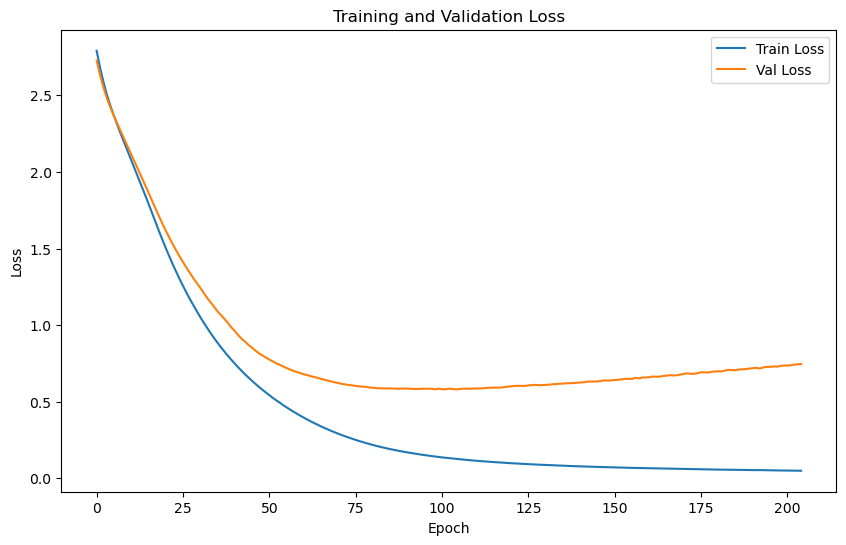

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.5276 | Test Accuracy: 86.27%


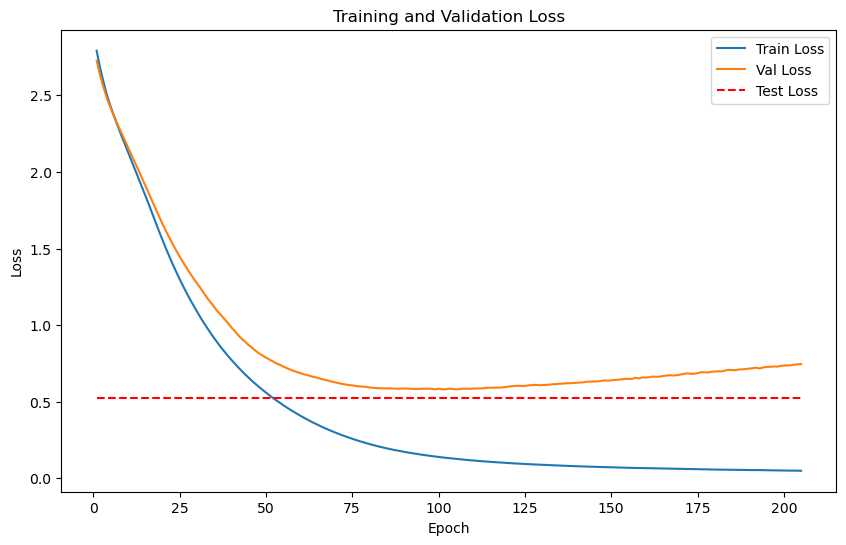

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


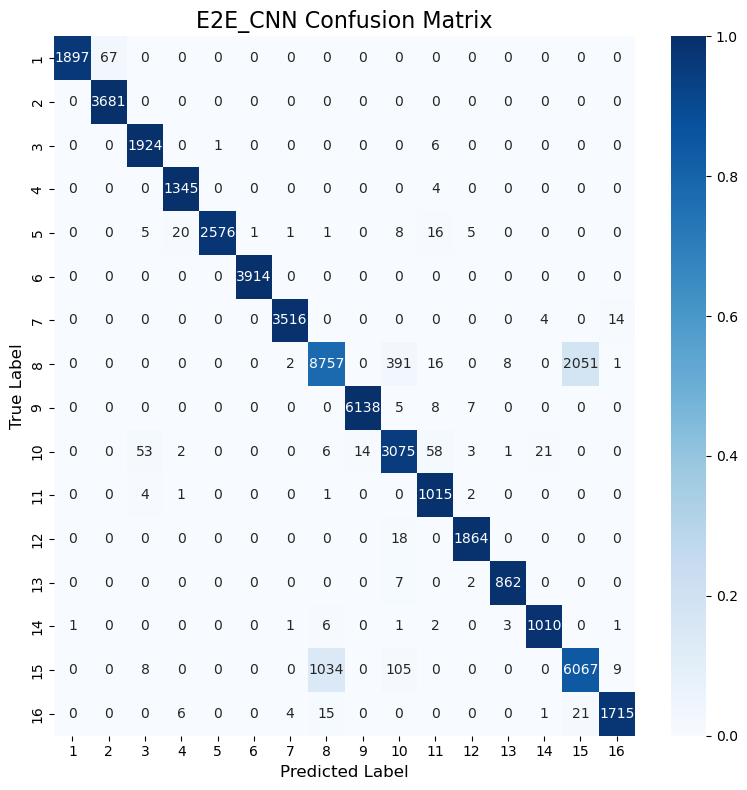

Classification Accuracy: 92.41%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


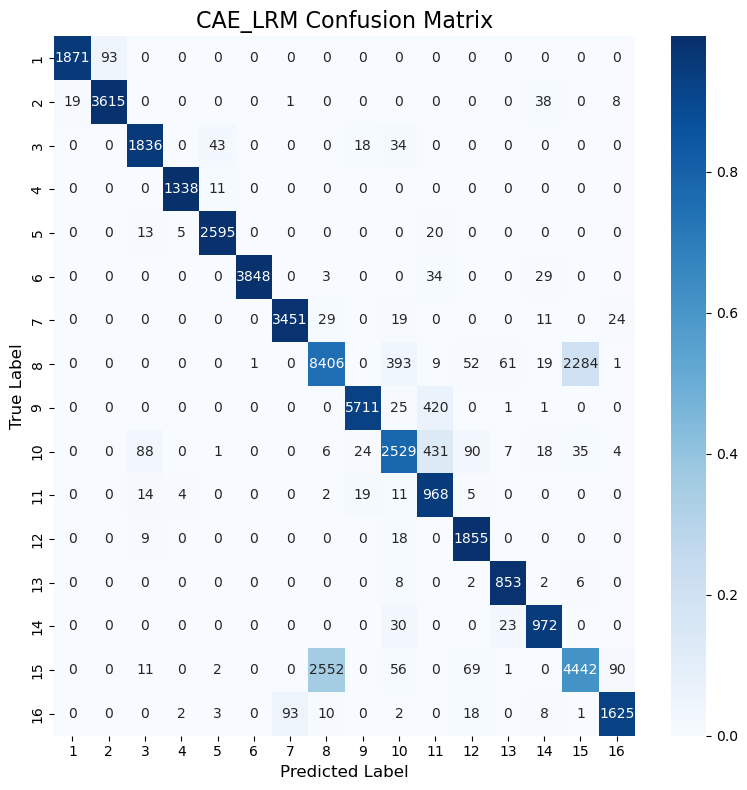

Classification Accuracy: 85.97%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


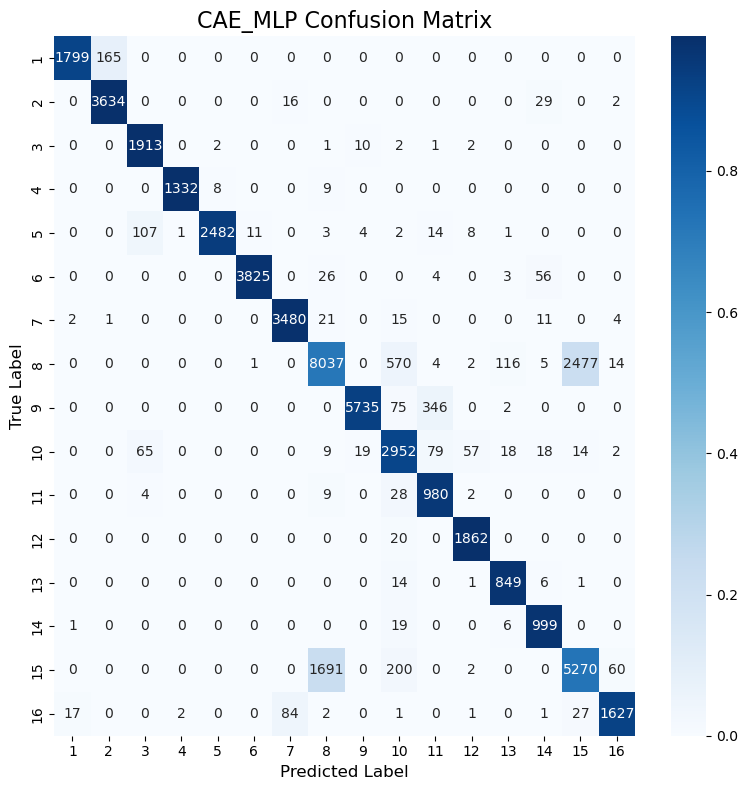

Classification Accuracy: 87.58%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


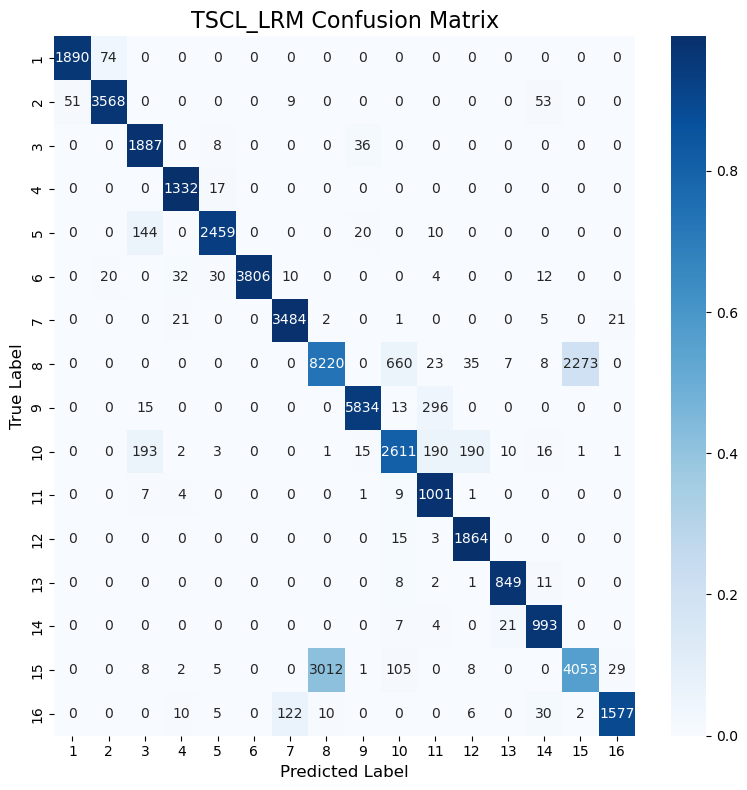

Classification Accuracy: 85.06%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


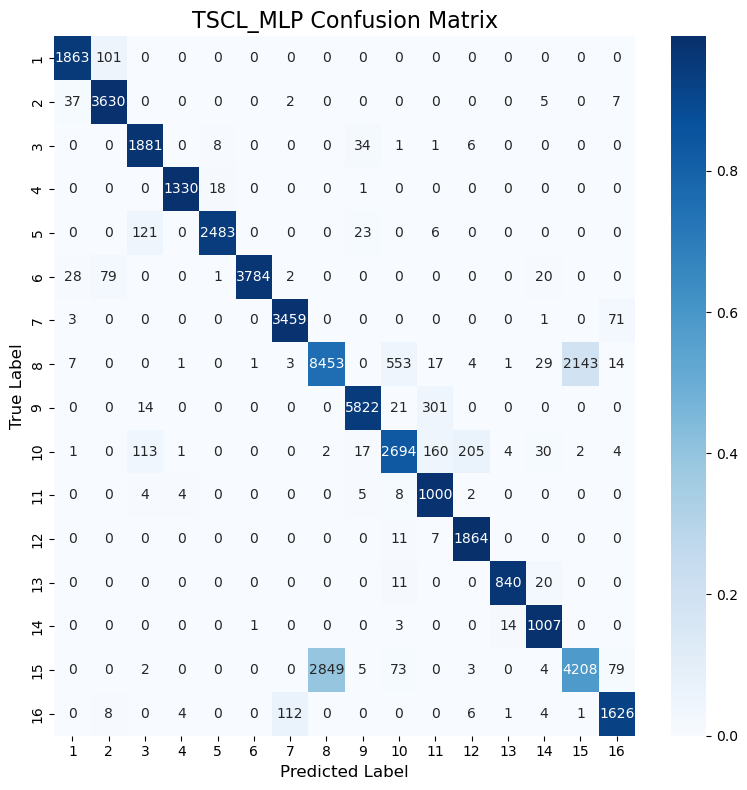

Classification Accuracy: 86.02%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


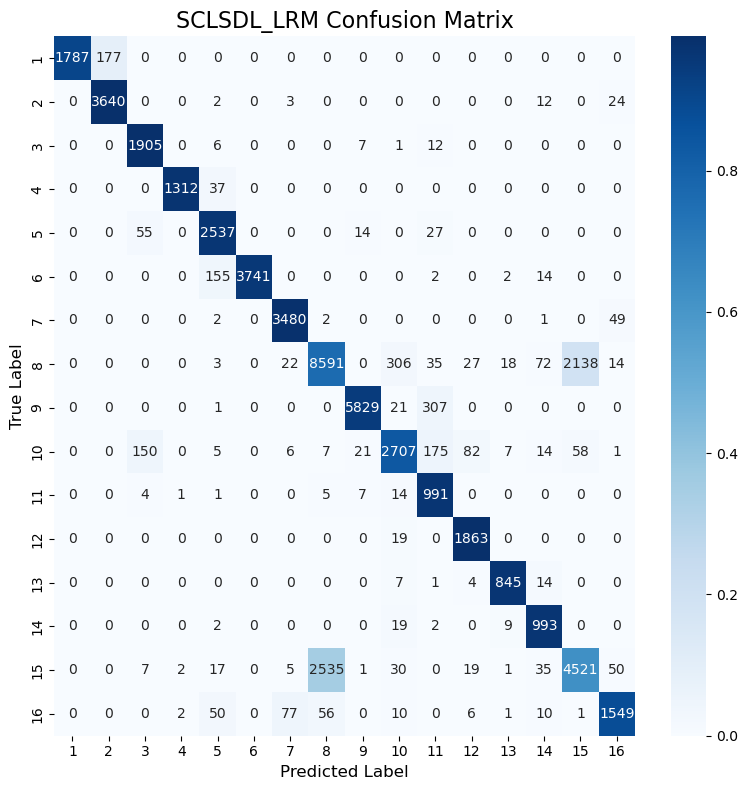

Classification Accuracy: 86.67%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


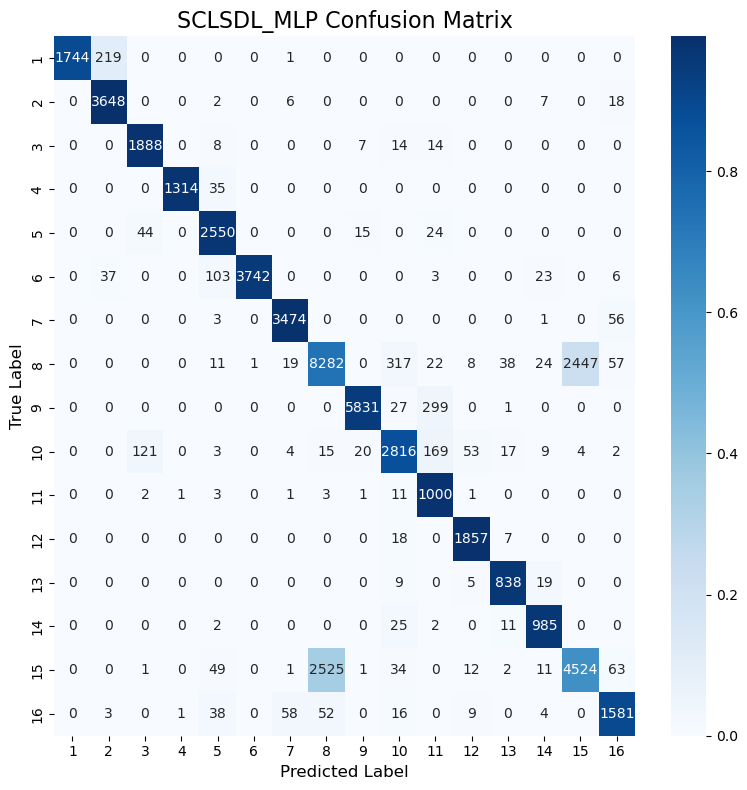

Classification Accuracy: 86.27%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          92.41
1    LRM (CAE)          85.97
2    MLP (CAE)          87.58
3     TSCL LRM          85.06
4     TSCL MLP          86.02
5  SCL_SDL LRM          86.67
6  SCL_SDL MLP          86.27

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          92.41
2    MLP (CAE)          87.58
5  SCL_SDL LRM          86.67
6  SCL_SDL MLP          86.27
4     TSCL MLP          86.02
1    LRM (CAE)          85.97
3     TSCL LRM          85.06
